# Assignment 2

You are expected to complete this notebook with lines of code, plots and texts. You will need to create new cells with original code or text for your analyses and explanations. Explain what you do and analyze your results. This assignment has a total of 100 points.

Using Canvas, you will deliver the notebook file (.ipynb) with cells executed and outputs visible.
- You should use PyTorch 1.0 or later as your deep learning framework. If you need to import a different package than the ones already imported, ask the TA if you can do it.
- No other data than the dataset variables provided should be used, and training, validation and testing splits should be the same as the ones provided.
- The cell outputs present in your delivered notebook should be reproducible by us by running your notebook cells in order.
- All code must be your own work. Code cannot be copied from another source or student. You may copy code from cells that were pre-defined in this notebook if you think it is useful for use in another part of the notebook.
- All images must be generated from data generated in your code. Do NOT import/display images generated outside your code.
- Your analysis must be your own, but if you quote text or equations from another source make sure to cite the reference.
- It is assumed that PyTorch is already installed according to the CADE or the COLAB tutorial.

Other notes:
- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and its comments, as it contains variables and information that you may need to use to complete the notebook.
- To create a text cell, create it with the "+" button and change its type from "Code" to "Markdown" using the top menu. To modify a text cell, double click on it.
- If you are interested, you can check detail on formatting markdown text here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- The accuracies provided as required for each question are there to make sure you work enough on each model to get a good result. Part of the grade is based on this.

Tips for training deep learning models:
- Since the datasets being used here are small, you are probably going to have to use early stopping as a way of preventing overfitting. This means you will have to save models in the middle of training. One of the ways to save models on memory is to do a deep copy of it (using ```copy.deepcopy``` ). 
- It is also recommended to frequently (at least once every epoch) print the loss of the model and the score it is getting at its intended task, to follow if the model is learning something and if it is still improving. Usually you will need somewhere between 1 and 15 epochs for your model to get the required accuracy in this assignment.
- To search for the best hyperparameters for your model, it is usually better to start searching in a logarithmic scale. Usually powers of 2 or 10 are used. 
- In https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2, different optimal learning rates for different optimizers were found for a different task. This could help in your search of optimal learning rate. For this assignment, you will probably get the best results by using Adam and searching for the best learning rate in the range of good learning rates provided in the cited page, which for Adam is from 0.00005 to 0.01.
- Batch size seems to have a smaller impact than learning rate in the results. It should be enough if you test batch sizes between 8 and 32.
- We assume a GPU of at least 4GB of memory is available. If you want to try running the assignment with a GPU that has less than that, you can try changing the argument passed when calling the ```define_gpu_to_use``` function.  If you are getting out-of-memory errors for the GPU, you may want to check what is occupying the GPU memory by using the command ```!nvidia-smi```, which gives a report of the use of the GPU. 
- For some of the questions, it might be useful for you to understand what the resnet18 PyTorch model is doing. You can have access to its source code here: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py . The most important part to understand should be the ```forward``` function from the ```ResNet``` class. It might also be useful to print PyTorch models using ```print(model)```. This should give you a list of all the layers present in the model.
- Between CADE and COLAB (i.e. Google Colaboratory), CADE is probably the best option for running this assignment, since it seems to be about 50% faster than COLAB and files are not erased when resetting sessions. CADE has a small disk quota for the home directory, so it might be necessary, depending on how much your home directory is already occupied, to store the virtual environment inside a folder in ```/scratch/tmp/```. For CADE, datasets are already downloaded and stored in a scratch folder accessible to everyone.
- If you are using Google Colaboratory, it might be interesting to store the datasets on your Google Drive to prevent having to download it every time you restart your sessions. For that, you will probably need to add the line ```drive.mount('/content/gdrive')``` and change the ```pre_folder``` variable to ```'gdrive/My Drive'```. This was not tested, so some adjustments may be needed.
- There are a few PyTorch details not to forget:
    - Remember to toggle train/eval mode for your model
    - Remember to reset the gradients with ```zero_grad()``` before each call to ```backward()```
    - Remember to check if the loss you are using receives logits or probabilities, and adapt your model output accordingly.
    - Remember to reinstantiate your model every time you are starting a new training, so that weights are reset.
    - Remember to pass to the optimizer the set of parameters for the model you want to train.
- Starting training from a pretrained model instead of starting it from scratch usually helps to get a better final result. For the exercises that use the resnet18 model from PyTorch, you can start training with the model pretrained on ImageNet that is provided by PyTorch.

#### Installing and loading libraries

In [1]:
!pip3 install --user -q kaggle
!pip3 install --user pydicom
!pip3 install --user scikit-learn
!pip3 install --user torch torchvision
!pip3 install --user torchsummary

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import getpass
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
from sklearn.metrics import roc_curve, auc
import copy
import torchvision.models as models
import tarfile
%matplotlib inline

#### Defining folders where data should be saved/loaded

In [3]:
#checking what kind of system you are using
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

#defining the folders where datasets will be, depending on the system
machine_being_used = 'cade' if IN_CADE else ('colab' if IN_COLAB else 'other')
pre_folder = '/scratch/tmp/' if machine_being_used == 'cade' else './'
pneumonia_dataset_folder = pre_folder + 'deep_learning_datasets_ECE_6960_013/kaggle_pneumonia'
xray14_dataset_folder = pre_folder + 'deep_learning_datasets_ECE_6960_013/chestxray14'

#### Defining the GPU to use and reserving its memory for this notebook

In [4]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
#setting the gpu that will be used, testing if it has enough available memory, and reserving the needed memory
define_gpu_to_use()

Chosen GPU: 0


#### Defining functions that are used internally in both exercises

In [6]:
# defining a pre-transformation class that is used to preprocess the images
# this class receives a Pillow Image, and crops it so that it has a 1:1 aspect
# ratio (i.e. a square). It chooses the biggest square possible that fits in the image
# and centers it.
# this is important for medical datasets, since a lot of them have images
# with different aspect ratios and this is one way of dealing with it and 
# standardizing the inputs
class CropBiggestCenteredInscribedSquare(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        return tensor.crop(
            (
                -horizontal_padding,
                -vertical_padding,
                tensor.size[0] + horizontal_padding,
                tensor.size[1] + vertical_padding
            )
        )

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [7]:
#split can be 'train', 'val', and 'test'
#this is the function that splits a dataset into training, validation and testing set
#We are using a split of 60%-20%-20%, for train-val-test, respectively
#this function is used internally to the defined dataset classes
# In medical datasets possibly containing more than one example for the same subject/patient,
# this function should be applied to the list of patients/subjects, and not to the list of examples
# since in a real-world application you will not find the same subject/patient as your training data had,
# and therefore you should measure how well your model is doing in the same settings
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.6)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.6):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split


#### Defining functions that might be useful for you in both exercises

In [8]:
# use this function to 
# count how many parameters (learnable parameters, more specifically)
# there are in a pytorch model
def count_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Exercise 1: ChestXray14 Dataset
**(56 points total)**
>### Brief explanation of the dataset
> In this exercise we will use the ChestXray14 dataset. This dataset contains more than 100,000 frontal chest x-rays and labels for 14 different conditions. These labels were extracted from radiologists' reports associated with each image using natural language processing techniques. It was released at the end of 2017 and until the beginning of 2019, when CheXpert (https://stanfordmlgroup.github.io/competitions/chexpert/) and MIMIC-CXR (https://physionet.nlm.nih.gov/physiobank/database/mimiccxr/) were released, it was the best source for a large amount of training data for models using chest x-rays. These other two mentioned datasets contain about 300,000 images each, and contain x-ray studies with both the lateral and the frontal view. Using both views has been shown to improve results in deep learning models (https://arxiv.org/abs/1804.07839). More information about the ChestXray14 dataset can be found here: https://stanfordmlgroup.github.io/projects/chexnet/. The dataset was also criticized regarding the choice of label classes, among other things. More information about this can be found in these two blog posts by Luke Oakden-Rayner: https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/ and https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/. 

We will be using only a subset of this dataset, 14,999 images total, so that we can have smaller loading and training times. The labels of this dataset follow a multi-label structure, which means that more than one label can be present for a single image, and images with no anomaly have no label associated with them.

**Important:** Please download the file **Data_Entry_2017.csv** from https://nihcc.app.box.com/v/ChestXray-NIHCC and put it in the same directory as this notebook. If you are using Google Colaboratory, use the python command ```files.upload()``` below to upload the file. Same thing for the file **image_names_chestxray14.csv**, provided with the assignment.

For this exercise, we will use the AUC (also called AUROC) metric to evaluate models. The AUC metric is defined as the area under the Receiver Operating Characteristic (ROC) curve. The AUC is a score between 0 and 1. An AUC of 0.5 is what a model giving random outputs can reach. The higher the AUC, the better the model is. The ROC curve is frequently used for medical tasks since it tries to measure the trade-off of a model in terms of false positives and false negatives (sensitivity and specificity, to be more precise), and a lot of medical tasks tries to avoid either false negatives or false positives. ROC is also insensitive to imbalanced datasets, which is important in this exercise, since it is a highly imbalanced dataset, as we will see.

#### Getting the dataset and defining loading and processing  steps

In [9]:
# If you are using Google Colaboratory, use the next line to upload the Dataset_Entry_2017.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [10]:
# If you are using Google Colaboratory, use the next line to upload the image_names_chestxray14.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [11]:
#Download part of the dataset if it was not downloaded yet
#downloading it to the xray14_dataset_folder folder

#function to report how much has been downloaded so far
def report_hook(count_so_far, block_size, total_size):
    current_percentage = (count_so_far * block_size * 100 // total_size)
    previous_percentage = ((count_so_far - 1) * block_size * 100 // total_size)
    if current_percentage != previous_percentage:
        sys.stdout.write('\r' + str((count_so_far * block_size * 100 // total_size)) + '% of download completed')
        sys.stdout.flush()

if xray14_dataset_folder != '/scratch/tmp/deep_learning_datasets_ECE_6960_013/chestxray14':
    os.makedirs(xray14_dataset_folder, exist_ok=True)
    from urllib.request import urlretrieve
    destination_file = xray14_dataset_folder + '/images_4.tar.gz'
    link = 'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz'
    if not os.path.isfile(destination_file):
        urlretrieve(link, destination_file, reporthook = report_hook)

    destination_file = xray14_dataset_folder + '/images_1.tar.gz'
    link = 'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz'
    if not os.path.isfile(destination_file):
        urlretrieve(link, destination_file, reporthook = report_hook)

In [12]:
if xray14_dataset_folder != '/scratch/tmp/deep_learning_datasets_ECE_6960_013/chestxray14':
    #extract the downloaded files
    destination_file = xray14_dataset_folder + '/images_4.tar.gz'
    #tar = tarfile.open(destination_file, "r:gz")
    #tar.extractall(path = xray14_dataset_folder)
    #tar.close()
    destination_file = xray14_dataset_folder + '/images_1.tar.gz'
    #tar = tarfile.open(destination_file, "r:gz")
    #tar.extractall(path = xray14_dataset_folder)
    #tar.close()

In [13]:
#creating a pytorch dataset class
# it contains the data reading, indexing and preprocessing for the chestxray14 dataset
class Chestxray14Dataset(Dataset):
    #split can be 'train', 'val', and 'test'
    def __init__(self, path_dataset_folder, split = 'train'):
        self.path_image_folder = path_dataset_folder + '/images'
        
        #get the filenames of all images in the dataset
        all_images_list = pd.read_csv('image_names_chestxray14.csv')

        #read the labels file, that should be placed in the same folder as this notebook
        label_file = pd.read_csv('./Data_Entry_2017.csv')
        #merging labels and image information
        examples_to_use = pd.merge(all_images_list, label_file)
        
        #this is the name of all the labels possible in the dataset
        # when getting a dataset item, labels will be part of an array of 14 elements, and these 
        #elements will be ordered following the order of this self.set_of_finding_labels list
        self.set_of_finding_labels = ['Atelectasis', 'Cardiomegaly','Effusion',  'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
'Consolidation', 'Edema', 'Emphysema', 'Fibrosis','Pleural_Thickening', 'Hernia' ]
        
        # read labels from the label file
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].str.split(pat = '|')
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].apply(list).to_frame(name='Finding Labels')
        for finding_label in self.set_of_finding_labels:
            examples_to_use[finding_label] = examples_to_use.apply(lambda x: int(finding_label in x['Finding Labels']), axis=1)
        
        #getting the list of all patient ids present in the dataset, to split into
        # training, validation and testing by patient id, and not by list of examples
        patient_ids = pd.unique(examples_to_use['Patient ID'])
        patient_ids = pd.DataFrame(get_split(patient_ids, split), columns = ['Patient ID'])
        
        #filtering the examples to only use the ones that have the chosen patient ids
        examples_to_use = pd.merge(patient_ids,examples_to_use)
        
        
        examples_to_use = examples_to_use[['Image Index'] + self.set_of_finding_labels]
        self.image_list = examples_to_use['Image Index'].values
        self.targets = examples_to_use[self.set_of_finding_labels].values
        
    def __getitem__(self, index):
        #defining the transformations to do to the images before feeding it to the deep learning model
        #these include cropping it to a square, resizing it to the usual ImageNet used size, transform it into a pytorch
        # tensor, and normalizing it using the ImageNet dataset average and standard deviation per channel
        set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        image_to_return = set_of_transforms(Image.open(self.path_image_folder + '/' + self.image_list[index]).convert('RGB'))
        
        #the first element of the returned elements is an image stored in a pytorch tensor
        # the second element is a set of 14 zeros or ones specifying the target labels for that image, 
        #following the order specified in the self.set_of_finding_labels variable
        return image_to_return, torch.FloatTensor(self.targets[index])
    
    def __len__(self):
        return len(self.image_list)
    
    #use this function to get the ordered names of the labels returned by the __getitem__ function
    def get_labels_name(self):
        return self.set_of_finding_labels

#### Setting the variables that you should use as datasets for Exercise 1

In [14]:
#creating the datasets to be used in exercise 1
train_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder)
val_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder, split = 'val')
test_dataset_ex1 = Chestxray14Dataset(xray14_dataset_folder, split = 'test')

# if any of the following asserts fail, please contact the TA
assert(len(train_dataset_ex1) == 8837)
assert(len(val_dataset_ex1) == 2924)
assert(len(test_dataset_ex1) == 3238)
assert(np.sum(train_dataset_ex1.targets)==5893)
assert(np.sum(train_dataset_ex1.targets[:,7])==404)
assert(np.sum(val_dataset_ex1.targets)==1810)

#### Short visualization of the resulting dataset

Percentage of positive examples for each class in the training set: 

Atelectasis: 9.99%,
Cardiomegaly: 2.59%,
Effusion: 10.97%,
Infiltration: 14.20%,
Mass: 4.35%,
Nodule: 5.77%,
Pneumonia: 1.01%,
Pneumothorax: 4.57%,
Consolidation: 3.45%,
Edema: 1.56%,
Emphysema: 2.43%,
Fibrosis: 2.41%,
Pleural_Thickening: 3.02%,
Hernia: 0.36%


Showing one example from the dataset:

Atelectasis: 1.0,
Cardiomegaly: 0.0,
Effusion: 0.0,
Infiltration: 0.0,
Mass: 0.0,
Nodule: 0.0,
Pneumonia: 0.0,
Pneumothorax: 0.0,
Consolidation: 1.0,
Edema: 0.0,
Emphysema: 0.0,
Fibrosis: 0.0,
Pleural_Thickening: 0.0,
Hernia: 0.0


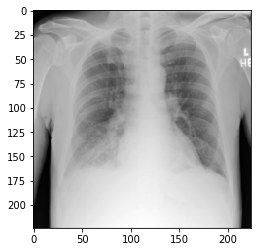

In [15]:
def join_str_array_to_labels(str_array,labels):
    return ','.join(['\n{}: {}'.format(
                                          labels[index_element], 
                                          str_array_element
                                        ) 
                for index_element, str_array_element in enumerate(str_array)])

#show how unbalanced dataset is
frequencies = np.sum(train_dataset_ex1.targets, axis = 0)/len(train_dataset_ex1)
text_frequencies = ['{:.2f}%'.format(frequency*100) for frequency in frequencies]                    
print('Percentage of positive examples for each class in the training set: ')
print(join_str_array_to_labels(text_frequencies, train_dataset_ex1.get_labels_name()))

#plot a few images
print('\n\nShowing one example from the dataset:')
plt.imshow(train_dataset_ex1[1][0].cpu().numpy()[0,:,:], cmap = 'gray')
print(join_str_array_to_labels(train_dataset_ex1[1][1],train_dataset_ex1.get_labels_name()))


#### Defining a scoring function for this exercise

In [16]:
from sklearn import metrics

#defining the function that calculates auc from a pair of arrays
def auroc(logits_predicted, target):
    series0, series1, _ = metrics.roc_curve(target, logits_predicted)
    return metrics.auc(series0, series1)

#defining the function that calculates the AUC score for exercise 1
# one of the inputs should be a model with which inference is made
# the model should have one array with 14 elements as output, and each output should be a score
# the highest this score is, the highest the probability of this class being present in the image
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_chestxray_binary_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        
        logits_predicted = np.zeros([0, 14])
        targets = np.zeros([0, 14])
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy()), axis = 0)
            targets = np.concatenate((targets, target.cpu().detach().numpy()), axis = 0)
        
    # returns a list of scores, one for each of the labels
    auc = [auroc(logits_predicted[:,i], targets[:,i]) for i in range(14)]
    # remove nan if any
    auc_cleaned = [x for x in auc if ~np.isnan(x)]
    
    return auc_cleaned

**Q 1.1 (22 points)**: Modify the resnet18 model provided in the torchvision package from PyTorch (https://pytorch.org/docs/stable/torchvision/models.html#id3) to output 14 binary classifiers, and train it on the ChestXray14 dataset. Justify your choice of loss function. Get an AUC of at least 0.725 on the validation set. You should average the AUC of the 14 classes to get a single AUC score. After getting the desired accuracy, test your best model on the test set, and specify for which anomaly/label your model got its best score and for which anomaly/label your model got its worst score. 

In [19]:
########################################################################################
# Reference from https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72
########################################################################################
print(train_dataset_ex1[1][0].cpu().numpy().shape)

# Get the device on which training is to be done
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models


########################################################################################
# Parameters
########################################################################################
epochs        = 3
batch_size    = 32
workers       = 3
lr_list       = np.array([0.01, 0.003, 0.001, 0.0003])
lr_decay_step_size = 5
lr_decay_gamma     = 0.1

########################################################################################
# Get the datasplits in place
########################################################################################
train_loader = torch.utils.data.DataLoader(train_dataset_ex1, shuffle = True, batch_size = batch_size, num_workers = workers)
val_loader   = torch.utils.data.DataLoader(val_dataset_ex1  , shuffle = True, batch_size = batch_size, num_workers = workers)
test_loader  = torch.utils.data.DataLoader(test_dataset_ex1 , shuffle = True, batch_size = batch_size, num_workers = workers)

(3, 224, 224)
cuda


In [113]:
for i in range(lr_list.shape[0]):
    learning_rate = lr_list[i]
    print("\nLearning rate: {:.4f}".format(learning_rate))
    
    
    ########################################################################################
    # Get the model
    ########################################################################################
    # pretrained=True will download a pretrained network for us
    model = models.resnet18(pretrained=True)

    # Freezing the convolutional layers
    for param in model.parameters():
      param.require_grad = False

    # Replacing the fully connected layers with a custom classifier
    # Multi-label data in use
    # https://stats.stackexchange.com/questions/207794/what-loss-function-for-multi-class-multi-label-classification-tasks-in-neural-n
    # So, we use a sigmoid function
    
    """
    # Adding 2 layers
    fc = nn.Sequential(
         nn.Linear(512, 460),
         nn.ReLU(),
         nn.Dropout(0.4),    
         nn.Linear(460,14),
         nn.Sigmoid()    
    )
    """
    # Adding 1 layer
    fc = nn.Sequential(nn.Linear(512,14), nn.Sigmoid())
    
    # Kaiming Initialization
    torch.nn.init.kaiming_normal_(fc[0].weight.data)

    model.fc = fc
    # print(model)
    

    ########################################################################################
    # Get the loss function
    ########################################################################################
    # Multi-label data in use. Cannot use softmax
    criterion = nn.BCELoss()
    
    
    ########################################################################################
    # Get the optimizer
    ########################################################################################
    # Over here we want to only update the parameters of the classifier
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)

    
    ########################################################################################
    # Start Training
    ########################################################################################
    # Transfer model and loss to the default device
    model     = model.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(epochs):

        # model for training
        model.train()
        train_losses = []

        for images, labels in train_loader:        
            # Transfer variables to the default device
            images = images.to(device)
            labels = labels.to(device)

            # Clear optimizer of previous values
            optimizer.zero_grad()

            # Forward pass
            output = model(images)

            # Calculate loss    
            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            train_losses.append(loss.item())      

        auc = get_score_model_chestxray_binary_model(model, val_loader)
        # Printing training loss after each epoch
        print("Epoch: {} Training Loss: {:.6f} Validation AUC: {:.3f}".format(epoch + 1, np.mean(train_losses), np.mean(auc)))
    


Learning rate: 0.0100
Epoch: 1 Training Loss: 0.211521 Validation AUC: 0.663
Epoch: 2 Training Loss: 0.190328 Validation AUC: 0.659
Epoch: 3 Training Loss: 0.184589 Validation AUC: 0.648

Learning rate: 0.0030
Epoch: 1 Training Loss: 0.191840 Validation AUC: 0.637
Epoch: 2 Training Loss: 0.170310 Validation AUC: 0.655
Epoch: 3 Training Loss: 0.165848 Validation AUC: 0.659

Learning rate: 0.0010
Epoch: 1 Training Loss: 0.193942 Validation AUC: 0.597
Epoch: 2 Training Loss: 0.174353 Validation AUC: 0.634
Epoch: 3 Training Loss: 0.166821 Validation AUC: 0.650

Learning rate: 0.0003
Epoch: 1 Training Loss: 0.208019 Validation AUC: 0.544
Epoch: 2 Training Loss: 0.181444 Validation AUC: 0.570
Epoch: 3 Training Loss: 0.176154 Validation AUC: 0.588


In [99]:
print("Not freezing any of the layers\n")
for i in range(lr_list.shape[0]):
    learning_rate = lr_list[i]
    print("\nLearning rate: {:.4f}".format(learning_rate))
    
    
    ########################################################################################
    # Get the model
    ########################################################################################
    # pretrained=True will download a pretrained network for us
    model = models.resnet18(pretrained=True)

    # Replacing the fully connected layers with a custom classifier
    # Multi-label data in use
    # https://stats.stackexchange.com/questions/207794/what-loss-function-for-multi-class-multi-label-classification-tasks-in-neural-n
    # So, we use a sigmoid function
    
    # Adding 1 layer
    fc = nn.Sequential(nn.Linear(512,14), nn.Sigmoid())

    # Kaiming Initialization
    torch.nn.init.kaiming_normal_(fc[0].weight.data)
    
    model.fc = fc
    # print(model)
    

    ########################################################################################
    # Get the loss function
    ########################################################################################
    # Multi-label data in use. Cannot use softmax
    criterion = nn.BCELoss()
    
    
    ########################################################################################
    # Get the optimizer
    ########################################################################################
    # Over here we want to update all the parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_gamma)
    
    ########################################################################################
    # Start Training
    ########################################################################################
    # Transfer model and loss to the default device
    model     = model.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(epochs):
        scheduler.step()
        
        # model for training
        model.train()
        train_losses = []

        for images, labels in train_loader:        
            # Transfer variables to the default device
            images = images.to(device)
            labels = labels.to(device)

            # Clear optimizer of previous values
            optimizer.zero_grad()

            # Forward pass
            output = model(images)

            # Calculate loss    
            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            train_losses.append(loss.item())      
        
        auc = get_score_model_chestxray_binary_model(model, val_loader)
        # Printing training loss after each epoch
        print("Epoch: {} Training Loss: {:.6f} Validation AUC: {:.3f}".format(epoch + 1, np.mean(train_losses), np.mean(auc)))
    

Not freezing any of the layers


Learning rate: 0.0100
Epoch: 1 Training Loss: 0.213122 Validation AUC: 0.562
Epoch: 2 Training Loss: 0.177821 Validation AUC: 0.596
Epoch: 3 Training Loss: 0.173711 Validation AUC: 0.619

Learning rate: 0.0030
Epoch: 1 Training Loss: 0.190753 Validation AUC: 0.555
Epoch: 2 Training Loss: 0.175636 Validation AUC: 0.534
Epoch: 3 Training Loss: 0.174790 Validation AUC: 0.588

Learning rate: 0.0010
Epoch: 1 Training Loss: 0.178667 Validation AUC: 0.688
Epoch: 2 Training Loss: 0.159856 Validation AUC: 0.700
Epoch: 3 Training Loss: 0.155221 Validation AUC: 0.719

Learning rate: 0.0003
Epoch: 1 Training Loss: 0.183329 Validation AUC: 0.708
Epoch: 2 Training Loss: 0.149131 Validation AUC: 0.719
Epoch: 3 Training Loss: 0.137126 Validation AUC: 0.729


# Choice of Loss function
This is a multi-label problem and therefore more than one label can be one for each example. We can not use the softmax loss since that will try to enforce exactly one of the labels to be one. We can use two loss functions -
<ol>
<li> nn.BCELoss () --- we use here and nn.Sigmoid to make outputs from the network in the range $[0,1]$ Reference
    https://pytorch.org/docs/stable/nn.html#bceloss
<li> nn.BCEWithLogitsLoss() --- alternative to our loss but then sigmoid is not needed
</ol>

# Conclusion
Different learning rates with the Adam optimizer with freezing the model and without freezing the model. The batch size is kept at 32 . The results are as follows

| Learning Rate | AUC Val (With freezing) | AUC Val (Without freezing) |
| ------------- |-------------------------| -------------------------- |
| 0.01    | 0.648 | 0.619 |
| 0.003   | 0.659 | 0.588 |
| 0.001   | 0.650 | 0.719 |
| 0.0003  | 0.588 | 0.729 |

We use the model with learning rate **0.0003** and **without freezing** any of the layers

In [100]:
auc = get_score_model_chestxray_binary_model(model, test_loader)
print(auc)
print("Test AUC: {:.3f}".format(np.mean(auc)))

[0.7870405196799799, 0.9135922680226479, 0.8441114639911941, 0.6986848173656377, 0.6758973112931761, 0.6193779940232164, 0.627417472172845, 0.8165454937201715, 0.7758524134978788, 0.8833564890487087, 0.75682167790794, 0.7509750548468351, 0.7217118456595017, 0.7754800238521169]
Test AUC: 0.760


# Test AUC
Test accuracy = **0.76**

The labels are ordered in the following manner -
<ol>
    <li>Atelectasis
    <li>Cardiomegaly
    <li>Effusion
    <li>Infiltration
    <li>Mass
    <li>Nodule
    <li>Pneumonia
    <li>Pneumothorax
    <li>Consolidation
    <li>Edema
    <li>Emphysema
    <li>Fibrosis
    <li>Pleural_Thickening
    <li>Hernia
</ol>

The best score is for label **'Cardiomegaly'** and the worst score is for label **'Nodule'**
<br>
<br>
<br>

**Q 1.2 (34 points)**: Build a model of your own design with a maximum of 500,000 parameters that reaches at least 0.67  AUC on the validation set when trained from scratch. You should average the AUC of the 14 classes to get a single AUC score. Besides getting a good score, you should also test several different architectures, methods and hyperparameters, and describe/analyze what worked well and what didn't.

In [28]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

########################################################################################
# Commonly Used Classes
########################################################################################    
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


# Code taken from
# https://discuss.pytorch.org/t/flatten-layer-of-pytorch-build-by-sequential-container/5983
# https://discuss.pytorch.org/t/converting-2d-to-1d-module/25796/3
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x): 
        return x.view(x.size(0), -1)
    
    
########################################################################################
# Parameters
########################################################################################
epochs     = 5
batch_size = 32
workers    = 4
learning_rate = 0.0003


########################################################################################
# Training function
########################################################################################
def train_model(model, criterion, optimizer, device, train_loader, val_loader, init=True):
    
    ########################################################################################
    # Initialize Weights
    ########################################################################################    
    if (init):
        # Initialize weights
        for m in model.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight.data)
    
        
    ########################################################################################
    # Start Training
    ########################################################################################
    # Transfer model and loss to the default device
    model     = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        
        
        # model for training
        model.train()
        train_losses = []

        for images, labels in train_loader:        
            # Transfer variables to the default device
            images = images.to(device)
            labels = labels.to(device)

            # Clear optimizer of previous values
            optimizer.zero_grad()

            # Forward pass
            output = model(images)

            # Calculate loss    
            loss = criterion(output, labels)
            loss.backward()

            optimizer.step()
            train_losses.append(loss.item())       

        auc = get_score_model_chestxray_binary_model(model, val_loader)
        
        # Printing training loss after each epoch
        print("Epoch: {} Training Loss: {:.6f} Validation AUC: {:.3f}".format(epoch + 1, np.mean(train_losses), np.mean(auc)))

    # Pass on test set
    #auc = get_score_model_chestxray_binary_model(model, test_loader)
    #print("TEST AUC: {:.3f}".format(np.mean(auc)))


########################################################################################
# Get the datasplits in place
########################################################################################
train_loader = torch.utils.data.DataLoader(train_dataset_ex1, shuffle = True, batch_size = batch_size, num_workers = workers)
val_loader   = torch.utils.data.DataLoader(val_dataset_ex1  , shuffle = True, batch_size = batch_size, num_workers = workers)
test_loader  = torch.utils.data.DataLoader(test_dataset_ex1 , shuffle = True, batch_size = batch_size, num_workers = workers)


########################################################################################
# Get the loss function
########################################################################################
# Multi-label data in use. Cannot use softmax
criterion = torch.nn.BCEWithLogitsLoss()


cuda


In [22]:
########################################################################################
# Model 1
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 1 , kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(1),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
Flatten(),
torch.nn.Linear(784, 256),
torch.nn.ReLU(),    
torch.nn.Linear(256, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]          18,464
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9            [-1, 1, 56, 56]             289
      BatchNorm2d-10            [-1, 1, 56, 56]               2
             ReLU-11            [-1, 1, 56, 56]               0
        MaxPool2d-12            [-1, 1, 28, 28]               0
          Flatten-13                  [-1, 784]               0
           Linear-14                  [

In [23]:
########################################################################################
# Model 2
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 1, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(1),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),    
Flatten(),
torch.nn.Linear(196, 256),
torch.nn.ReLU(),    
torch.nn.Linear(256, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]          18,464
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           9,248
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13            [-1, 1, 28, 28]             289
      BatchNorm2d-14            [-1, 1,

In [25]:
########################################################################################
# Model 3
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2), 
Flatten(),
torch.nn.Linear(1568, 256),
torch.nn.ReLU(),    
torch.nn.Linear(256, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]          18,464
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           9,248
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]           9,248
      BatchNorm2d-14           [-1, 32,

In [27]:
train_model(model, criterion, optimizer, device, train_loader, val_loader, init=False)

Epoch: 1 Training Loss: 0.159044 Validation AUC: 0.661
Epoch: 2 Training Loss: 0.156730 Validation AUC: 0.670
Epoch: 3 Training Loss: 0.153208 Validation AUC: 0.669
Epoch: 4 Training Loss: 0.149172 Validation AUC: 0.668
Epoch: 5 Training Loss: 0.145899 Validation AUC: 0.673


In [29]:
########################################################################################
# Model 4
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2), 
Flatten(),
torch.nn.Linear(3136, 128),
torch.nn.ReLU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           9,248
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           9,248
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
      BatchNorm2d-14           [-1, 64,

In [30]:
########################################################################################
# Model 5
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.ReLU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2), 
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(3136, 128),
torch.nn.ReLU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           9,248
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           9,248
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             ReLU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
      BatchNorm2d-14           [-1, 64,

In [31]:
########################################################################################
# Model 6
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2), 
Flatten(),
torch.nn.Linear(3136, 128),
torch.nn.ReLU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              SELU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           9,248
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              SELU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           9,248
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             SELU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
      BatchNorm2d-14           [-1, 64,

In [32]:
########################################################################################
# Model 7
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2), 
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(3136, 128),
torch.nn.ReLU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              SELU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           9,248
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              SELU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           9,248
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             SELU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
      BatchNorm2d-14           [-1, 64,

In [35]:
########################################################################################
# Model 8
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(12544, 128),
torch.nn.ReLU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              SELU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           9,248
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              SELU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 32, 56, 56]           9,248
      BatchNorm2d-10           [-1, 32, 56, 56]              64
             SELU-11           [-1, 32, 56, 56]               0
        MaxPool2d-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 28, 28]          18,496
      BatchNorm2d-14           [-1, 64,

# Too Many Parameters, Adding stride

In [43]:
########################################################################################
# Model 9
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1, stride=2),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(3136, 128),
torch.nn.SELU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SELU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,248
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              SELU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
             SELU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]          18,496
      BatchNorm2d-14           [-1, 64,

In [46]:
########################################################################################
# Model 10
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1, stride=2),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(6272, 64),
torch.nn.SELU(),    
torch.nn.Linear(64, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SELU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,248
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              SELU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
             SELU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
          Flatten-13                 [-1, 6272]               0
          Dropout-14                 [-

In [47]:
########################################################################################
# Model 11
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1, stride=2),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),    
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(3136, 128),
torch.nn.SELU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SELU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,248
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              SELU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
             SELU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 32, 14, 14]           9,248
      BatchNorm2d-14           [-1, 32,

In [49]:
########################################################################################
# Model 12
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1, stride=2),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(1568, 128),
torch.nn.SELU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SELU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,248
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              SELU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
             SELU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 32, 14, 14]           9,248
      BatchNorm2d-14           [-1, 32,

In [50]:
########################################################################################
# Model 13
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1, stride = 2),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
Flatten(),
nn.Dropout(p=0.5),
torch.nn.Linear(3136, 128),
torch.nn.SELU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SELU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,248
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              SELU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
             SELU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]          18,496
      BatchNorm2d-14           [-1, 64,

In [51]:
########################################################################################
# Model 14
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1, stride = 2),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(3136, 128),
torch.nn.SELU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SELU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,248
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              SELU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
             SELU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]          18,496
      BatchNorm2d-14           [-1, 64,

***
# Observations
## Number of [Conv Layers + Batch Norm + ReLU] blocks
| Number | Model | Accuracy |
| ---    | ---   | ---      |
|  4     | 10    | .657     |
|  **5** |  **9**| **.676** |
|  6     | 11    | .658     |


## Dropout
| p        | Model  | Accuracy |
| ---      | -----  | ---      |
| 0        | 10     | .657     |
| **0.25** |  **9** | **.676** |
| 0.5      | 13     |  .658    |

## Activation
| Activation | Model | Accuracy |
| ---        | ---   | ---      |
|  ReLU      |  5    | .670     |
|  **SeLU**  | **7** | **.676** |


## Stride in the first layer
| Stride| Model | Accuracy |
| ---   | ----- | ---      |
| 1     | 10    | .657     |
| **2** | **9** | **.676** |


## Filters in the fourth conv layer
| p     | Model | Accuracy |
| ---   | ----- | ---      |
| 32    | 12    | .659     |
| **64**| **9** | **.676** |

## Learning Rate
| p         | Model | Accuracy |
| ---       | ----- | ---      |
| 0.0001    | 14    | .655     |
| **0.0003**| **9** | **.676** |

The number of nodes in the fully connected layer (128) is limited by the parameter of the model. If we increase it beyond (say 256), the model exceeds the parameter limit threshold.

The reason for choosing filter size as 3 in convolutional layers is given in the paper Very deep convolutional networks for large-scale image recognition by Simoyan and Zisserman at https://arxiv.org/pdf/1409.1556.pdf

# Conclusions
<ul>
    <li> There is an optimal number of blocks for the model.
    <li> Increasing the dropout to a large value causes the model accuracies to drop since more links are now randomly dropped.
    <li> Activation function had slight improvement in the performance. This is because SELU has better convergence properties than ReLU. Refer Self Normalizing Neural Networks, NIPS at https://arxiv.org/pdf/1706.02515
    <li> Stride=2 also helped in better convergence of the model.
    <li> Less number of filters in the fourth block affect the AUC 
    <li> Choice of learning rate is also crucial.
</ul> 
We fix Model 9 as our final model. The number of parameters is ** 441,550** less than the limit of 500,000

***

In [52]:
########################################################################################
# Final Model
########################################################################################
model = nn.Sequential(
torch.nn.Conv2d(in_channels = 3 , out_channels = 32, kernel_size = 3, padding = 1, stride = 2),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(32),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
torch.nn.BatchNorm2d(64),
torch.nn.SELU(),
torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
Flatten(),
nn.Dropout(p=0.25),
torch.nn.Linear(3136, 128),
torch.nn.SELU(),    
torch.nn.Linear(128, 14)    
)

model.to(device)
summary(model,(3,224,224))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
train_model(model, criterion, optimizer, device, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SELU-3         [-1, 32, 112, 112]               0
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           9,248
       BatchNorm2d-6           [-1, 32, 56, 56]              64
              SELU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]           9,248
      BatchNorm2d-10           [-1, 32, 28, 28]              64
             SELU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]          18,496
      BatchNorm2d-14           [-1, 64,

In [53]:
auc = get_score_model_chestxray_binary_model(model, test_loader)
print("TEST AUC: {:.3f}".format(np.mean(auc)))

labels_data = ['Atelectasis', 'Cardiomegaly','Effusion',  'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
'Consolidation', 'Edema', 'Emphysema', 'Fibrosis','Pleural_Thickening', 'Hernia' ]

print("Best  AUC Score is for the class: {} ".format(labels_data[np.argmax(auc)]))
print("Worst AUC Score is for the class: {} ".format(labels_data[np.argmin(auc)]))

TEST AUC: 0.644
Best AUC Score is for the class  Edema
Worst AUC Score is for the class  Emphysema


# Exercise 2: RSNA Pneumonia Detection Challenge
**(44 points total)**

In this exercise we will be using a dataset from Kaggle. Kaggle is a website that hosts machine learning competitions and datasets, and is a great resource for finding interesting projects for practicing deep learning concepts. You will have to create a Kaggle account to access the dataset for this exercise. You will need to register for this Kaggle competition (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge), accept the terms, and get an API key for your account on Kaggle. To get this key, you should do:

- click on your image on the upper right corner of a Kaggle webpage
- click on "My Account"
- click on the button "Create New API Token"
- Save the key inside the json file somewhere.

Below you will be asked for this key, so that a script can connect to the Kaggle databases and download the files to your system. 

The dataset for this exercise is a dataset which has images labeled as having pneumonia or not and, for each image with pneumonia, bounding boxes are provided to know where the evidence for pneumonia is in the image. The original dataset is evaluated as an object detection task, by mean average precision of bounding boxes (more details here, if you are curious: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge#evaluation ). Some famous models predict bounding boxes directly (https://pjreddie.com/darknet/yolo/, for example). However, we are going to simplify the task and convert the ground truth bounding boxes to a grid of binary labels, train a model using these modified labels, and use the AUC metric to evaluate them. 

**Important:** Please download the file **image_names_kaggle_pneumonia.csv** provided with the assignment and put it in the same directory as this notebook. If you are using Google Colaboratory, use the python command ```files.upload()``` below to upload the file.

#### Getting the dataset and defining loading and processing  steps

In [101]:
# If you are using Google Colaboratory, use the next line to upload the image_names_kaggle_pneumonia.csv file
# else put it in the same folder as this notebook
if machine_being_used == 'colab':
    files.upload()

In [107]:
#getting Kaggle username for the API connection
print("Write your kaggle username:")
kaggle_username = getpass.getpass()

Write your kaggle username:
········


In [108]:
#getting Kaggle API key for the API connection
#check Exercise 2 for how to get this key
print("Write your kaggle key:")
kaggle_key = getpass.getpass()

Write your kaggle key:
········


In [110]:
if pneumonia_dataset_folder!='/scratch/tmp/deep_learning_datasets_ECE_6960_013/kaggle_pneumonia':
    #downloading the dataset
    os.environ['KAGGLE_USERNAME']=kaggle_username
    os.environ['KAGGLE_KEY']=kaggle_key
    os.makedirs(pneumonia_dataset_folder, exist_ok=True)
    !kaggle competitions download -c rsna-pneumonia-detection-challenge -p $pneumonia_dataset_folder

  0%|                                                | 0.00/583k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 583k/583k [00:00<00:00, 8.88MB/s]
  0%|                                                | 0.00/155k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 155k/155k [00:00<00:00, 34.0MB/s]
  0%|                                                | 0.00/661k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 661k/661k [00:00<00:00, 75.9MB/s]
 99%|███████████████████████████████████████▋| 374M/377M [00:04<00:00, 99.8MB/s]
100%|████████████████████████████████████████| 377M/377M [00:04<00:00, 91.4MB/s]
100%|█████████████████████████████████████▉| 3.28G/3.29G [01:09<00:00, 36.7MB/s]
100%|██████████████████████████████████████| 3.29G/3.29G [01:09<00:00, 50.8MB/s]
  0%|                                                | 0.00/55.0 [00:00<?, ?B/s]
100%|████████████████████████████████████████| 55.0/55.0 [00:00<00:00, 27.0kB/s]


In [114]:
if pneumonia_dataset_folder!='/scratch/tmp/deep_learning_datasets_ECE_6960_013/kaggle_pneumonia':
    #extracting the dataset
    c1 = pneumonia_dataset_folder+'/stage_2_train_images.zip'
    d1 = pneumonia_dataset_folder+'/stage_2_train_images'
    e1 = pneumonia_dataset_folder+'/stage_2_train_labels.csv.zip'

    !unzip -n $c1 -d $d1
    !unzip -n $e1 -d $pneumonia_dataset_folder

Archive:  ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images.zip
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a4a28a4f-9496-430c-8cc1-cff2b44ac359.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93a4df4f-bb28-4f02-9e1d-4fc147a93be5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ecf0161e-f058-4166-825e-4e1d5bf98d1e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/995876a0-f2ae-475b-b410-62fd0aff7f3c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f4113fee-b7a0-472c-8f68-24e999fbf73a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3d8ec01f-d488-4816-8fee-036b69b43246.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5fb17b91-e490-4f40-bc6b-79550

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3a9211e6-2e40-493c-90bc-f26067d5b0b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1d9dde4e-97cc-4163-a3d5-8b845ad60ded.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/386334b4-06db-4a66-a7f1-9d0a6d9f2cdb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b25f283e-c7d0-47b0-8daf-17e79407866a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b441b807-25e0-4c5d-a1c3-bbf000a38b19.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d1a4fe3-329f-4eea-a5b7-953d617a74fa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a33596ad-c382-4875-9c5a-5b30f3574549.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4da42c54-65cd-4c74-9a75-92a59562f2ca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9bfebbd8-d79d-4a61-9403-d33d3406fce7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/531f1e64-d6d8-4905-85d5-f6f10834d098.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a45992b1-aa71-495b-ba52-cbbda9f2d876.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/728a62fc-4310-4aca-9d68-72c8a829d69e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a74515e-f0db-43f7-93a5-51f0eb25b126.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c89b40b-7748-4209-bd78-27b4f374ec33.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca8b395d-7ca0-4dc4-8b56-ff519b4edb89.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/83bb5bb9-f084-4b12-8057-4c370e34490f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b272b6cd-34fa-48a6-96f5-d9123499c120.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b52244ed-5e8f-4ab6-a2b0-9bed4ab0ff2a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3999dbf4-b2a0-45b9-9ee6-5f62f5bd27c9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7f850728-0339-4a0b-896b-d53f1f3a20a3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/94ca0f60-8ed8-482d-9531-1b302693a232.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8e0a650f-5894-4a7f-b606-5c8edf968d0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3f4eae54-fb2b-4616-a32f-c42f7df570b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8860c7f9-d29d-4266-8a7b-33ae1d69a132.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5c70eeb8-e44a-437c-b958-fd6734728e49.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3adb1fb-2ae1-4a13-bee0-e1c649dd3ba1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5dbc1cfe-7caa-44e3-adb4-fb66694275c3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ae2c398-06c6-486c-bd97-b6f672d4771d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0baa6d29-66e3-40db-8aeb-5ebe80ddc8c8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f3e3d5b4-aa1c-43f5-9a7c-8e9193244910.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b3f0904-75c5-448b-aab9-c02a191da2cd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4794359b-25af-4ed9-859d-3a0bdf1e4868.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f1c3f262-dcfd-4904-b108-38d3479e3201.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a798670c-5fc9-44d3-95db-e46566590784.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3bef210-65b4-4bb1-bfa1-15ae213bfa8e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e40edc41-e99f-4900-ac4c-c9c0fc3c4c3a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32520edc-7730-4e75-a132-334f077a963b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9d061b3f-fa44-4ad9-b0a3-74a8e70fe9ab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ab9ec0e-4f92-40c5-80d8-10d1255ee538.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/191ebe0e-a14d-416c-88e4-4c4fb2647690.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9d80182c-2493-4208-9934-6442d7af9710.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/089df963-c3c7-499c-afd8-2b0f9224c442.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/43477aa6-e681-4e9d-b479-28f659570dce.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca70ad74-6cf5-4935-b0c6-05edbea4c65c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b2f2c4ee-cb07-48f7-a663-f6e04ee95c2d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/37e5967f-8b15-4cd0-965d-2550421734f1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9746c15f-94d1-4528-aff0-8ef02ccccef0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/70f79c35-d01f-4a9c-9fe1-87133892682a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1266cab0-e29f-47b9-87a2-17ed6658603c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce026848-ce9f-4d56-befc-fd4772133fe0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/586841d0-2dd5-4e3f-b5de-62da10a5b9b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e4f67b80-8cc3-4665-8eb4-09c7840b50ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/54a075e0-572a-426f-89dc-00b32a9c5637.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/39919c47-0f93-417f-96fb-1aa8a6d6e7ab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/41c5032e-0c2e-4d64-8f7e-f41e5fa881e7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/60d0ffdf-625d-4e39-a665-66b53d08fcf9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/78c9b88e-a134-4470-b161-22e4a698206c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9fd4b2e7-d443-417a-8436-b5921152ddd7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/72163e9a-c43f-456e-98a0-ba822f729a7f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d52870d-72f5-454a-98dd-07036177d74f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/48f1d1e6-2393-4fa2-ad4c-25e54f084808.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e3218c97-e918-4091-a957-d76548563f70.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e3fab001-eee9-4edc-b6be-9a60c912e2e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/63515470-5841-47cd-af05-d1169ac3a28a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa9cba0d-e2f9-47d9-b092-80458c0b939e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/685e12c9-ef16-4040-90f8-92649a23f8e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aaab7a82-b63a-46eb-9d03-b9fba96ca983.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8b12f467-8181-4ace-8eaf-3cc40c8ded81.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ceea22bd-493f-4d24-a49d-e13d70b3a01d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ed38283d-165f-481b-bbb3-5532450b82c1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb79a8a2-0c21-4386-b95f-3427da288202.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75327d2c-054e-4cdf-ba41-043a9fc78d60.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f639bed9-c6f3-4cf6-ac10-448b147d0e4f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0100515c-5204-4f31-98e0-f35e4b00004a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a6b8e55c-5e2a-4ee3-8731-479985e068f0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6cba26dc-51c2-4a3a-bbd7-3af8dd5bfd65.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9992709c-d506-4847-806d-0cb3964676ae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fe7d3f17-c8e8-47ea-82ef-55db9d285a96.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e45fa04c-2f15-461f-b9ad-20876087e7bd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0adec32a-b360-4396-866f-f1abaca047dc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e861f489-7b03-4408-9775-f6b0e2e74e47.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e62f8c0e-25d1-42cd-ade3-42dfbd51bc31.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b5c9f691-020c-4f70-bac8-25b067f0b357.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c99e0aac-6a3f-4773-9f16-a8a664cc3b58.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/974bf1e8-511a-47bb-bae5-c805b79a528a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b8397df9-1bd5-4961-b756-978ff4aed6cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c56b1137-e4d4-4139-94ba-b287ca43e318.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f39dcdae-cc69-479f-8616-964e3f293bd5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9f80d9c7-5ed4-40bf-8535-8289717d3264.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15bba9aa-1a49-4633-ac86-e8000f676d78.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/91f83ae1-ca25-4777-93d5-72c5995085dd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a0e64a6-ae10-4136-ad87-9015589e79b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c319790-02cd-44d7-bb91-8e758463ac82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6fc2afba-a9fa-4c41-bbe4-05723d7187c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d2fbd895-1c87-4a86-9867-38a94032c4f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/350e7ec1-9468-4056-9455-746888fcf817.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15fdc135-d31d-4eae-a348-ec27e1832615.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/accfe124-5be8-42e4-86fb-630ad1f11c73.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a776684b-ded0-4a2c-a094-24a7673c66ab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab2fd39b-2c9a-4fe7-852e-c1019ee3e602.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/395738ff-53d2-42e6-aa6d-a01e4a07f01f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ae62f3e-f20c-4991-8d4d-cb0862bda103.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ba1649bf-15b7-46ba-b841-7aeb71f9e4c6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f957afbf-fa78-47a0-942c-17b2f5262fc9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5de6b40e-b56a-4906-9878-c07eb7af498e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc66e9e2-e79a-41bc-b0ec-b67fba51ad1c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ae8181a-854b-413b-8574-8c7236fdb64b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/196830ed-7b6a-44dc-8ffd-d991e48614b3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7442200-deb2-4b6a-88dc-2a5e2180dedc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/389628be-67a0-4854-a44e-0c4e2df93b04.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bb59562b-cfe1-416f-89cd-f2e4e048d107.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ebdce693-283b-462c-825e-a182c6063a85.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16066352-b81b-4957-b7eb-974e66a54912.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6389053a-63ab-4bb7-b872-85af8d988c7d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/73412261-5aa3-415e-8978-7e3b3345edef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3220814c-9264-4036-8598-1974deeb2a6b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8cb08a13-17cf-4101-89c7-3ceebd0cad0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/852a3e14-dd80-4965-847c-913e49c53239.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fa25dcb3-b8ba-4b68-83b5-39acef565a97.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4865d15d-81e2-4ed3-a40b-b19001cea8b0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81308fa4-04b2-4b31-97fe-932b50258355.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d50a2bd-0e09-4675-9c89-198b6e8756f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6207d50-e8c0-4955-a8fb-e6d583576490.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c87e50e6-4ea6-4c58-99e9-de64408b8558.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1d0ba9aa-6e78-4642-8595-cdd07ffa7130.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e8293694-de0e-46bf-b062-a32647c42c6b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0f831256-0a69-4fe5-9719-1563d2b6b7b9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/981b23f3-37a1-4389-9634-1b6242194a45.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bdb69d36-f0f3-467e-8d3a-8db2ac1d1308.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75350e8a-00cc-4a69-9bfd-8dcb72de0e2f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c220d0b1-5b07-4e56-a428-ce977680d131.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/10f2cb81-ad90-4857-a2f7-18e7d8f66907.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3b9bcca1-0ca9-4e93-ba0c-0a6ae1342726.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6994fbce-49a6-4a03-9acb-bfb97be75106.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bb65756f-f78d-412a-b5e6-c7fe81c9eb4b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9d479721-da17-4800-a1a4-4da43d1a206d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f354ebaa-05b0-4a0c-955c-7d2222ae0772.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c9169895-7dc6-4d2d-9cef-9630969cef41.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3038262f-ca56-436a-bdfe-7a547026fcb0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d83439d1-089a-4d53-8113-ede4c79adac6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b1d5d7d3-774a-4894-9575-73a4c7163494.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9bd35dc1-295f-4029-a93a-f9d7f15a0d9f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ffa3e9f1-6af8-481f-8523-b476e67edf69.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e85ccc63-3449-4bb7-bd0f-2b1798460512.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce258cdf-531c-40f4-9a61-f79f3b59f652.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b37a7718-a08f-4952-894b-2d1aa600f817.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/06216b5c-c03f-4562-bfec-bec5235943d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1f99edfe-6ad8-4781-9f7a-cf6c3f3123ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5827367d-31c6-4527-9ccb-63676d7f230e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/31ea34d0-7ac3-4069-85ce-641bb524ec63.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/39d69ac2-14d7-4659-af55-125893812ad8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd50c07e-0b74-400f-8657-076e7841fb6b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3670fac-87af-4e1b-a1d4-3181427a60fc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32b35555-525c-41c4-8bbe-44ae86d3ab26.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/915023f7-c83f-4819-9982-7d5fd43296e0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/899a3c1f-3355-4092-88a6-67848ecc137d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4c712f9f-9bf7-4e8a-9a64-e418d8fbf176.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/527e3357-7ee9-4911-b2bf-ad076813b65c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b22a1ca8-6580-4618-99ae-fb2ecca1df83.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c348dad9-78cb-4a43-ad55-78352bc49902.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/818d8d1c-1f0b-4760-8d6b-9c4add3f8ef2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/297d1d92-8116-4bfa-970a-9bddf591f1c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9307d6a3-5b39-452c-94cb-42235e55c770.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93de6c91-8647-4e11-87f4-7aca8a7a67ea.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b2e3df58-d617-4bef-8a4d-ee9afba25281.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/db4601ab-e3a4-4f94-be20-65607e00aa6e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f96a6fe-81f4-4b69-a2f2-8477b9ea9772.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9904fe9-81b5-4574-9224-6258521799cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ad73a5d-2d72-416f-ac53-01f1bcc5598d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aabd5bd4-91e5-4760-b8ff-5d4e0d9ee960.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b62671fb-a758-401b-8c5f-c2b53dfdbd69.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6fcc74a3-2249-4f73-b635-b8032192fc26.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/46c4f908-9292-437f-af42-4031fca621f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/614af470-e19d-4013-baa2-eae7e2b0198a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9374a88a-dc86-4735-baf3-1f1ef0a1e1fe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/422d2b91-c81a-4fd3-bd66-058c608a8917.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dc04f15d-9a30-4295-9d65-0832a923f5b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a147108c-9b7c-4a55-b823-3c06e2a4f3b1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5aba31fa-81e4-48cd-ba50-f885c2af8ca9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16b3b4a2-5039-4977-ba35-73bf84fcc565.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/99fb4f16-8f58-4393-a53b-43b5b73c8936.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e7f41761-1491-46b3-b718-a09637f90682.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e047d647-ba4a-40cf-a44e-41b4a3982945.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ccd0c3d7-262d-4795-a90e-00d61f076316.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f2e2f263-4a74-4d95-b518-bc1138a87fd1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/072e0dbf-11d7-4c57-8161-10c8e7b2f0bf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/90cfaf6d-0247-4431-be9b-bca6c060e394.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/484e9226-9e02-42d1-8515-bad7cf553c86.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e00e85ed-86ba-4bcb-af7d-95c556644f8d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/469db06c-6eb2-4aae-92d5-8a88148562f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93f035f7-32f7-44f6-8d9a-3fe67b03fe10.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9e0e63dc-1db2-4090-bcda-17b0ede45e4c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6f374f70-839b-40ab-b07a-dab87faa90e3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ef52df5-6e16-4448-9eab-9db6dba9bc01.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e0e6d81f-d19c-4e66-99a5-ebc202d727ce.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fac5712f-07a4-4600-b015-5bea1db2dfc0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6dd1e370-878f-4558-a5eb-6c248a5851cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4cd08263-ec22-4694-b9b0-a5c43c1813de.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca2d2b1b-4dc9-4110-85b2-024816a867b2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b94c8f7-7f99-4499-bb56-9930bf999e7c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71963cf6-6089-4a04-93c0-cdea6d3d33d4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/763adcfd-4ebf-4d3b-91bd-a7813dc4bb96.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/67222b15-7569-4c2d-b214-f3f613f4549b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7e64cb1a-ad85-4993-8770-f9ad195c02e8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0a6a5956-58cf-4f17-9e39-7e0d17310f67.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8b1976a-d5f8-4abc-92f8-f7ba208f364a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5f2bdba8-0539-43a9-b6ae-414a14fb444a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cdcbecda-ad13-4aa2-a0af-4e32e72855e1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/68c13574-a0dc-49e3-8004-923f0b2d278f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be53e067-4804-4ffa-9fb7-d7855ad3bf62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c6a315cc-23b1-4e2d-81f2-a07aef306f47.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa542085-6557-457e-b897-43591ce22108.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ef19e875-bf38-4da9-b3e9-21182d3de655.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/97c66ba6-dd63-4fc9-bb0c-3860a487762e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/76642e47-de05-48fc-a58f-bce9dc902912.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb63ea5a-86c0-4deb-b832-da7772d2a758.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/37f941a9-f736-4100-a771-517c9449da9f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3141838c-603b-47ea-8591-80a7e7c5bf12.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1a4326c3-303c-4140-8747-ae962f87a981.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/549200e0-f78f-403b-b67f-9b7e3ea927a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b2057bc-4c6d-4c90-8975-94c02392e460.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5dcd6fb0-b6a5-47b4-bfcf-d6e5bbfea166.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab6d8833-6583-43d2-8220-471ace40b569.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2f200e3f-8e4c-4675-948c-8226cd65163a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/40b2c95d-4ee7-4b81-abc9-2c5f97e5442c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e56ccd69-f456-4b20-8b39-d369c3b0164a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3fc13fa7-0981-4dae-8d4d-ff8769f98d28.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9c6cda5f-1ee0-4048-ad4f-815739b9d5ab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c99f7045-ef30-45b7-8874-0ab13bf84f94.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/835a9ff6-3844-49b4-b016-a8b337fa5b77.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c6527a62-0c6d-428f-8242-9acab8f3365e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/714c666b-bbdf-4cc6-bc9a-ee5566814c8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ff87b50b-d50f-4e39-82bb-325d51927ff5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a961ef19-ab98-4495-868c-cd268ef256f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6c34c206-a046-456b-b46c-345e4dfca403.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3e270660-ae56-4cb7-885b-3c9ba8b0f55b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0c1808e9-0af5-464b-8ce2-0518795a1272.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bb6c3018-2141-4e13-a2a9-59b479c5abff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e3dc00b7-5675-4ebf-88ac-42a60e2ed893.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1721fcab-c6fb-4688-a1b9-bb3677213085.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/45072f01-e58d-420f-8db4-5821f711243f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ef2fe10c-f65b-47de-9320-7e074a8df297.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2c5e84f-cd76-4da0-9208-ee04cc5fc918.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eef92899-5dc5-4f31-8807-2391f0f88588.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7f7fa43f-9e23-4cb2-97a2-d12ec6eb08b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ee52c757-3e8e-4e65-9818-52ad4c00622a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/86f0e1b5-1817-47da-af5e-d885dfc40424.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34c12ed5-c4c2-43d8-955d-3694eaade548.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c58f16d6-4b52-4353-ad67-d32f404de505.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8df7f03-eaee-4d17-a898-1fdc18b73c80.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8826526-a050-43c3-bcd1-02667c3c0f8c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/40a9d9ea-1651-4c33-9603-bba78fbc4052.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d22e3d9f-99a9-4537-a0ff-fc3c1f349ee2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e4ccb223-a809-44d6-a56a-b3c1031c802a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dfb6002d-69dc-4f78-b66b-906a01260b28.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a0b40a4b-c7a5-403b-8b42-7664621183c6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d3cf99c7-e7d7-456e-9e34-0312876db0d4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b7eaf33-4282-46fc-8488-b6ef8414fe21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6c5b9330-09d6-4181-ba38-afcbbc00dc3b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6230438-f63c-49c9-863c-b101b6e41de6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9d2c812a-8537-454f-84e2-be8ebe51b23d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/08542d41-e606-41df-b08c-9527b531f13f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71a7ea29-d36f-4d9d-adaa-505c4618da0a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c81f5117-7514-46a5-9a45-a9a9d2e27f5e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eef6b62e-1b3f-4729-9555-9b86a49f7053.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/47335c95-e088-4cd8-9dee-60216fd8e185.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0d8ca6ee-0595-45aa-bedb-1087dee15f23.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d57ecb68-cbf1-46cf-993e-a3763d1917da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e3b52ea4-7bc0-4fbe-a5d1-5594ef83abcd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/94305323-9811-4d8c-969a-7432981a7cea.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bd958495-ad3b-4677-8bee-25125c1dbfc9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e0d205ec-9cff-4141-b593-eec5c0b5da21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3cfaf293-a1a0-4130-b994-ad3df8a4008c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5823bee8-1a8d-42fa-9364-af32732f19a5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fbbe59b1-39aa-45f2-adf8-42fba9f99c6c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/797862ed-42ca-4265-ad43-b2d04361700e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8263fd36-1344-4daa-8783-35c639ea5a9c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/084d42b9-0a43-490d-9a8d-e4d7545c44f5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b433c27-746c-4968-b958-397f1e81e36c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/35186ee1-33af-42cb-bfb7-e365ba943fcb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5ed1471a-5bed-43ca-948f-1c06b0b6de5e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc7be234-c885-43ce-9c06-96be6f001c63.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cc3b2a5d-7ff8-46ae-a718-5d4d12451087.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0e2abdaa-d654-4824-abaa-9d6fe5b67a95.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/52a85d13-7aee-4236-a9a5-16d9a58ad4b5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f12d5151-4168-4bce-a9cf-c9eb427a1743.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b51868c2-4a70-4886-bf3a-8d352c3c4249.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0909a8b0-09e7-4a78-9bfb-417a61c6723c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d86b7b7f-27e3-4b54-b310-4a2821452529.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fe267737-99e1-42b0-ac7f-ffb6f235037a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3d46edf3-15a7-4f6b-a89c-bc11949e2550.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d631dce2-124b-4ba4-8acd-26979315d435.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5c2cfbf0-c6e3-41e8-8223-5ced66f5b514.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa642eda-547a-4bb8-9376-c7d2282c3e45.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/091ab452-0ea2-4f1b-b853-20b0031f1f99.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ebf1caa2-d674-4754-a1d5-89d321f28bdf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b3ff1c40-552b-44f9-9cc9-4362905f5eef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be90708f-2e42-427c-b532-5501a4ab1a25.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/414e4a00-bec4-4552-92d3-7e710b367869.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d91b519f-9216-4ff9-9e2a-3356bfe4e391.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c1718678-44af-407f-829a-fc65bc854094.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d870e46f-6a1b-4697-acaf-123f7da43090.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4fd01523-eaf3-4003-aae2-92ed7f7fac45.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ed87a3f-31d6-4a1e-82d9-01bdb6de0c49.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5ef06067-7884-4079-80ef-24cfe392e939.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8030afb0-b23e-4d19-b127-63f37e781ccb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d316817a-0747-4dfb-be81-fbf857439d42.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/49f8b627-9a06-4606-af75-a12efa65daf0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/92c10f10-30ce-4da4-8c80-0610a0647d07.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ff2b35b-2eaf-4fc2-b2e7-02031c748910.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b53bf210-ecc9-4f18-a42f-dfcb87fe1c24.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0582f503-a451-448f-87a5-a67589c5f7c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ac251548-5770-476a-8987-c928980312c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44c69cd0-67dc-4ea9-80b8-f77e61c673c4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6d898f0-7f9d-4178-b7cd-49eb2b33acf1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/31ad19e6-fe6d-40da-b2cc-a0dc5554d79e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c97ea3d7-862f-481d-a996-66acdfe38c0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ad797c06-afde-425e-b0a5-0d4b5d0f2af8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1eac099e-4467-42e1-af73-aac4feebe439.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b5f76d7-532b-44a5-8492-c0863a682f41.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0404639a-94b5-40c8-af85-8b0c6a972b01.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b793c936-c845-48c1-aa19-0f6843f2c66f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ad897723-3ee3-4652-b5a8-30605ded589e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6f439221-5c8e-4b75-a443-0cccc10a6bb2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ff61c3e8-c3a2-4b06-9974-9adf7953088a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/51d98c1e-43ac-41c6-829f-9c06a63391bb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bfb48b34-fe9a-4f31-bb5a-27ffe55a49fb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a9be2ad9-4a05-44bd-b5eb-a0938bc06363.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f78584ca-15f7-45e6-abb5-a2493fb9e05a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0084f80-ab8a-4c87-b6f0-ead404d29f28.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/595786d9-b679-4722-90a8-bad34a40c350.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8b521f75-17c4-4a96-a8b5-929c87e10561.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b3e4cf6-f37e-4e95-a6c8-3901352dbd15.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e7fabcf3-9ef4-4114-a868-cc2b8839b291.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3e2f4083-d432-446c-8418-e8c46801d453.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c04866bb-85d2-4186-8c48-3ce46dcfa80c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ad49beb0-b610-4b07-adf1-60b4a6413159.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/85d9875a-9fac-4422-a92b-08a593461a51.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f2ed2022-f1e9-499f-b1a2-549d4090c9e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ac166a48-f6e6-4236-8a92-c41b1e1ed87d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4bf439fc-d575-4f80-9ec3-35c38d330454.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8bca4dca-cff5-4d7b-bcd7-e303c59c3c6a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/37731818-2afa-4a22-bd18-db49152ae9b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ed86aa75-d0aa-4315-a4f1-5333e280f58c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0fa7872-9743-4a81-b75e-4d8973e064b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1649b78a-cc96-42da-b826-61f0ba2f7907.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb7caab5-e71b-44b0-b395-2074ae1c161f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c5a8e91a-2d40-4355-91af-73abf5f0fdf1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e9c0814c-2d66-4265-a7f9-bd595a613ba6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ce814aa-8366-4707-b17d-a2ecc503c4a8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5ea661b2-5e91-4d3d-9b17-0efb862434b0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e9ba3d1-a0ff-4847-a865-5c649f319aa2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f31efbad-096e-4f84-988a-7448cd9cd27b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5e88a086-2f27-461f-baf3-4b36976d6687.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2fc3d22-252a-4e95-bcf2-76c56a95ce39.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e48e74bf-9508-4bee-932e-dad4ab803360.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/da3a5812-5bd1-4a2c-9cd5-93ea1566b49e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7d1b94bf-9fb6-4191-bf69-09549b4a3b96.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8974f28-2cae-4cc7-bec8-969bc27e7792.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/96bbd7f9-90cb-48fb-8338-0051807aeb1f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e5a478b2-b843-4e25-b35f-2a4ce3f08c0c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/45e92e87-9e8e-4783-ba97-c032c17864da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7131b83-ef4c-4a0a-b1a2-d09c163bda48.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/33aea267-1950-4677-b4b0-fcf47f5669e1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88510d89-5d17-4e12-8e60-77721bb40966.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f1a46a26-a9c1-4173-9be2-12776029da04.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/46f37e46-e4cd-4677-875b-1f1b28cfc70d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9788fca-99e4-4e5d-9c27-d75e4ddf7745.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f248f5a2-490d-4711-9ae7-6c9b14beab2e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/56899133-2a10-471e-93b6-0ac3588aed4d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8adad269-d24c-4a1f-bc9a-e923da4dfc1e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e46a2dc2-a741-4ab5-afb0-fabdbffe1ec4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b35f52b3-12fc-4d72-a2e8-883d27d1303a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b2651591-53ae-450f-ae37-2220cf6108e7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a60f5267-3b08-4a46-9141-7a1150d541ad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b6532f98-e875-4a51-a39f-b8e273e4bb10.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0a796f83-f908-4b83-9252-e513d107be2e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9145790-db17-4006-9fc0-5e90b9347d2c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3cd75bf2-6942-4068-926d-6eadd421e303.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ce28c6e-0682-4e05-88d4-c73ad11288ec.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/33f3c9d7-b9ff-45a2-bb59-c6e9d5cf1454.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/21cbfa1b-6faa-4356-b1eb-a180d7d9b4ac.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/94540ae0-7374-4d79-a12b-7714902aff27.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/722816d0-3d58-4fbc-8e0f-a2ef699efbc6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/59ffc415-e14b-47b2-86f1-07e41fee2846.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc60a393-9f5b-4a49-8e93-9d5346f61f5c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b6f979aa-64e3-4211-a69d-fbe8151f6ac4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e55139e5-c0a3-4000-b8a5-9757e94e9978.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8875ae84-1ae7-4d7b-b455-4a3d56949535.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7bbab668-d46d-4aac-b7dd-02b03717a403.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/619c0082-09a6-4af4-8dc4-d6e69f42c682.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/73f2773c-bb6c-4965-9fe2-5f1bfcceaf68.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/37b5164c-0d4e-4292-8300-cea9078d8474.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c1f9926f-975c-402d-976c-ee9a12fa30f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e5ce21b-5506-4248-a729-22be4545874e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b406e391-9f28-4f26-a71f-285d5e3f488c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e50809fa-c887-47ac-badd-4abc077c7def.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/445e328a-084f-47a8-909a-f8bd1585b50b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1709e1fe-b49b-4120-b00a-e814a8bf7417.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/68ab6cf6-eadd-464d-8fce-79269306ecf2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bf9fab27-8eae-43b8-9a7d-5b59ef1355ce.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d96f68ff-15c8-4e7b-b943-729053f1ce16.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fdc740ef-4924-4806-9241-5e5685b251ed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/388cc388-c2aa-4bfe-8a63-4565c626d951.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/11e431ff-c6b8-45f1-9635-a055fbc90111.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dc8880f7-83f3-423d-bb9d-00902e4d9edd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e73017c-4e3a-499b-a597-4a797bb179de.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16d4d825-3334-424d-9bfe-0e6fb28c678a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6327bbe9-a523-4204-b542-028c366d9f11.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4c8a9e75-56b1-4d39-8b7d-fa84bd867ab5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3f9c00a1-c694-43fe-ad8d-4a67174bd0b3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/921825c6-38dd-4f88-a872-0d2eb681b0f4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b7218524-8137-4450-90af-b14206f5446f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/813f2bf4-82b9-4b67-acdd-84aeb03a1149.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/04c08d05-e5f7-4de3-b0b3-d39b3bb9d113.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0c46d62b-fd38-4445-9776-3963704c838b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f263d63e-1715-4bd8-af5e-fa4e824fa55b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/faeba3cd-ebb5-4110-93eb-03ca0dd51d5e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8266653e-4df2-4e84-aa7a-a96e7d29fe3e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/efd664f2-0666-4422-9408-3ea22c3e2e34.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ae01a62f-cbca-4f9d-bf40-2962929e5e0e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c65ee16b-d1a6-444e-a0d3-c81a498579d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c485ba23-a466-4d67-b73a-3c1298260718.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f070577b-8f5d-44b1-8cc5-f4c5d64a0476.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/928788e7-4a07-4a35-8fe0-934b20ceae6a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66572a9d-0907-494b-8fe5-3d3771ab9455.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/69b99b7a-439a-4813-97c9-58b48f7ff969.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e9f38ad5-dea1-4568-9abc-056143ae572b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d125836c-de5f-411b-a76d-4d2ec44ad9e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/52debd65-65c9-4a26-bbfd-eac603f41e17.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8a05cd0b-40b2-417f-9649-4cd06ecadecf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/58dc9082-98e8-49fb-b514-9d3549f1d1ed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d21e646f-36b8-436f-a75e-486b2329c49a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/557ab975-0426-4746-a88f-872ef5675134.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/43db9133-c2d9-42a9-bf91-2ea2bc256fbb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4d839a29-e065-431c-8cdc-9277432c966f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/99c62f0e-1e22-4bb5-961a-9bfb44c8a512.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/980cb5b1-e014-4d25-9fbb-ee5b495f58d4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a74334a7-a51b-47da-9ab7-86f517007e03.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b1c85b0-7acb-4d9c-b4c0-622d0025a088.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5340047d-295c-4b89-aabf-03889f4acb42.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3cb7ea27-e85c-45a9-a5d6-185b9ec18b17.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9bfc09c7-b267-4ffa-8670-969c86e6d84f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7d90260-5815-4af3-b1cd-7a90bf2fa101.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f8119c58-ee61-473b-935f-d7b80004430a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c71f8271-7061-421f-bbe9-e3ec92cb32a8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e88a5ffb-0c53-4d5f-9a3e-a9be06b2a7c0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/82ee396c-e42f-4483-80a7-34b510ba1b2c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8013ccfb-cc6b-4073-9344-2ac59753e04b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9dd4b75a-b61f-478e-ac67-3cfa6a4edbad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b053417c-836f-4f6f-9224-f9dc286ee6d0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9a60bd0f-4a87-4fed-923a-7fa8ab4d9000.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/710f5df1-dab1-4e25-8c25-b5a642424c1b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3e80e9c7-8f9a-4da5-b084-6f3d364d6010.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ae49a25b-557c-410b-a598-771d3e1a3f27.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e078ef48-46b0-465f-b01e-b9e97a8381ee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8cd0b312-ea6b-43c6-b637-ccba125ee5cd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a5b8ae16-8370-42a3-bef6-ba33af00b877.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fcd516a9-18ed-489d-a9a6-d1302b0ba040.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7383aa2-853a-42c8-aa78-b73bab6b511e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/43970f8c-5b6a-4225-963b-ed5dbeb38d19.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f23907b3-9638-4986-b471-b4f2873f6504.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fbac067a-b92f-4438-bf84-260360d534ac.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf398c87-70a2-40f9-aad1-12e30736b888.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c87428e8-09b6-4b65-8a28-137c147f3e80.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/55b4a70a-1818-4c64-bcd5-53b17b76496e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7b318d5-f8f7-4906-a207-6d13ce34217b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/540e62ff-190e-44b6-90ad-9cd2ec2cdb0f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/01adfd2f-7bc7-4cef-ab68-a0992752b620.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aebb193e-64ef-4368-b139-c0ee72709945.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/47755c72-c865-44a8-846e-5b69e0142638.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/646f33bd-0722-49eb-87d6-96179afbc92a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8bccfbc7-b7c4-41f6-9e43-53dc569dd2e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4dff11f9-1935-4ba4-833a-9692c640bd7d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b4ae5b1d-2d5e-422a-9388-36f4645d21c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9a37154f-8be8-47c0-ad75-4db73f30930d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f0ba0019-718f-4677-a723-05c27dba2f3e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/45415872-fc2a-43ba-869d-5131c57622f1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3f7c26fc-eff6-49b3-bd18-b3b58dfdf161.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7cb8a47f-8230-4f10-bfca-075cb339ab86.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a552a6e-0b8e-4825-88ab-72c1da5ed42b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b1ee3437-1d7a-4a85-a406-f2f7bca754dc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7a316a31-7375-4832-b4ac-061dc1af232a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81dca618-553d-4299-a4a0-e64f764bf69f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fe518d2d-28a1-42eb-918d-16f7bc6039bb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dd1f5ae2-8893-4e03-af10-d1ac0494eb73.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/440c1b34-25ea-4f02-a4c5-2b6424e6557e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7bf0f0cb-90ff-4e61-ab52-e05053689108.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d99694aa-7079-4798-bd19-9e663b5d9543.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d6ee99a-1458-417a-a97f-fa58e67f0605.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fa8b38fd-e95d-4484-96cd-01def7c6dd98.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2027ec6-9e87-4384-a8c3-f54bb7d00d81.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d4d78866-6c1a-4632-879b-191b01045cc1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ef503977-63a8-4fcf-9019-78e8e70511f3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca51e6f6-c3ed-41ab-bf85-6efd3aac966c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f1138254-ddb3-4c4f-935b-92c4eebe14fb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8c68ceb7-2d5c-450e-bfda-052b862de063.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/73e62967-5fef-4dfa-9a3a-1e045a81f593.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/78ec6068-25e2-4965-a016-19efab9e9280.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8b95e8f1-a796-4dca-8f09-137869c91eb7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/502edb24-9dce-4a26-ad3b-4efa7eaa2a9e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15d957da-6c21-4f18-a8e7-a26fe4d29f58.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc79b29b-3030-4c00-aa30-5924f3c1026f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c3f7a08-29c4-4773-8ae1-e32418e018c9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/78c36a61-954f-4730-8b76-c66e5db4d464.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/90ec4fa0-4405-4fcd-926c-6323158fded2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9f377ef1-a9b4-409c-8e6f-94199ac19a75.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d4d10646-e095-4cde-9f9a-b0d4b4cf6d5c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7e90dcbb-3761-4488-899e-fa88e1bd00a5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0fee7f3-1d7e-436f-b294-316c06ab88f4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/49ee0424-95fb-45a6-bc76-f24d06db7ac5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b7709a9-cc53-42f1-ae80-228d31aff18a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f79bfdae-858b-404b-b25f-7acf681804da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc422dd3-596e-40e6-93b5-0f08fc6fa720.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7704504e-99a8-4213-b54c-9fb0879a339a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fe55d2e8-b8a5-4372-825e-ae4d81632e3d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9ece63e-a771-49a6-bd6f-a78feb367f34.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ba6ce5ed-7b5d-4104-9050-967df0dbd928.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/98447918-1170-4213-abaf-437efe240700.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/06b2f933-3ea2-4477-ac27-18f732d1f4e1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c77978d-d287-470c-9bef-b47836b7fa55.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dd636913-f8cf-4463-9191-b9014b5d1055.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5f8240fa-94df-47ed-8f8c-3eca1f92bc28.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/46cfe8ef-549c-4b26-95b9-3a0b2cea22d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f164c961-b6bd-4888-9b62-96df4a4361d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6c2fb392-4762-4aa6-9878-ac6fc82ff6a1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4603cccb-c783-44e6-8c38-df7210e1c85a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b1a6d45-e0e8-40da-8327-149461e79b8f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dedc62fb-20d8-4609-a5da-96bb6e27d5c0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9884def-b31a-4861-9eea-27f97bffeba2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2c1a4681-22eb-441b-9fe4-f3ef4dcc918b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/27feebaa-f4dc-4c68-9348-f0ff35134e43.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75508098-4cca-4037-90e5-0ae2ba6b4db9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/715bae63-44c0-423d-ab97-c6b58bd3287e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c4a2f14a-82dc-49fc-aa03-037bf6b99c6c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa035292-3f9b-4800-89f4-b1e9722c7c67.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/55bf30ae-819a-4d20-816c-d45615df0688.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2458fdf6-7200-425e-b072-0a4e08afcdca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/819825bd-1bb0-4eef-9299-e2ae28531c2f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32659f33-5e60-4db1-9696-657e54b769c8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a55ef250-42dc-43f7-b9f4-ae0da1dd62ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c39e60a0-f1dc-4a16-aae8-c6df8362a877.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7a8dd22c-7af7-428c-a043-578390fc6fa1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/381d7ec4-d880-4594-b303-056c8608a44f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d61bf24-7968-416f-af06-153541cb6e92.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/01a7353d-25bb-4ff8-916b-f50dd541dccf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/49a0c701-8e14-4651-9184-91870fdcd073.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/55bf665e-e53b-4320-baa7-4fdaa54447db.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bb1548e0-0d9f-42de-bd43-627c90259a8b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/85eebfe1-8819-408e-a5a0-6df1d4165e9a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b16bcbb6-570b-450b-a9e5-b1e3663205bb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8c2b6caa-41cd-45c0-95f0-de71c3e9186b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3827ecef-1d37-421e-ad89-2738010bccd1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/772466fc-4641-4296-bd8e-e48246540f5b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9fc44c1b-3542-4d4d-ae7b-cbb750a90999.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15b28846-3e6f-40d1-b497-cea5abed3766.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c89dddd6-a7c1-48a4-80e1-891670389b97.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/41869b8c-c1be-4a54-ad93-5a042e1018bc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4217397c-f5d1-4890-8d71-5c6eebf8340e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f150f95d-ae2f-4fc9-9207-4a6e26cd21a5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cdce5e2f-8de7-4d85-a350-26e9826f57e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0e245423-3ccd-41ee-84a5-b9f0a20dba71.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/677b6db0-31ab-47d4-bb96-5cd301c8f6ac.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bcfbbdcc-f648-4e72-931b-1747f502eb35.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ce514cc-ff16-4d36-98c4-8b78f996e81c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f73e8ce7-ed4c-42b2-9110-700e3c5f9887.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a1d85c52-1941-4d29-a05d-b0ed3d0805c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/582eabe9-86dd-45ea-958c-f53068114db2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e51ffc7e-928e-40e4-b06f-7c2507bce1d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/caf813f9-efc0-4a61-93b7-cd9e50bbc595.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bf5b8e51-9dfe-4248-b38e-45a9f598b0c8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bd8f8b0b-a89b-42f5-b92c-c0a152c6c1f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a5eeedb-f8f8-4c18-88ce-e392a91270f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b7e0ce7-a08c-4d69-bdf1-7a807ce434b4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aee56331-e752-442c-ac2d-0b82fe156d67.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f40574cd-4fc5-43a7-a2e8-8bf66093c80a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a2960536-841e-4c2b-8bc4-a3d6f460dd9c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ebe886a5-3488-4198-bbd8-33c50b4a15f9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ddd47a8c-0f59-4024-a9c4-91fedbd42867.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b54c5581-bb40-4c19-9d5a-3be944ef8132.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5e30641a-d90c-47f8-a798-76155850846b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3ac49fd1-c580-48f1-8e3c-6a50d3447ba7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88323555-57e6-4101-802b-d96595967ffd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/319a8d01-4507-4882-a8fd-f667073fc847.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/86c27916-8e16-46f3-bfc3-41ad645dd672.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f4caca65-760a-4726-a622-38ddc68e55e9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16164a04-5f08-4637-8226-e34d2fbdd762.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b75aac14-6da7-4b40-9e68-674f50c98a3a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f05d72e2-dfe0-4a1a-8c04-b34874b218d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ffb0a415-cd40-4c33-b806-cf533505f89e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0c15e437-7eea-4ed1-b1d8-124f79cc1893.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a8495b35-2133-4127-85ca-6efa8db7a81a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0edcf2dd-71fe-4108-9303-24d51b4faf72.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8615dbf0-431a-4b5a-abd7-6811fb272ef6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c208db34-d893-4a2b-9cf2-45490f5b78a3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/83ee7f2c-8974-4201-8fab-87cde6f89038.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f10b2c7a-ceb3-4370-8761-6f3da9d08746.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3914966-dba0-4178-8efa-20f3dbb5e75e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88ff2af0-a757-4bc4-b04b-031619dac4e3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/182f6df4-daf7-43d5-86c3-9bb53846dafd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/871ebe50-8492-496d-a49d-510be81eb07a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0cea4fac-4e84-4857-ac38-f2eb0dacfffc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f0d89c6a-e677-42d9-8a56-ef6227a771bf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f74e692e-1ccd-4f5e-bc19-482325025a41.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/67f04d37-ce6b-4900-95c3-dc622772365c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81cc48ed-0b64-436e-809e-47c3fc35006f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a64c194-635e-4ab0-aefa-aeb2be0aac53.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/74b43a7f-0306-49fb-929a-2d520eb8e58d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/891a1dcd-ea73-48f4-9508-e3e52ba3c5fc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6477a41c-821b-4c21-88cf-677f73d8bcd4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/50485e1e-5074-4b31-bc8e-443cf0ebca2c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/587303af-3f6e-4e07-8c5b-6d800e9cce52.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1876d119-b100-4269-bcf6-766203b1ed29.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dd922253-21a0-40df-8e03-febb6dc20d2e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15da61c5-38ac-4490-a468-91e67f295825.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6800dc93-099c-48b3-8554-e934626de338.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b8020472-9c2d-44ce-a09b-f5795b95f230.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/27fdc9c2-5544-4142-92ac-11a1264d4fb8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15d3c938-6ccd-4abe-a49d-5fb469a1ea14.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f7a1de8c-7802-4af3-98c4-4dfb088b986d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e00c1966-e9d7-4845-bd26-1865226786df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/87099f8f-b28c-45e4-991f-c764206940d8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3fafd8bd-2ec9-4d78-be49-52b5f74ff088.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/12b4c5bc-48cb-4010-9b2e-eeb8b0d5cc8e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5799b0e6-9c17-45b0-9d19-447dbe61b184.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/84a5acd8-1e79-4f6b-8cf4-66496fb34314.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/457e1b0b-89f5-4f7f-b752-fd8420414b97.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/22956af6-6152-4458-a39d-a45706b8a96c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2f801269-70c2-4987-a479-e25b91767ee1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4b394bf3-9620-45c6-81e6-0b7cb44f610a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/43640d8d-6d89-4bd8-b51a-af9f4565d128.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a6db20b-bb3a-4c61-8c67-bc5ce432c50b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/860da4ca-ffdd-41fe-b3a3-511ee42a61db.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d6406a7b-d4ce-4495-ac63-ccde4b062fa7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b77ea8c-45cb-422e-b0b2-d2c14d58af25.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/38f23b8d-d8ef-4348-978b-d8350aae9c96.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9e90750a-8dfc-487b-a151-4ccf46ddc765.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f460d7d-164d-4f3e-b3eb-1c9f0c43b49e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/24c876fa-93e4-4dd6-b1f1-a6f5f4aab729.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c164b17b-aff8-484f-9d9e-dde2932d8df9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a4cc8800-73db-4fdf-94c0-8b15b7777bf4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1b605652-ed75-4e59-9d78-4b5ee5aa11ec.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/46c93b1a-d220-4d35-a546-13151f5c2326.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/574610dc-b9a0-4560-9178-51615ecc3d1f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4de1459a-541e-4449-bbbd-38f829c4d4f5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/774ab2dc-a3ef-4ae7-a932-ff78fa441804.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/68966e26-b5c0-42f7-92de-a2ccfc112740.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fe8c4d70-fa9d-4bb5-b0c8-43bde0bc4e04.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e40fd1c-14f6-4cdb-a158-d013f95f2648.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/79c37699-463f-40d0-aff9-6aa5bd6fca24.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7aba3bda-2d60-4d76-ad43-074c445fb2a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7106dad7-902b-4707-994e-f13826548929.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93059609-6473-4853-9413-7ecd7d3dae96.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/76c77e8d-bfc4-47b9-bffd-0d136fa06302.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32a5977f-f8ab-41c9-9b51-5387248e4675.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b839c760-a39d-4d15-8c87-ab2ea5f572c6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e73cc27e-c2a0-42f9-84cd-5463e97fae0b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3364315-8f3f-43c5-bf22-4951dd0db4e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93ff10c2-d08d-4c5c-85d4-ea61818995b9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bbd7abfe-8b9c-46aa-ab4b-8ff854615770.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d43e1ae6-0311-4438-874a-0821d5bd5210.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8c7b0198-761a-4fd7-b015-fb91bf7845fc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0daa445f-6b0b-499f-8162-91296e89f61c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b507e5b-5037-486c-81d0-8a6f86797056.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9d5cbfe6-4af0-4c43-8c62-c0482b7600a2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/31bfce74-d914-4acd-9aeb-1155a3c52ecc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34cf21be-6985-4848-bde9-43d6d850630b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/552f0c5c-6484-4d24-ba90-ed43268f7746.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb70a27a-582a-4a85-a95f-0f5698652f62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/801d3a16-46bd-4382-b3ce-36fc7d6e99e7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c391591b-0083-4063-a485-69b0c7e02ebe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93f992a4-8c0c-4d95-b141-1130e90e38ea.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a2a905db-ec17-4fca-877f-e290f8b3c094.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8a546535-613f-49b1-897c-a0933c53cb84.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cbe48af1-581c-4b6b-afc7-064dc3305195.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c9b4ba74-218a-4355-92b6-61a4ea7bb426.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b4ecc3e-5499-4d0f-a218-0dc17aa963e2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cbbf085a-692d-455a-a068-488af4311d7a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e2e1c21-6ad7-4fc2-a26a-e471e0953df6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93d88a9f-0593-4691-b4f6-d23b2404caa2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f1044b8b-fbaa-4981-ab36-e2f7d08ce066.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dbb173f2-a455-49d3-80ef-08013f0a36cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c9005a33-01c7-49c9-8d81-2a85be2c0eca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e6559b3-7e58-4344-8f63-d175e0807d4c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cd320bb4-874c-43eb-b0ad-edcf6cb89c75.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/edbd3817-8c86-4612-9bf3-fa5cb20bfe80.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a94dac79-854c-49a5-bae0-98397ecbef81.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7dd959c-8a47-4b8c-a8ca-34c0ef6450c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88483dd4-8590-4da0-b4eb-077ccba7a431.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0808c4af-9ed6-46e3-a936-2cafb0004e6a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c25a0315-3648-43df-8a74-8d10cbc3451a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fa8e6773-3d06-4af1-b5c6-6f8ab0ec61ae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d512ef16-ff52-492f-bf9d-897840d1efdc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2a740d72-0dc4-4439-93ed-60cad708d7c4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e53d257-6eae-4ace-951f-72115498fbe7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ba45a136-5411-48c7-bcc1-15d4f2e0ca21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce8e0d85-44a8-4b05-b421-cc5c510aa7a5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/89e479da-7f61-4535-a24e-396bcff92c32.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c4c95556-7780-4c6d-a3fb-8066b8e5bcc0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd3be36b-4455-453d-929b-3f68447cd8bf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/63b0bae6-1a63-428b-b140-a0f14db38f10.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8359edc2-7296-4807-91f2-97b6fa47bc7b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f59d592e-2807-4dd0-8e56-810be8c02fac.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e4b00406-3cbc-4b70-afaf-9d3d312038bb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d1027667-a69d-42be-bf68-55cd04739347.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/338b6023-f922-4ac8-b54b-8e8637fb0fe8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2ad3d7c-e284-46df-ad80-b6d04dfda188.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f8aa49a2-296c-4b1d-a866-78a7e5fee296.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4245f9a9-94fd-4cc5-8df3-0f0c3f9d33d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a67dee22-6255-4c02-b0d2-d3cc0903c833.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ef3908d5-6538-43d3-8364-f54249ef7be5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b852bc3c-0de5-4448-aff8-f96b2cc13d51.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e32f53fe-c4bc-4a48-b47f-a9de7a7cfde5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf220ea1-8751-4c2c-9e3d-7d5430ef538f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/894e2c84-f131-41f6-b846-eb5ae491a1c0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9bc0edbf-b5f8-4464-b499-b1af7a2ccc2a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/37797c44-8479-4adf-b134-5074203fcf0e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6c1c7f04-a78e-40f5-836c-4f41d4b300b1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0a97ffca-0d28-47ff-92ea-bf7144a91b66.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b4686a9f-c3a6-4cba-9400-b35ba566b74e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ba0ddf6-3ea8-4ee5-b133-d295ed914ab7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/99552c1f-f412-477f-8f09-ac3202729a60.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ff781779-1ab8-43a8-914c-070cbbd97967.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/abdd0a6b-ce69-4499-9d21-3b42d3ed74d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f46cc156-2f2c-429c-a595-3cd0b157cd0e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1833bbfb-e89d-42b9-9b13-02fdb6045e5f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eff33651-3ef2-4acf-bbd9-c5d785640fc6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ec6224ca-82dd-4368-8300-936f333557ab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ba07114f-788c-4779-98cd-1190bfb6bdc2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/41ec1c4d-4c6d-41be-a305-bb43da76ac27.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b0048d9d-6e9d-4a32-b852-12a696cb677a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f2e32fc-ba1f-4351-aa8f-611bd8978327.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/43e186b6-93c2-4f9c-9bda-2de20f09f043.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/456df612-bc48-437d-a247-10a82d93e86e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/05b91b32-5635-4071-b45d-6a73f8eea918.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/03f43302-39f0-48a1-ae3d-0c6c611b9302.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/911027e5-82d0-44f8-af40-de9049922430.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/80347211-715a-476b-a5c1-4bfe58046292.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3de892b0-7adf-40c4-9fec-db8a7e5bb5d6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7b2ba1c-a257-4242-b3bc-928e1d695167.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/77e5b5d5-e712-4367-9366-d2a4002d6019.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b695950b-fcfd-47a6-8766-ce287cc3d415.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8b60f253-6ae0-4b16-89bc-f3e3163dbbae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/456b9f50-58c8-4260-a3f6-513485bf45d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/67d3546a-7f3c-498a-9fca-d111b04315b9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5bde97e6-4788-4cd0-866b-bd2afe59e2d0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf5e0fac-1011-4865-8c9b-0ecfcc748c3b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b76dd4b8-7b51-4cb6-8fd7-0b7365ef3e1e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32eb1efb-96c1-41a9-b6a1-498ee55a371b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/65d3cef8-fecc-412f-94d8-d48292757f54.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/70a2c018-870c-4a1a-b3d3-d2647df5d30e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ac710523-7dfb-4d63-821c-34b2d6ef03d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9b19de5-902b-4896-82c6-a3dd5b8cb267.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/567de77a-f14c-44c5-884f-c33fb1b399c4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ca87727-6eba-41f2-8e2e-7385d0c78729.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/abcc9e5e-29c2-4961-a783-873aa706006d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16c2d839-2259-400b-b6f2-0719ea2f3dff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca390006-726d-4c9c-975b-616f135d0aee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/74912eef-96d3-4591-8b36-1767c9ce0ea0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/62c187a4-0a6b-4df6-8876-f3a45e23bb1e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3ab3b6ca-609a-4d1b-99b2-571528e637e8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f85d067a-4a40-47d2-91fe-682928b1ab18.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e0752e22-ec83-48b9-a8a4-8ef6765bc5c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b85ca20-da92-4ee7-ab30-37eda9dffb6c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab11a2eb-d568-4ee3-acd1-36b81ccba932.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f8024b23-e4e2-4723-b372-0ebcd2a205b2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/690f819a-b75d-40d6-bc85-e79f6b550e00.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f466e5b6-259b-4d94-8300-623d39861f57.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d5fab21b-cd53-4a20-9702-a58ea1978623.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/62d3d5b2-d4ce-49bb-83c6-d392ae60630e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d01c47aa-347c-4919-a82e-b90b7d3b164f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d125da15-5e09-4f2b-b1ea-85c29ed618ef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88b61e45-e6e8-4a1d-bb26-475537397a62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ed32ddbd-916a-49f3-adb4-796b86068cfb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b64f53f6-a558-4d6c-99d7-50287d3b3773.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4317ccf9-7a79-4ba2-b215-7a7a1d2a3677.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d94692e5-6d1e-4e0d-bda0-526e7521127c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3fa7ddd4-6491-4809-8a46-fdfc6931ca22.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d3d0ba6-799d-4874-a804-75a4c0cf4ae6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6a3dc3b-b72d-4615-ae59-70626761b15d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a25b612b-59c5-4401-a60e-bf3720be8d25.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/82193858-3906-4c2f-b5b4-8aa1280f6181.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/48029094-265a-43e6-9e29-455237085578.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/545ffe8b-d4c1-4545-bd2c-4b9114c31dcb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/edd06c7c-fd71-41e9-a6be-7124b956ea90.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d94f4b9a-308a-4b69-a517-d6218dd66236.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e1764e6-6915-42d5-a893-e29a2fe69b30.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6052ea5e-6fbf-4c64-985d-85b08de64073.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c1fd8229-6d44-4bde-8137-690092433542.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e7e6fe6f-53b2-4245-b825-8365914d2035.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3930a016-283a-47b7-8fba-202320b4b35d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8b19efa-518a-4109-9aca-19272ed9c534.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9f7bd17a-57aa-483d-90d5-be6a4b5e92b9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b51f21e0-4a3a-4b16-bdaa-c8e0e4e2f8c6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/99b08cbb-1c89-467b-83d9-be31a534e801.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/faba5858-b8e1-478c-acb7-0902932f834e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/591cd5df-fd61-4c5d-9406-a9620f19a202.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/782101a4-b13d-4fed-9820-08374c8b896b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b5c7d8f1-91f7-4251-a761-7388800ad0ed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/37f025d9-05c0-4e27-9a75-2e6a2085fa30.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7d8b0c1-86b7-4f75-81cd-79afd817d247.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9e9f1dfe-7412-4fef-9f6d-f344e157815c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/346b381b-02fb-40da-82fa-cb2760a71a5b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6475d34d-7984-4ed0-9603-12b74bc48efb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c544e224-5a9c-488f-9d79-242114b2ee4e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/923700aa-f732-4ced-a732-c52a7b0ae297.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e7a73b81-7634-46b1-bd54-6465b85c2009.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/62127739-ede8-468f-902d-51260da4dce3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6c1340a8-cf5d-42b2-88e8-cdf280f16458.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b561dcf-cbb8-45d8-a144-34ce39dfddfd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a1d83865-3f10-4689-b641-1c5e50bd250d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/59254a1a-d70a-4481-a46c-a0fb66dca995.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/db41f495-510e-4d53-9440-b593e8394ff5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c203807-9c47-42fb-b82b-680090451273.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e87969b7-a21f-42d4-9a22-dc519898d2a3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/691d0575-b3a4-4da8-998e-3e8e124a9e6e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9d95c825-67d0-4d8d-bd02-555f10e1001f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f135d126-5a13-44ed-bb30-3334cbc2b7f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/50ecddc3-f0c1-41d1-b09c-67b227ab0ca9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bb3857ed-9f85-4afc-96ee-c8b6b637490c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4623b8aa-c30b-47e8-baae-cd5f1565fcb2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6dc79735-781d-44da-bef2-6f13e22c2d05.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/833ba05f-1f0b-480a-9dd1-eb92aa3e8041.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/49ecfd4a-3d3f-463c-be3f-668347655f2a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/79d2cd00-12c6-4710-ab46-673794f3e130.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e1150678-9a4f-41ff-b46e-a0bc5eb07f39.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c0801452-425d-4196-b369-8abd70fa3268.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/05be93e5-70aa-4879-bf06-6c866bde90d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8e7e263a-89fe-4157-8e31-b847f3eca9ed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/605614b9-394a-43b5-badc-e520df208c75.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/370e588e-adfb-49c3-b5da-6de6e259206d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/79e61065-3922-4c61-a56b-eaa574f406f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/48e50289-c648-476d-9bcc-da7d51270702.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3f58a6ba-859f-419b-aac6-dac93fe7b476.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/49f20ab0-dde4-4ac6-8323-950a6bfa4123.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/393479fe-4d10-4f40-ba01-6a4710632626.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1dcc3cdf-c92f-42d1-a0fb-3d0ee823a67a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7e05fbc5-3642-4e16-beee-058700e8f5f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/72cdac79-3367-4312-8b8f-2da4938b2153.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f2bc6d71-2f5b-49ed-941c-2cd7068a83de.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9733dbf6-7c97-426e-8a69-91fcaa1c66bd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e32ed3aa-41d6-4f12-a0ad-d17d90c9ef59.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/faccc909-7b46-4c7c-ad86-1ebdfec79bf9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0ee7bd1-36be-4093-a2bd-4e782b9461cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4b8b9a8e-c100-46ad-9a21-5699b33656bf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/697cae51-d7cb-4ba9-8eb8-2ac6de2972a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/642da3d2-2da6-4973-9406-9d88c0f2f2c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3b81309b-5e5e-4d02-8eaf-265a770de5b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/db5c4b38-0c83-4f5b-a159-ea4c3e1bc7a8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/39693e31-b11e-4cd5-a626-2862cb0ede1d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/70338dbe-6db2-410b-89b6-3d4e3fef82d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/798e2ee1-113e-4c59-b445-c5e33bc1cd92.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c280b9d2-11e9-4a0b-aca5-c92fedae05d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75741e40-4136-4b9e-986b-83b353cc5183.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c830b55a-ff12-40c7-9c3e-185b88982624.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/74480045-29f4-478e-b1c0-322b2f4ccdc2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/50cf5554-e277-4311-a793-d978bafce018.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/edef8fc4-60ee-4736-8f32-4bb25d9e6800.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d935283d-7cad-40d3-978c-a7b7649e0916.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/674d5069-1c84-47b2-902c-b20d9dc6fc07.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/41ebb681-82a0-420c-834b-1b56378749de.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/405ed36e-d013-4580-8a98-99f4b7fab29f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f2b95dc-a9b4-470c-9934-78852e1260b9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f619dd8-91d5-4726-b441-a0d14bca7caf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/41e6698f-96a6-4072-ade5-e018a57c0460.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/695fead2-dfc7-4431-a9b7-b82ea46c812c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3f20c5bb-e534-42fe-b3f7-b6c3c4ec01ed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f553ad13-ccec-4c78-919f-262555295471.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8efbea4b-e25f-4e6d-af63-cad67c29cd8f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a95f5aa0-dcd7-4e08-ab91-832ce6f25055.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0da70f4-e597-4261-ac43-d639c6f78f15.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/36b39f2c-26bf-4436-acc5-08cb70fe0d7b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a8541f49-c266-4abf-b56a-0182f869393d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d81bfb65-1cc2-49d5-ac14-ebe5e54c821b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/662853e8-158b-450b-bb27-b02b3f9c7a29.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9e93f99e-9644-4578-832f-48fb8d4cd39c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ad04815f-f706-4323-bc71-a99cf971db8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d40018c2-05d5-4f61-8287-7f43580ea249.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eccce97e-0db7-4773-a2bc-2c8de743c29b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c7ebf567-753a-4308-99d8-dc2ee0a987e6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4677062f-9e7d-4fa3-a55d-7a5d7c315c5b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/08ee8fda-45f1-4f46-a5ac-315a8d4dd196.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b4fba3d-aeaa-49d0-bbf1-e66f8f0142ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/660fb162-9205-4ea2-a2f9-0a15cd27546e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dfd43eeb-47e7-4c48-8418-4ec3c75cd13a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d373b335-d9d9-4594-b97e-03ec9aa8daa2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d69c5269-3c6d-48f6-9da1-c227c8a4fd73.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0e88742f-1e63-4604-94d7-be3de0415200.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c66a387d-051d-41bd-981c-3be82e53dc5a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ef379f30-33bd-41ef-86ae-bdb26b3c9977.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e155c13d-7ac7-4765-bb86-899349978413.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7e242578-21a7-492d-a02d-19a167942414.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3a03d95c-fea8-471e-b7b8-e8efef2fd4a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0bae27f3-01d4-4223-adc5-d3264e0d9213.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3514e23d-3fbf-4695-9e81-ce5a83212984.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce1bca7d-6c35-4778-b310-c3d916111534.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/60a47ebe-6e62-4691-85cc-d45a27aaacc9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/09629e2b-7f1e-499c-aab7-2bff196f034b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3ea8f4c2-376b-4c36-8a74-5010faa24414.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ddfb79a-c732-42c9-98c4-85539f9cc0b8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce011009-c426-4b6a-be7d-f6391493c910.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/52e17934-ed6b-4dca-9c17-b5537b9547e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cd42d4a8-38fc-4507-a4cc-d09c5213c4c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/73716d31-b823-4b70-a070-5cf1cd0e3c4e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f0a45a84-929c-4233-8624-fc34f5753f97.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/63714834-afcf-4c95-adc3-169795ddef89.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/372b2fea-2013-4600-a06f-765c3f054a82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/964a7f12-5f17-4250-aa48-ecbe33d5409d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3236daec-0403-477d-9c71-fe6214cafac4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/849642c1-13eb-4521-9af0-43e25ac8134c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16fecf77-f64c-4a80-94e9-4eaa27b78aec.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5c48c1c5-5886-4217-bd5c-90eeb5f92b90.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/373a5932-9260-40b0-9762-f5420f1fc4e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e4aa4784-5c72-46be-bede-aaa85f35adaa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/50d2fe0e-cf02-49fd-a29b-93324b5f85d3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ba88ad31-a61b-4f5c-83b7-3a22a509c131.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dd889560-0c25-4b6d-9108-074a1ae843c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be1a004a-5911-4b0f-a431-bf909eed1e60.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b2368b39-bba3-4458-87ed-70c19cc5917f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/36880ed5-467f-489a-bc53-bc399f314fb8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/54824e0c-402b-46d3-a604-7c847544b865.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/20150694-71f9-433a-914c-c734d44f8976.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/688a3275-9225-4e2e-b719-0c754d6b222b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d61b2d8e-2cb1-430b-8bfd-2df014aadfae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9dde630b-1f95-46e6-bcde-117eee4c7283.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/06f4f57e-ab00-459a-aa03-2ffe1dc75bdb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8cc43d5b-c7f5-468a-82a6-2fbb08b53f1a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/989f83d9-9e10-45e0-b197-f46ce48d7a33.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8917b2df-a22a-4da0-935c-397926ad5a1a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b07a3786-2c97-4204-8fa3-4b303d4d655f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b3a287c5-9fc6-42fb-93c5-310515024948.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/57835e6c-04e7-4e8f-9570-da0a6bef6b31.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d091d33-6dfc-431e-b459-995016771709.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/319e7123-a32b-4971-acd0-975c52958411.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa1ab66a-081e-4c5f-a6b8-791a5182466e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f0569475-3656-42fc-ac0a-7fc7ebd8ced7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e7f182ac-e84e-4e0a-89f9-be61ea3c66c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e3dca188-6311-4214-9d15-c1d4ba4dea55.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e9ae2d74-c795-4903-b423-ee28fd42598f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2d98d4dc-bc2e-4c50-9ca6-5fbffa75d006.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/86882f8d-8a18-4155-a661-f142cc4bafa4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6fb0791a-7bf5-4a8b-9bc2-dd539b6de2db.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0566560d-cbff-4025-b803-64498357df9d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c99e4ca2-87c7-46a3-b741-77e9bf50218e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3251dea8-4f74-4f4b-8f56-167b0213414b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f8f07e3d-87d4-4c60-a905-a9f7372f79cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c9713628-3809-4e51-b6f5-0dd13a5f1ab4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/90fe31b9-28ea-4e44-8fad-43e5997d2885.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/db3c8b2a-797b-4178-9b68-09863e1a45a3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3eaa3bc8-d5dd-4104-93cd-2c217c6762f6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/749fbf6d-b0ea-4118-91c7-a47d9d704f62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa636938-1fb2-4d4c-9678-b703388552e7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/606eeadf-1ee5-4ca2-96c4-cf3f94318877.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/48c3e5db-5511-4e01-8365-e3c4b312c173.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d4532e6a-a432-4fc1-86d3-28025329dfe3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e8878593-133c-4a37-ac5b-cffeae93b898.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7286efff-9cbf-49fa-8d22-12608fca60ee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a8305c3-35cb-4306-8a79-c08de742dd23.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44b6b737-f7a1-4fbb-a0c2-bd18ff82639c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6dec415e-7e38-493d-b5e3-bd8bbb476984.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b8dbeae8-aac7-442b-babb-87a98169d9de.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/528d7356-ba8d-4d21-934c-9557d0fe197f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e915a087-0951-4d96-8417-d9f903684333.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3a58fb6d-911e-419c-b00e-b7d29918baf1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/77f3d56c-41cb-4090-ac03-30d4f857a27c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/83bef258-f056-428b-adc2-2f2d72ed4586.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/23f653b7-5388-4213-98c6-418aa9eb980d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/69d3296d-5f6c-4c4c-8fbf-d804e2389aca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa7156de-e3f4-4b62-9e5f-ecc8a5484bf6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/678ba86f-2613-4fec-9655-4678be4847c0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c108b14-eb48-42d8-af56-1319eda0f0bf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/73c83dfb-5e65-4dd5-a5e1-58372c922259.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/020380f8-5c5a-4ded-bdf3-9ce3036945b4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/df3f3138-02f4-4e28-9346-cb1bc5862024.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7f57a568-9ec8-40eb-9762-ce5831ba29c9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4444f78e-c9ec-40c3-b8e4-867279366c8b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f83df085-ffda-4d09-8c53-6689bcc2a7a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/408d434d-3508-4059-a1d5-2805859bbe46.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/55bd7c5e-dd47-4c1c-aade-c3d5f39f4166.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/710fbf77-85ac-4974-9077-0d4d9fdb3e48.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bea7dfb0-2138-4434-977f-1ee4a6428941.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f0fa0d55-07a5-47ef-beda-b55a7489dca5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6fd86b1c-6b2b-437e-b3ec-b36f380499c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f632328d-5819-4b29-b54f-adf4934bbee6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/89ae6072-d856-4254-bd43-8a625c4483aa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b0bb2d0-aeb5-46b9-88cc-73db366cae5b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/47727a34-4ba5-479f-a157-d9fbff82ccb7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b2ad685-19cc-4ba9-85c2-cb2aca68e33a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/58d2ffd9-f5a7-4215-9ca8-3b41536a989a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/53d48fe7-999e-4a53-8f7e-ec5e0ffbfd59.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ffc01e64-ba14-4620-8016-235fc1609767.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e0207a1f-72f6-4f6a-912d-1fe58b1c7e30.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2abca87e-e85f-4415-9016-c11c824220a6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c7546d5-d13c-43dd-b84c-955ccbfbde72.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bbcf427f-7155-4a51-b4f9-0797380e8e58.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/722503cf-a801-415b-a10e-848bfea55911.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d662191-3763-416d-a8c4-f4e5c910199a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/656586ac-36bb-43b7-9858-93885d5b1f07.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a4746533-ed20-4024-9193-cc9c101e0f94.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/098435af-3834-466a-b17a-038ac4f0e464.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d8e5c4af-eb12-45ac-bef7-52067018cc2a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/694c58e8-4cc3-43ff-af14-11c5216b0c14.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/62ba0d67-a0f8-447b-89c7-6c3908b028dc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3a9cc5df-5d6a-4401-bd8e-8cd1f0b27285.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/014c6a19-38e2-4e7f-8f14-dd4f0a4582e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2dc46628-e8b4-4499-adc1-78907fa247cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8789aa21-a6e4-4738-bb20-2c5651f76744.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/511880b4-8d08-4931-a8af-3023104f1db9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44edb9ca-3d51-4ceb-9c00-960d242e09f9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb533c87-6972-43e0-9a98-0144c900246f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/395add1e-0bf4-4466-830c-84feba17710e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ea3d5b22-829c-4994-9f48-61a47fa46a87.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a055fd8-229a-45f7-afa1-84488eac8ae3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb274a38-8da7-4606-bbc6-dd05bab75d97.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4dcb986c-d32b-4acf-870b-342a42da7617.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/da989823-20a8-4d10-bfe6-d513ee83ee5e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/52ec4779-e0e9-4b01-8b61-a2222cb76a10.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c47e1a2-c1e9-4a4c-b545-7217d061a33d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4918aa75-5f23-4ac2-a093-8408bde27221.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d084e093-1b8c-4478-811e-f1d337cbeb2c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5b61df7d-385e-4338-89f3-98796a5a394e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/09eb4d2d-ebb1-4eb7-bfbb-038ffb7100ca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b0d3f19f-10f9-487b-9cf8-8c2d6dc5d746.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/412dc6c0-afdb-462b-8960-469360bc4564.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c21ec0de-755f-433f-be49-e6ccdc94a735.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66ea4259-45e5-4a2e-bb9c-5b649d96feb5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/335d17b1-bdfb-4939-9dc9-fa93f09648eb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b6cd343d-2352-445f-b5b9-28fd457c2022.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb24b346-0d92-44fa-9f1f-93524248cb60.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fde168d7-af3d-4213-9fb5-e0ae8b09c786.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dfa3de59-92f9-4180-9409-ed79ec06c159.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/503882fe-30a2-4aa6-a838-a8d450cf9130.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/69333c71-1675-48fa-a1d7-5a7d122293f4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e294484c-a1f2-4011-a62c-69b303b0895f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/21b8cc03-edd2-4c5e-85e2-1c42c86b7d53.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/26ae031c-b211-45f4-ac4d-b2983db93aa6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1f7a3519-99e6-4466-9859-5e628bebff73.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/adb9cdaf-babc-4e4b-be90-42246e609803.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a00f64c6-6948-4a77-805f-059e09b069fc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b76341f1-7b72-4c86-aed2-9967a0b3c729.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/74815ea3-8dc6-403a-ad91-2f50e0c02a52.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5ed00eda-2913-4345-9ef8-6c74d6b2f8d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/53148ae3-02aa-459a-87ff-b4da40baa267.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d3a565b6-929e-4db1-8cc2-2b59e64860b5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b8a563db-5bfd-4638-9b55-30c3a230485f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/54ad8afd-1544-4c23-8655-ff80a48344ad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eacb08fa-28b7-4c6a-b343-e3bc955b0b0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b01ee12f-55ad-4548-84ac-a560a0a429ad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/742ae136-a219-4586-ab1e-3f8064596e8c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d8b83616-defd-49f5-adc0-e43d3f86e258.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/239e9d1c-e5c1-4798-a6ba-64fd64e7c486.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb4d9ae0-d202-4bca-bca6-fadf2abd746c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dfddd047-8c03-4034-af8c-b4b0834cff3f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0623ea89-c89c-4743-b492-55e398de4c9b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/de14c4c2-6253-446d-8ee7-3acedacdd379.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/36da2e3e-cd74-48f5-89bb-00cd186f4de9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/098e14d4-3205-4c2d-a059-738f830c0aa5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/441b1f5e-3262-4afa-a38c-fb62a96043ca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1631378d-7d0d-400e-ad6c-1a57c74377e2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ae5d10d8-1ed8-456f-886b-8689db2a0ee8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/59a41481-07af-4816-8e5f-472ad42febef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ea22a725-cd82-43de-8185-a35285f7555b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce754f11-8092-4b64-a32d-a5dac758844e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d82e5841-2f43-4eab-ac17-e98a2d90c51b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/47a9861c-96c9-4659-a15d-a70e853a9691.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5299720b-b122-46f6-b5d4-7f089911486b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c6770ee-ac42-41c7-b5de-27034802dfc1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8a6b62b-8f1e-4b58-9df1-0892a4910bcd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f741a9b1-f5d5-4160-bf27-bf8dbc94cf50.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7306d9f8-2cb2-4864-bee8-6d0d3e5de27d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/953ef792-b739-4a19-be39-6937f6828cf8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8697106-77a1-4a74-8843-81f8bfd4fca7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7c3b865-bffc-4fbe-bcff-46d9cf0de9b3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/19761fcf-760f-4a6f-b8ca-1ccf72fd8253.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6999f74f-1a7a-4424-aeba-fc4a75b1082d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/385ecf1e-e97c-4d79-b80c-6d0c04f8bfe9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3b3e5b7a-83b7-44e9-8da0-7ca48f13486d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc34f68f-0c2b-4e9e-be5e-377f531a1207.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cee5e4ac-1a5a-4e6d-98bc-d22c6ec91840.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9a7b563e-1f3b-45e9-963c-c888e85d6011.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/932e918f-17fb-413f-9b17-dea2ff44e35e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/06250f9d-5ad9-44ca-9283-dbf787e2ad22.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/19233158-5ea5-4183-9774-532a0fdb6b63.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c63671b-09f0-46c7-b5cc-e752079404f8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f34b24c-0ee6-4588-b45a-0eeff6ac325d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/14c9d780-c5d1-4a21-a847-9fee0ec3bd43.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/91d27278-e329-4065-bc04-1e69f9ee2db0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/84c1722d-960c-4191-aee0-54909e2a9814.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32721abb-10c7-4797-88c6-bf47d32e95e6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5d35467d-fb74-4f97-a959-0609c7cbb41a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/abffd045-a073-4fe4-b65e-6d27b2d510db.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/56dd1ee4-9568-4763-9a1f-36b6df629329.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/969ef761-2950-48f4-b135-ff7fc511b7c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/98170722-6cba-4e3a-8b9f-fba220d8e7f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5de9fa6b-dc89-407f-a140-b17bd0db8e7b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8041abe6-d563-4d6d-8c5d-2ad2c07aa0f1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/355ca2f6-2947-4f1f-9d21-a876bd6df049.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0c2e5286-bb2c-427f-98be-8fc3796383d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6ef134a-8d97-4994-b204-988c5447933e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/424f0ce2-6bd8-4dc1-8890-c2ac38069fb4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c720d329-5d27-4900-a028-60ee274c4a78.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d7a4925-c838-449c-bb08-8e7699322366.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1b191289-3e02-4521-b96d-4d412d02c102.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5674f428-78fa-4e0c-8ecb-b5ecc2d83018.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fce7ad76-edad-4405-99c6-2bc442cf03d3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e20794ac-5d9f-4a51-b382-34b424c9a712.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5534eab3-2d20-4921-a785-1afe09cabd4a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ee4e2ca-87f4-4685-aeae-283b69512e90.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/97d33835-1ad8-4c7b-8fce-4552d9dbe2f4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6f5c238-2bfb-4ab3-af53-7966b0277665.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4de7f61d-0216-4103-8866-fbfd04ff4c44.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/51276379-5d64-4c8d-b5c4-91d9a5602fc7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/67311adb-0491-40b3-9938-17ac0aa61fb5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/56299c0b-a0fb-4f2f-bdae-54e0144fdec5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4f6057bf-0b7d-4f54-bd6b-7dc5e2506ced.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5131f7cf-7fed-4e08-a38d-b6a610f9b311.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34a24f18-584c-41df-b0c6-2cc9fc5cc0e3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9e9fe9c5-cdff-4b89-85ca-734f96d7fe48.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5ed18df5-3701-4657-a87b-7a4481a65800.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3e8f1321-ac53-4ecd-8ca2-5150bfafabe7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b1b9f018-bc87-4f21-af0e-d56a58eb27fb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/57f8aab4-d9d1-4f6a-b1e0-7b10d0d5c342.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/98b60939-c861-42e6-a165-a9ceb88d842c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6676d12-7621-47c8-82d0-2bf385f89e38.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0ca9d557-c26c-4dfc-84cc-aac7254ceeb1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ea3f3fb8-d6dc-41c8-9bdf-a67b43570477.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9487ed06-81a2-48d1-9c24-139cfab7c788.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2e5f059-b210-4b5e-9dba-9a6a4e0df2c9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/35062e5b-b6ef-447d-8c60-f8673b9168df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/850c772b-b01b-42e6-87f8-d097e92ae793.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9b9a4ee-49bd-4054-9a60-03c771aac376.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3f37ab54-2eae-4feb-9831-4fbfe65a0229.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f47b9425-6f76-404c-b15b-4efcdbc66a56.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/64ee25da-af6c-4f39-8432-20a6bfb82568.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/67e6db21-bb11-42e2-ae31-e11ac0596d1a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5da4ae85-379e-4c15-b67b-340296982a10.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6f756510-22e0-4961-88e4-1084dc90ee22.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ec87136-fd0d-428e-9ab5-689f7d31596f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/892ad6c7-8a62-43c6-bc29-8f8dd910f68e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8edaa2ae-86d0-41f2-868e-cd8f2d67e2cb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/584cbaff-a936-4bd7-8ef7-1298627ae4c3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d5dba454-b144-4bfa-9c3a-9a1fd25c7c82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88c25715-03f5-474e-9cee-5ad1f7beb4ce.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1888f3d8-c1f6-48e0-812f-6c13a127c41e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c848c8e3-50ac-4185-8317-e8baecaabc0e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/893a7819-3cc3-4aff-ab0a-43b50d947fb0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/62946b4b-efbd-473b-a878-833b04ccc016.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/02b20ea4-9c01-48b2-b3b3-5dae20e80095.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8cb43627-016f-4e6c-958c-d3f341a1b82f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9489d9ea-bc6c-412d-8904-5d722b48ac2f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7342b0f5-e5f4-4ecd-b223-63591a9512cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ed46d56-93fa-4eda-be49-0b1a6c68ed75.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4766883c-4a81-4419-855e-5ed5c4142da0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b3d02e49-edb7-428c-b013-708d3bd97fe3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ec525238-c296-4a6d-a351-ce760c7111d9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dbf96f61-085d-4385-a8c3-44511690d4d0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44e1c022-e1eb-4636-9204-c9a6e762873c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5bc4887e-e2c6-468c-9372-6227649e4fca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/70d88928-f775-4ac7-99f0-86d54907b631.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/98b74eb1-7a17-4c4f-ab85-a93ac598c1c1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eb3815c3-783c-47a9-a9f9-2e168f6c0e4a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c1a0a47-72ef-44df-bc99-88af8a191c4d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/377c27f9-b004-40b4-95b3-dc79b067314c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cc786d93-7738-470b-991c-64a3e3626f20.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9cdb986-5023-4bfe-a249-719072107933.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6699a50-54a8-41c7-a4f4-d98c45218610.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f0a2aab7-9019-449a-bbde-5978f1d3df71.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fce56107-c115-4cb6-b340-19f87b757035.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b7c9c4bd-98b0-407a-95d5-663fd127860a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e1f5ce5-a624-4d13-9088-1d769440599a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e8d5ed15-7cb5-4872-9c44-8a92a965264b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3fe4e01-9d56-4963-8dbf-5b69c1d87284.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/165bc884-61e3-4fd8-a799-643a8626c7e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d1a1567d-07fc-4297-8d1c-3c73d11bc5be.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9723d119-6dea-43f4-abb8-40961f4513e1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2597638-828a-4ab5-85f6-11c4230f1f2b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/127a6d90-0b91-4927-8810-2788d3e8a1a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b22eeadd-f4c0-4ede-b41a-78549f7a058e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5c1da86d-efab-4a72-945d-c0e9ec09623c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5a4ba729-d074-4991-ba3d-9247f17db955.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9f96adbd-11c3-4c1f-8453-08497916c699.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88415ac3-d964-4a56-b329-8b4b3f2d5eba.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dbd6769e-5345-4101-b72a-4fc99de38223.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/965e93d0-93f6-4a71-9abf-847027df3196.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/07015c3f-79d8-4340-9baf-255b2a5418bd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9addd7f0-dd54-47db-b70e-bc9baffe2b14.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c866e365-7674-4166-943a-ca2016026c02.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a5b48ab2-4a09-466e-a3e3-ec32023f49d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/33382d82-31fd-4a74-950a-1820412aa6c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3b039064-dc2b-43dc-a9d3-0edf181f523a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc84e604-e8b3-4bfc-87ae-a1ef4ee4a5aa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4fe05d94-9634-4e85-9de7-fe0499bb7e43.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be4d1138-1179-44c4-bd3a-e5e9149421e9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/624a95b9-354b-415e-8bcc-382c6510469d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4d3c3af5-d797-41b1-b05a-23468edd050a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ebe672d-e563-434d-b3b4-45046501a4c6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f700d213-ca55-4297-9e4f-4b0cad996a7c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e08f1996-0daf-4672-a56f-67c249e8cc6c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34e283d8-3c14-4d47-8882-fb53ec242f87.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e02f00b9-c031-4ca7-abc6-97da619b08fb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/97bf3573-c8c6-4f4b-98e5-95f3e30e5a37.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7e4202b2-2e72-4fbb-ad52-a71d6b791bd0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f79478cf-4446-49c7-904e-96ffff565a34.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/158cf8f2-8066-42f9-aad0-f52e1bc8de07.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1bdb5d23-e594-4556-a8dc-0017e6bc5bf9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7652391c-ea5f-4100-bb55-53ce130a0dd8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c3d0e93-09f0-4be5-9fc9-5f0f3efda96b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/09d41130-fc56-4a25-96f0-862f00a790cb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/977bd2ba-e5f8-4459-b48f-36dfe1afb215.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/af22f5c3-c994-4902-96b2-8c75eb5e8e4b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/def80e87-b0d2-4477-adb4-9ff7f33892de.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6922deb4-3824-43cb-b636-7ca579e4d64f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c91d56f6-7c48-41af-8be8-4110acf65a4d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/388d9b4f-6c31-44ac-b878-8f5c3843fd1f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3678e72-ceb4-42d0-8e44-5a4de7ebfccb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7608a2ca-0709-4cba-b685-3bf55d3a7041.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a8ed914-72b4-4b01-89a3-b59d345f0d3e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b6485351-ddd3-4bae-9b4e-6038370e827b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cb11045d-5c29-4b85-bc0f-d5aa621e58a2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9cf3c0e7-f25c-4358-b5a9-aca2e0b6f33e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/559415a8-f9bc-40ed-9ac0-0f60104e7e9c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b9c99ffa-21b9-4f54-8312-f3952ec4afdc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/21e7662c-c8c1-401a-ba42-b2a4c03f8241.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0ccb9c63-16ca-4bc3-b2ac-b7fd85a845dd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6992e753-ea49-4463-8c50-d15318f5ddde.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e0bcafb9-957c-4b6a-9e3d-93f7680b10f6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dca2cc82-1f80-4148-a5cc-952622cd5b50.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ba63abc0-5a00-4ebd-9a89-0972ea1cb7d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5777035e-6415-45c0-a12c-b85f01256574.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/59968a46-ad2c-4461-a3ed-9a6e5318ddd4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a6e29ab5-cb08-4bae-b028-f97cf3bfd943.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/875e79cc-dbd9-401c-b676-9d7d84951543.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f10111c2-e97b-4e64-8630-89977f6e8ce3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b5efdc67-97a4-413f-b62a-7d3edb9de1a1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c46ae1c0-94da-44a9-947b-2d7171c29ed4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44bdfd06-2293-4d2a-997e-81153a2808db.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a38da508-e84e-4ba5-9977-1558133d8ea8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6111379f-790e-4957-9729-56ac4bb53d54.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e1874d3-ad29-4532-a9ff-73d3c514bf2e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5969c537-343d-4127-ada3-034cb0c188a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b6d8eed8-d9ad-4a54-84a3-674f78b8227e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bf89b942-f5cb-4d89-ae7c-2b097a65b8d6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/54d69a5e-7f51-46fc-b141-0fd7e7086fae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bdc1199c-b005-4489-8767-49bbd2bfd98a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5b737720-6b6c-4763-95ea-d3291957c781.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cca2cbcc-e55b-467d-a965-ba015ac3fb43.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7fadaf95-e9fd-46eb-a96f-5d06326690b9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/701ee1cc-5bb4-4b0d-b1df-437d8a5fdcb3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/db567cb4-b9c9-4ff9-b8b0-8c33ce7dd4ec.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc27980c-fe2d-45ba-811a-c4fdf40ea059.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c40cf781-a0f7-4305-9dc5-7ece00f38f8e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/14bc705c-8688-43f3-b1dd-90b0a4deebd5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a0868234-e50f-44a9-9f40-135a309c185b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4f3ceb29-12f8-40f4-9511-816fa21ca683.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d1b68775-0f91-49aa-8a66-3265224c6c0a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ae06ef31-ae55-4e3c-9460-ae5c3733bedb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f890cd67-ad53-41ff-bfd5-43419a2bd481.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ff19c2f-91f1-40ed-a0d0-72534db6d71e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3df4d7f3-b9d6-460b-acfb-ddd76bd27ae9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a56ee1d9-dacf-4675-925c-f1a63f15d437.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5352be11-df67-4929-a91a-9412dcb54e2b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66fbe46c-488b-4571-9c74-ee8742f09ccb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/56fa101d-83d1-4e8b-8e16-dcb0cf350b2d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ceb09017-9dc8-42aa-bb67-2fe3d65f9b1c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8e9b628f-2e78-4ec1-91ee-3a8e65357ea9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd7b14ec-6ac4-4aa7-b9ff-de6930fc3af1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/28b86891-adae-4c32-9f79-952ab727d1e7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cc580fb2-71c0-4cfd-9a14-280cb20bce79.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/51a9ad88-bc0d-4362-93ba-2d567f971c21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8082cd83-484d-426a-bc23-7e9b3fef77a6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4f9a7303-4d5d-45fc-bcc4-d3f50f03464e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cd70a898-0d26-4a46-9949-5dd6ea3993ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7cde3b9f-71ab-4640-95b1-d15809eba64a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e34aad2d-31a9-42a8-8ce1-99022d6e996d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9827c59c-1bf5-48e1-b433-520f2028fe14.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bd2707a9-fae2-4e17-a14f-d1363d064920.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a95c830d-b00d-40cd-abd4-1e256ce80721.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fe719935-89b2-4f23-b8ed-d56800297a93.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/47eb3487-24d7-42de-a896-367cfe7bc894.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/00fcc4f0-d7b5-4473-99a9-aa7d3ca071c9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8cf8f8ba-1d91-4e30-bed7-ce1ec412d7da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9b01ff8-9c05-4d34-af56-689f0fbfef5e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f3088d94-d727-4381-ab83-1b2bc54c2505.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8886df6-3816-489d-b485-7e82d5c589cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dc579b35-9ef1-4b75-93d6-e2412d5b33df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9683c5bf-fd40-4716-b7a2-1927b1f13319.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7af7b0e6-020f-4e28-a3cb-a77aa0ec5b3b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c75f315e-ca15-4d67-9068-ca2d9fda95ab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0902e0fc-fcf3-40b5-ac04-c3ecc14c2355.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf31f348-a20a-45be-b5f5-44dfd84e0864.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/146c007e-546c-474f-8b28-9c321565e5e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44f935f6-13d9-4f88-9071-b70e9a1819c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d3377394-0574-49fa-990e-05121ef7bee7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ec56f3a-f4b0-4a4d-a3b9-fa78827b269e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7d4b74a5-53e7-4b66-812c-ead6671c672e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b6e8c692-7a99-4f33-aa2d-3310ad3ad37c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c5d83772-02ee-43f9-a2a1-b96d53755ab6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/95e6f8ad-090d-4238-804c-5e0ac14400b8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/91b2ce38-efaf-4476-b77c-4f363d340f11.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1b8a2b4f-11e8-4d96-aa82-9493128a88f1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a31fd48e-8dd7-4a31-a197-ed1d67ec98cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a846015e-0e70-4051-a108-d7057d6b35ae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7f4813bc-b913-4509-8773-acd06daddd98.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2f80ae68-fdc8-4e4c-9e64-7de9db969518.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ee4e07ab-4605-47a5-895b-343a6e2308ce.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ba1c9d84-1d6e-422f-bd6c-b5f6deb5afa6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/72290038-af8f-4ebc-ae08-1cbb558ada40.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd6bfade-0ea6-4048-a301-a688fafda191.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/55f2e30e-005f-4aa3-b4bf-f16ac2b8c11f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0fcd4b17-359c-40bf-a21c-907d0a91b5df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b03867f9-6a0e-4115-ac46-ed96db6b6644.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/21e403ae-139b-4419-b3fa-0bf13d97d245.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cb4a1fca-136c-4577-bcef-d934c9f14f2c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/401b69a0-3d07-47f8-bfea-4bc30aa51403.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/689bc10b-a3db-45c8-a409-b8cfe4c60090.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7918b5a8-0e82-43e9-ac13-70472f297d88.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ba1d5c0-f020-4c37-ba00-f1d308278c97.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8ec613cb-5c01-43b1-92e3-929cb536e77f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a6596cc5-8b9a-4dc3-ba0f-f12c871e2acb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e35d6f7-9cdd-4080-afa1-f16693091aaf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0361ea80-0215-4bbe-9bca-908ea7c4f8b6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/77762e93-073c-405f-bca5-0f1fd339bf4c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ba9800e-ebf3-4fd4-9fa7-1022883c4f21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/23ca6e02-56e8-4872-b323-ded9792a7fa9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/df13cd6b-0b39-40ee-811c-9df848963965.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cbca8cb0-e6c1-4644-8cc4-8b2c82d0f510.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a752bc48-905e-4b77-b2ab-257f09b1b8b0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5d91c7e7-e7e1-4ce0-a9c5-e8cf231950f8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6eff15a3-997a-4e53-ac2e-24e748fb7c36.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3ff30575-fa0f-4e5c-bba6-651f4ea724af.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c64cbbbd-ff0e-41f6-9fa5-96113e4ef60a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7cc220e-bef4-4d27-a921-7773ebef1282.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d25fc2c-d0b3-4b4b-850f-dea71042576a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d62307ce-2535-4c0e-b7f1-5369cb77b461.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a8d85d30-72b0-45c3-8234-9544fbb60c09.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a58cff2a-ad04-47aa-a93b-66091b5b584f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c10053b8-7bc8-4d8f-99f0-92d86a97ee2e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3857408a-0d0c-4389-bf01-6284b714193b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a94f400d-d742-49a8-9821-f0028c807a5e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ded4d8b-5e88-4470-bb20-1d55d76d6658.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ea7e35c-eb07-4e63-bd0f-a313e8aee6c4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15c93233-9362-477c-8e4d-c25f2e651aa7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bfe41d70-219e-478e-85ba-9c8226b572f4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5e7dc013-d5f5-48f4-a9d0-02d0f85f9557.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81da1196-4ca8-4c29-b0cf-6c6cf6386a6f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0ccff729-ee71-4a5f-ad01-ce12ab162afa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/76cf9b95-b598-4788-9a10-77061046ef98.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf2747ec-3be3-4841-93c5-c92a34a023d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3fdef5f1-8ae2-4f9a-a72f-b094e3b47d37.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5fb80d4d-2b6d-4f26-a75f-5df4895f5779.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/336c9afc-e140-4d5e-ab50-7b11809dbc1f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c18b879f-fd67-4cc1-bb9f-176e44d63a1e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b6b1bec8-7b77-470b-8c8b-0ed42482b347.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3690bde1-7419-46a5-baa2-14b88feed1ea.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a5a083fa-28e1-4cd2-982d-e936ec432a82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/06463240-3dd5-4d64-ad20-0956af60d1a2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f45232b2-f5d2-4264-ad0b-50b7d45e3d63.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/79b326b7-f189-49c4-92fb-25029d74b937.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4c6f04e5-f7ca-4316-b5ef-70e305060357.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/50001541-4671-4da4-b538-e7d5ae5b5336.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/adea503e-89ce-4e46-97f2-e692bf9729ca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e994229d-3219-4c72-bb20-322eb6183c0e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6927a615-8ec4-4219-aa92-e368d628cb2e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/764c665f-f7f8-4c20-8849-01b6159ce28b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c6f4f1ca-b373-43d1-8306-3d55f7e1232c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3f4d1b8-6de1-4631-a4f7-b7950c17cd05.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/56638ca2-cc41-4667-b745-049aed6b39a5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/de75059f-bd24-4d8b-96ab-fa0a973c3a91.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eaaee470-cf44-4d79-a5f5-4e8b642fc999.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fcd6452c-680d-40a6-9fc6-1793eb3ca0a8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/57b169bd-1867-46aa-9236-da80cd78be6e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/db4b7eb8-c6f8-4a1b-9698-10e28fc216da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f92e2dac-3468-43b3-8eeb-824f2a52c8e8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bfe40d11-6e72-4ccd-9fd4-5534402fdabf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66412414-434a-4a66-97e3-68bf804d8a4a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b00661d-2d3c-4422-8b23-64b523a734cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5f6afe5c-3287-4259-bf5a-ee49acddfdcf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fe5f1cb5-2742-482c-8197-bb7cf0b2952e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e212adf7-2a29-4069-aa94-8ea5d366d0eb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/480fff32-f6b5-4e2a-b650-57a7db5a41a1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8eeee8a9-4d41-4673-92c8-50c5f64ce964.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5476c3ca-86b8-4540-bf4a-a57c57a0fdc2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e0c2789a-7073-46c3-858a-05753b99d31b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/42f1188b-852a-4617-a723-3c009c1590b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b43860f-c492-4da7-a930-1d4fbc9bc58b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f3a8dd37-68a7-439e-8511-92f264205a75.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/95ac6614-fbe5-4fd3-b4db-972c24a8706c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f59ae80d-d98e-465f-963a-1064764211f8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c726b441-b351-4ad5-b0eb-4ea066265959.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6142222-d9bd-406b-a02f-59941a56eaf0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f58c7fae-cc03-4096-b181-ed0ef21cca33.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ed24d1d0-9286-401b-8524-069db2ff64b2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cecd4a1a-f4eb-4eef-adc7-6ab571c803d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4fdf94b9-86bf-42fc-b084-d5deabb568fe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ee2b533-9bd1-461d-acbc-ac74aa13818b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3ef5b81e-d976-4f52-b514-a7492effdf87.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/560903a5-8450-48a9-8751-e84bc57492fb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4b1e8ad7-2487-4689-a952-0818fa8713d1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/91cc9818-4778-4659-978c-a5a472e3c416.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/60468442-6153-4100-b896-04c6d2b59fad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e9b7cd5d-3d54-48d4-a784-8abae7369366.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf2f59a5-10cb-480e-b79d-82f31f80d96e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/315275a1-3a50-42a6-9528-ba99a286be5b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c8e008b-261a-4f4e-bbb3-d3651cfd7dfa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/719b343b-9501-4955-aee3-4763910fe41a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ffcfe8c1-5641-4dc3-910c-573e3227f536.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b01c0d6b-11ad-463d-85bc-f4e4f1dfbc8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7a477b7b-f2d2-40ac-a20d-661887491d6b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c9d1b92-7592-4966-a19d-2fda0343efbf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bfa9ab23-efdf-4cde-be19-ec6f2a2f57af.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8ead702d-e231-4ef8-b53c-41c81e44235e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/915cea19-c952-4b76-b821-17e2ae425b4c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d877d8be-7d38-43aa-b359-bd86cf3951c3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b39023e8-9092-44a9-a999-8f98ebae0958.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b56e6a2-be01-44b9-9ccd-a70cd5c8fbfa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/97188b5d-9c6d-4add-b9af-626bd1dad211.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c9fcc6cb-f369-441f-a2fa-8b92dc981f93.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c08f10a9-1c81-4c81-b411-a53c7b51f20b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e73ee4be-e4c4-48ce-8be6-52da5021b951.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4cd5215c-acf1-4ee9-8790-b9500b3ef404.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5ca656f2-49b6-43d5-ade6-5be4d795b06d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/473f3632-c6d0-4a5b-9cab-f1c6d24a7424.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b59d220-9502-4997-bb55-ecc4064e1788.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bed0dd75-f279-4fb1-b2be-97222380231c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d593a9b5-6908-4b1f-9d69-f6839734a27b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1497c967-d7c7-4c43-abd0-66a71e68e66f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3d643bc7-85ea-4684-88f6-4e2ee36ff46d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0a74badc-f221-4017-96a6-055ee057b57d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0324368b-3c2f-464a-8b1a-f72113718c38.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4013c4b4-5cd7-41bd-bed5-59c003251ea7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b18b129-53a3-416c-8559-7a2e9748d2cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4142f454-5785-4748-8f42-d32580595129.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a36eeec-4fd2-459f-b4e7-c7d70c77e87d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/588cad7d-1f13-48f1-8606-39a61bb41a76.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e8a6ccf4-845e-4663-b561-008bdf13c7fd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/baaa0520-6019-4c73-a2a7-ed2a830ecd50.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/334ebbf2-a210-4051-9629-9ede16de9d3a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/12e5493a-1f4b-463b-a373-67981fc1e76a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c9bd24b1-d36e-47b4-860f-6ee5d5ecb2a6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a46f2e04-c730-48a4-916f-2620194cd317.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a0dba0fa-15ca-4499-bd60-3b89861fd5d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b86e639a-5938-4126-b4fd-fc62f89ae7cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cd747701-e664-4aed-b303-b54ccdd1af28.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/105f5536-9a5d-45cb-bdbe-bf955f461411.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ea97a1ff-8582-4f89-be4f-b8cfd2eb73b1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e344db4-ca5e-4421-9677-2014a9ba8e42.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/243d4ffb-6f8d-48d4-aa86-e93dcbb7b238.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1992fa74-49e1-4bde-bbf0-2799bfc2b7a4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/73176c86-28cb-425b-9744-27b76446aabf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/94b55c07-5628-44e2-9ea4-7c0474a330aa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e912a77a-18b3-4d94-8c70-9f15fc32b47b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ac88c984-77c4-4407-ac9b-157861501eec.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5b23de86-c4a5-4c55-b38f-18155a87930a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/69ffd6ea-f6f2-408e-a314-eecbd3a3756b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8524a404-ca8a-4169-abc1-ed3be897e93a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4b92f925-74f7-4941-94d7-0883aebab46a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0c009764-6986-449d-8bd6-63d2631918a6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eaf9e0a5-4d2a-4653-8a3d-5caa60315203.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d65c482b-8d6e-48e7-aed4-98afb9033943.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b8c16a00-9fe8-412a-8a3b-972fc615eeda.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b78d3dc-4db6-4ab9-9e7b-2d91dff9c4c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b3a7782d-13d4-417f-b897-67e873c757c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/25af79cb-2656-4565-ae88-ff98eccced9a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f55fba9e-9583-4c64-a6b7-6fcdc4545ddd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8160b6e6-9cbf-4083-b849-991b1eaed067.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2721b917-061a-489b-8580-db98f0e80d60.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a0508878-0960-41fa-85ec-001af6b58947.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c8792ac7-e105-4243-b3a5-4504f2983a06.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f755ed6-51c4-4af7-8130-10a3c76a1ab8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88b5a0c7-4f3b-4a3a-9882-617c1b87c187.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f218fda3-c484-4836-867d-b7ad037bfe4e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/53944b3e-99f2-4a21-816e-a85673595b26.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/601797fa-537f-48a1-9c16-ce9934a30025.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b572006e-3f9e-4608-b27c-1e492ae63734.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0837bf4a-b300-4918-b6bd-d67e941bf16a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca0d0a03-eed6-4081-bc60-4c8a17d518f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5e5069e4-1f37-4fef-93d1-9b0162183277.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c701d313-e9bb-4e88-a67c-51363236f30c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3748c51e-06c7-488e-97be-dac0614f5c17.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e67f2502-11b3-485c-b508-05755838a476.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d3996f51-ab5a-40dc-8faf-49f93eadd0f4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3beff427-a075-4b3d-9ddd-8295532d2651.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9171b01-37ee-435c-830d-9cc3bc93e245.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f486c13-cd02-4c32-8b23-8c492cc27cfd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f5e587fa-9b99-4e6f-a0f6-b510bdad6183.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/666a08b6-a4e2-4dc0-ad8d-122d609e6188.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc6599d7-fa85-4361-b26e-e51f2375ecf2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e1c9d1ec-05eb-4bf8-9d64-2aea82f43d98.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c7618b1-6a99-420c-82f1-5cbd55c16e19.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/33c88ecb-1aee-45d1-ab06-1ecd6eea7ae2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/78b97945-5d62-4d71-b054-5500101fece7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eb67aa12-22e7-4c47-b70d-729373418d04.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2d32deab-9bd2-465a-8e7f-9b14452fb055.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f4d4d49c-57bd-45fc-92e3-bdb587005341.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ff04a17a-9514-481c-985f-13e09944cfd0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8a035cce-8090-4ded-a2d2-a2bbacd88cae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/413d1f9a-dbd3-476c-b71f-ffd23ef38b98.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b4a2cd51-7078-496c-9a4c-f0641ea9b13c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e5eddf44-d2fc-4802-9939-2f0d14b8dcc9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/17dcf534-9163-4887-ad53-18e99fc28aa1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dc1449f4-4f2a-41b4-826f-c8a766719677.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5b5813af-6a0a-4f1f-a34f-1d258fc60259.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d6485db2-4984-49b8-ba3b-c24e02e51951.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e7fcddc3-d649-4457-bd7e-b3a3054e2a16.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/774e0a41-b033-43da-8d57-db5baf9605ed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cba75100-b006-4542-9e15-d16a73287cc4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dd9ce726-1d01-45e5-8a71-2ae8663ba3a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/397acd9c-a9ca-4e8e-bb6c-3e6c7afc6d53.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5f2434b4-2a32-4e66-b74f-7337e0582f82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d39d1d35-290b-49ff-8066-5933f0732cf7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c6975c70-af26-41ef-8a43-2f287176b566.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0996439a-352a-4c75-bb53-d13759eca6b6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d6f778c4-3a9a-4b12-a4d5-a74d04ec431b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7600fee2-7c16-43ff-b5e4-3b0c383156b4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d26ed1ec-5a2d-4f96-a9cb-30fd5f7d7c13.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5717252c-482a-4279-9456-535d39f333d0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c4a026fa-9b72-4bc4-acb1-0338ebfa30d0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/791e72c5-ecb4-43bc-aeda-7756af052534.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/45058a01-5993-477d-abeb-6d12587d1360.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cfaf42f8-cd2d-4f21-aaf5-7113238418b2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f11868ae-33fe-4ce8-86f7-d94400698459.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a10942b8-6ad9-475f-ad52-260889150af3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6838d4f4-cf76-4225-889b-c23f5bde870e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6b75fc7-75de-444e-a3f2-a34c07e388c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4205aee6-4453-4f1c-8c90-6e5049a9e085.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9b423cc-66a9-4b8c-b053-a86dd5ec9748.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8363d231-9345-4903-9b01-9fc3200792ea.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8626d87e-9618-4c5b-99c6-dade3e55960f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1aa03e26-b635-47f9-bd58-8ed0a8e5fa50.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b215a2cf-ddf6-4032-99a0-1c2b10ef2f9e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c60a0502-26cb-40a1-8343-43625a3c4e3f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8ec959f3-27f9-43dc-98d0-dfa7ddf7d9e9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/29b9a5ae-56e4-4e15-a78d-cbaeda0c276a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f4f822fa-eb0d-42bc-946c-32fea8b69f40.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/36c6e858-3acf-46df-8b0a-9b452885f85c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/182f4cfc-8f59-400f-ace8-b6883a22eb78.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a45144cc-309b-4e88-a6e3-ca108cefcc3e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/49eb5baa-49a9-4c88-9c29-f12f96b88240.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/946bea27-288a-475e-ad88-7b16ffde271a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0022995a-45eb-4cfa-9a59-cd15f5196c64.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9e696e8d-324b-478f-9a1a-d943f866a749.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a424f983-75af-44e1-84f6-6ef44f9580c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/666d06c9-eff3-4936-8673-f058961d392f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2a9cbbfa-3d10-44ce-af56-7ebe00f51719.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6bbabe3b-e83a-4e82-a6ce-a8943ef43d3b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d914c2cc-9c9d-494c-a03c-0eac2bcd01b3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75ecaed3-c912-4459-9095-ec6674f524e3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3b8b8777-a1f6-4384-872a-28b95f59bf0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ec34aed1-86f5-4426-b68e-2fd5e95482b0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/45e249f3-bcfb-4a4a-af37-8252b32e8f8f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a5bce1d8-51c4-4904-9119-b902010752f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3ddfe89f-2b00-49cc-ad50-30ac45c8aad2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/358ce773-7448-43c4-acac-e23992458776.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1b0b50d0-c31e-4713-b252-292423149457.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5faf58cf-a01b-4b8a-8456-e63dedde1b68.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/abf61e81-b6cb-42df-89e5-ef08fb62312b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ea872d0d-d42c-4330-9c09-799bc3b0ab09.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eda0cf24-b8a4-4e6b-96f1-d07b969b1aad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7f86ef64-225c-44ba-a1ab-e4ec82945ff0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bf70fe89-62f9-4df6-9372-71e16debdb5b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/519eb46c-4578-43c5-82c7-c3dfe6b9b291.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cfb88e62-c5d6-415c-87d1-7be3238de1d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b63aba9-7423-49e1-8f94-a4277592cdf4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/af31012f-209d-41cf-a2f4-4ef1105067c9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ec0a0ac-83b7-4b37-a096-a73a579b6a1d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/989620ed-615e-47a9-a2be-402c3b6f937e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4abcd328-2c19-4bd8-a102-e0320fde2b10.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca5562f7-66a9-4ca7-ac19-1d8d738e3155.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/60d287ca-c52a-4e4a-a33e-05ee7be39b43.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b28a6d18-ae02-47f7-ac74-05b4e453210f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9d7a41f7-60f2-4193-b3bc-071acfd6d67e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab41912e-ba9d-4cc6-84f2-6175b528ca97.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/73dec8bd-601a-4cbe-9ae8-336c5cbd77e2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/84c3c816-eb8b-4a44-ae5f-e589011ae9fc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6965883b-24f7-4ea4-9bcd-ecd6925a9bfa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ca04118-3898-41b4-9b59-d2ab2608d928.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/63fac8bb-6d04-4e04-b57c-2311eb376acb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a66b5bb-54f3-46b0-9675-9d137cb3f895.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e64850f0-0e2e-4dff-880a-b86992a6fca1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6bd9c267-22f0-4972-aa4e-76eb6884cd7f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2bd6fd9b-f94c-49fb-b301-88ea19122b6a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e57ed470-c16c-49aa-9c5b-9aaff3bda730.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b0988ec1-0e18-44a3-a9d0-2d6b7aee191a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/43f6b995-26f1-4796-8719-4fe008c7536d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c48b75c-c5af-4b6f-8bf4-f176e1a40f7f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/772f6c48-9dea-44f9-bd4e-e14c0cbef7e2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b8f8765-0406-447c-b873-7ac5ce8884aa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b905bae-fbbb-4f8c-a939-080872e4fd64.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ff337f11-e307-4173-bd1a-5b285dae5073.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e9cb7c71-59d1-48d2-bd21-a3c1abb86bef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2050fb88-70cb-40db-810d-038337613147.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/39d8b259-c37f-4e07-b128-b768d8d7a010.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/40ad92c2-901d-4f65-a6f2-b9d7452b5047.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/38a2d9bc-5487-4abd-8431-698574ab58be.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d20338e0-8ae9-4a30-9a0e-8225aae32073.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/02475a31-ed48-4ff3-b401-5d74694bff8d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd4114a6-c100-40e7-968c-ecc8dcfdbcf8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/33210eba-57f9-44fe-870c-4ca9b94a9e22.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b407f1e-dd57-49a7-836b-58ea0b3888de.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/68f722e5-6b7c-44f9-9224-079cc00a62b9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7a543f64-6596-4944-ae8a-d21cc0644823.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9c868ad-52d6-4d3d-9b2b-05534e1cee81.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6484a63-db0b-4171-810f-ad895c44dbe3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b29e295b-367c-4787-90da-e9d506bdce45.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8eb51db4-ac8d-4a83-b071-53fce028dd27.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4917e3e8-ac91-4828-9a77-6ecd1a9046cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/08483dbc-6223-43e2-b049-b1f86ef8bbcc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2627c52-59e7-481a-aaf2-d82c910d20c1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b73af135-9b6b-4bb3-bfd5-b9439674003b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/254bf9c2-9e64-44ec-a9f4-b776edeec834.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a0b53b66-f9dc-42fc-a1aa-d74007fdaa4b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7add6f24-2117-4620-a180-ea3b1e6dbd1a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8fde7f84-5ddc-4b0d-9eb6-3daa4fcad8af.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aabed420-8f64-4b77-810a-7711c43cb930.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5b7fa41b-2591-4fba-8d50-abcf9a62cbcd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a71d3def-7297-4a2b-9695-cb6c77a28bed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dccd9ab8-e731-408d-93e0-8b8e06357967.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/da85f149-657f-4fa9-b109-4b5aafe8be53.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d90bf380-aa92-4125-82b7-397a5dada589.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/126de93a-1209-428c-aa3d-790991cd14e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ff1184dd-a8d8-44b5-bc78-eb3d38adc03f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/182d2f6f-1cf5-42a9-a178-9ae0786c9236.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a730861f-2197-4786-bd80-aec8aae3b2d3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/469481f9-b1cc-48f0-ab42-235e44cadb13.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/348c2e71-9dd4-40dc-8e09-0fa4dfa8db5e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3df39560-4e3b-4ff2-95a2-6de4eaa019e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4c79954f-8a8d-45e8-b851-cdb5d432ef4a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b475e187-b7bd-4d5d-951f-82e4903feacb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c589810a-3630-47c3-8c0c-fc54350ed844.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/00c0b293-48e7-4e16-ac76-9269ba535a62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5d7886d1-6fdd-4bc7-9efe-613ac3dc034a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/23b6ebc0-f7eb-4df2-b401-678a810fcdda.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/92c92478-d605-4883-9cfa-b8818b64a7df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a4110df-1301-4559-8702-4bcb1c9f1764.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/72a3eb20-c10f-46ae-bcad-b9f6e3710d8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a550099a-36c5-4807-88ff-e77475bae0d9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5947097b-9d53-4044-b42f-51a0b72a2c05.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/753abac2-a2b4-4f35-bdef-f9b07d8844dc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ddd1dc87-9c71-4728-b4a1-2c28d2e4fd8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/78053750-8aa7-4755-a364-037d71a65426.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3b94276b-4b65-4339-a629-0500f0171c45.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/33b72cc6-9c86-4664-91f9-df8bb63e349e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3a183229-e56b-4c3e-9d3c-127adec8a2f3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e481055e-bebb-4d14-9386-b9075ebc1fe2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/82cd7072-00c8-43d5-9429-232097ee14a1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d87954c5-4889-4c82-a110-99fe2aabd598.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/828a07b4-78cc-4ec6-8f16-863a6b308ade.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/77a4a76f-d348-4dd4-b22a-d7b676121d78.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/01cc7c75-4498-43ab-b650-5553d0507f76.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca6ed544-2804-4f23-97a6-5a9f4814e7c1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4770b15c-5b12-462d-8949-0c59380c02b2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d1eab5df-2182-42ce-aaae-b79d9b510294.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9aafb748-85b2-422a-8061-84105d80330a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e166f1c-2999-4bd2-a8fc-01c8522aeaf0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/727338a7-43b6-40cb-9b2a-d03d10f46325.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be678e0c-c91c-400d-b0a1-3cb8d682cdd4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e923de59-4d66-4f84-8eee-8b5b793522ee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d323ed6-62f7-4033-bad8-18c3091fc616.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/880f0e16-a8d8-4ff9-ba21-5cde5c2860f8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b9824fc-23ff-4956-b441-43fe75badf3e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3b01037c-d534-4829-9ec8-81119a652602.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb7f9d1e-4d67-4ab7-bde9-6e2fe336f197.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a64bea19-d9c9-41fa-b714-d834b43846b8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bace143d-57f3-4514-8fc2-a69a9e7e11e0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f92793eb-6396-4597-ad39-2cc6e8eff84b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d25e7721-294f-4dab-a8bd-7bd26c706658.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bac6c0e9-9e87-4d76-92a6-e9b0b11983e9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3e1b619a-cdd9-495a-bcbf-a9d62b418991.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5a23151e-fceb-4d74-82b1-803bf1234450.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc35980f-918e-4f10-b3e4-d4202394e7da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a1394dc2-6d12-4f50-a82c-13a3b8b04310.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/326d1185-cddf-4ead-8777-cf5877ba899b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6357baa1-71ad-47a3-ab64-42a83908db99.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b006df68-f367-4949-b94b-9351a99cb343.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/772e6245-dac6-4f17-999c-368d4593f98b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e3337f74-d200-47ff-87e1-19a54cc14e35.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5344ae10-10d7-4b35-b602-a97dbff359ef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/382c6f6b-94fe-4f7d-97ce-466d93122d1b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ad217b8d-1a8a-4347-871c-812febbde1e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/552951a6-0684-4014-b3d5-620eebd9d42b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3d8007b-6ac3-4a87-897c-f16ebda7a138.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aea5043e-fcd5-43b3-820d-944c2ba7b437.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d2c30dd6-d599-4408-9cd5-e1b13e0a5bd7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/510e5114-b9fd-496b-bf21-2d679ca3a0c6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5f120f4d-841e-4716-b622-633ff6c16672.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc98469e-b765-4013-b865-17da64fb0c9c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/61a77394-8b8a-40bb-82c1-7c15ec00b987.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4bc8ce99-2420-48c2-a768-d067da67ced2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a45543f9-5efd-48d0-a74d-b07738c8c866.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c23938ed-c7b5-4c60-8028-efefd5e67315.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2e951e03-086d-464d-87fa-bfab0e329721.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a0c64b6b-5c91-422e-96a6-5389d9c23cec.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/586b9e11-ae51-4e58-8d66-b40fc399b643.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/09dc577c-4219-45cc-9d01-6b46978927a7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e017cfee-e105-48d7-b013-cc69f2652e38.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be40ab01-4817-4be5-9957-3b0a2220d253.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b01d24dd-ff2e-4b9b-99bc-29023fc5b3ec.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e0a6d43d-5889-4d2a-a853-3b3234ac8fbb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b3daf31-affa-4499-8443-58d7d6196ca4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/78b966bb-92af-4ecd-a89c-2d4b80ab8b14.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b9dcc826-e6e7-4dda-8e33-8435d0baf7d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16fbf1ae-c5fb-45f4-ba27-8880b5bdb1be.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/42e17478-6066-40e5-9855-6bfd45bff1bd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/915a7b90-d62d-4927-86d7-083b7007ae21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/637c0606-2cc0-4512-a9e7-9003c4af2d62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/862356dc-cd01-4bc5-8667-6cd359c00003.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a6d4b5c8-eae6-4ac2-a7ca-7264c1727c8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eeb9b9e9-1502-49c0-b622-94f43a0b07c8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2f51b8c1-32f8-4df8-af1e-d32c8dddad6f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ee469221-953d-4be0-8151-f195451dc2a4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fa596a49-d322-4bc9-9573-cac9926e11da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f470193d-f1f2-4a18-bf81-6e937c607ed8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3ae810e-3fb2-4764-9ad8-790cdfd7abe0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34684181-63e8-4ead-aa4a-44b560a1bcaa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1f6a4921-3e72-4e98-aaa2-5df79fe85c02.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a4a65da3-4c7f-4a81-a313-59cf0232fadf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0a46eca3-e577-4c7f-a782-9d54754bf096.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/482bd118-d57c-4bc5-8b66-0e600564231b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5d0618b5-5483-475e-914d-a50f6d0847a4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d5d18aa-9418-42fc-b2bf-80bb4dec0291.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/071223f2-92fd-40a1-b0d4-30308521ff46.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9366e300-5b42-42e4-98b1-48a8c821f679.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bfd6493b-7b0d-4bb6-a7ed-bd69007dc433.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dfcc41e3-5770-4400-be58-b8bd64b6209d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eb556a63-312f-4728-8f69-c473734dbaa8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9991aba3-b488-4b14-bf7b-7841d2ddc0c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f146f9d6-761e-4615-a25f-f4023161e937.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/90ca0844-924a-4f74-926e-7561a808c0f4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/25310577-2bea-495f-b73c-7eff7954571e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2af1bc3b-fad3-4645-9171-791c1a6fc1ee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b407bfac-f351-4129-9e55-53e825f7ab16.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/03cf6091-89c8-4ea2-a3d5-7ce26cc422cb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9844b562-7125-48f7-a02b-5e0f256e290e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e7c822d-0df2-4d75-a3a4-d15962d90a18.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4998b1ac-db66-4e5a-96ee-10bf4662c057.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c68a1cd7-eb2e-484e-9085-05b200e9cff1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9d982975-b6f9-45ef-893f-4a3e633f9f3b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7112e9c7-1c28-4663-bb84-696e0874e98c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e9f534a7-9cec-4b62-b5e6-ae4e8ba5d02d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2a8cad0-7dd0-4d15-83ac-5414e0fe9759.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ebf19d5c-7a4e-4192-8cc7-2bb14f20e48a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5460b0c1-6e89-40e7-adc0-c75dbe7c9e09.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/42619322-0a98-4494-9d8d-bccaa674ad07.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/74c665ca-a728-44bc-8131-8e15ec862cbf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4cced631-6710-435c-b822-e7880a448a63.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/35b74418-4c61-42dd-932d-94021f9a75f9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7abfbc4-2684-43a0-aaa6-40530641efb6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5fddb73b-a85c-4854-bc1c-17263a102744.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/27f328a2-ec1b-4d6e-8a0b-fe1d655b4a91.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5599f969-ae9a-4a2c-8a0b-503d6dcb1b99.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/10528b1d-887c-4107-8b18-aa40a0507389.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bd3be67d-192e-4cfc-91e3-381fc8465019.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dbea6fb4-f4ce-4caa-a3ee-e5aa8b81f608.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3f22a855-15e3-478a-9bf3-e7a37f860c90.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71d25920-4060-4a31-b7aa-cfbf4721a5c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/161d6c37-0efa-452d-8eb5-f2760016d333.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/565fe404-f4db-442f-9921-eb1e7a19d763.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a2fe6d6d-3cf0-4fdd-b292-9d4b8553d4b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8ebaaf15-3a09-4cde-871b-337654d5908a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/99e6d0cc-823b-4452-ba73-08ef4d4ac63e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cfc7e223-b50b-4204-973a-6cabce3072a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a75a84bc-8918-4cbd-b8b0-7ccfa8f8e3d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/634b0a73-98a6-488d-b2b9-1bef05248fc1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ccc3fd5e-9bf2-4185-a408-14d01ae1866b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/547b5577-865c-45c5-af67-9c239e5d4eab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1c2633c2-6fba-4a94-84e7-648ea251f1b0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f4d869f3-4dc0-4da7-8886-80731365e3f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f868de0f-be9e-4da2-aee7-b0bc5b66e086.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0479d585-4e1e-44b3-aabe-4aa8437a54c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71d8d6ec-253b-4272-a467-311828b2a35b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/381e2cd6-431e-4cc3-b6b0-5771b5741d8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f650ee02-3a03-4da0-8fd9-12f1ffae35b4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c764098c-5301-41c4-a7e6-bc66b8ff7ef7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f462597a-29bc-4693-b781-1f04036eba96.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b54eccc2-5311-401b-b110-7176c67c9428.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/061ccabd-b0cf-4238-a053-28a1960c1923.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/06bca03f-83e3-4847-9e30-57c49851d50b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/804249b1-2260-408b-9aaf-3f2e3eeae93f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/46dcbdc2-0644-4697-853b-b9da4b15e3bc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6de4a23-0cc4-4452-a3ac-30ce33d935a7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c9ed35c2-1563-47e5-9411-b34f2e9f36ca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b3ec67fe-d86d-4d7c-bcfc-51c81d7153d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e9281998-60d8-4581-b1e8-58ae9d5a2bb8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e3fa0d93-c5af-467f-a59e-b9725f4508d9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce400bab-2f5f-4ae6-9a1d-8fbc6db63395.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6dfd2625-34ab-4bd8-8de9-4fdb1d261bde.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5013133b-e0dc-4c38-9350-8fd512c09a97.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d86a45c2-3579-43d9-9a63-fe5957385d6f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8e3f8832-bc51-4297-ad37-adfe59ef9d0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/085f5a19-2746-43e1-a3c7-34ce070d1ad8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f27252da-ac5d-46b2-8df9-32e09763574b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1caf25c0-c591-43a0-ab4d-4e6ecbfbb8cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/84fbfb70-4133-44c7-9c1d-67fc20d011df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab79277e-58bf-4eab-86d8-e8ee65b8f2c8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/41652dd6-6398-429c-a7e5-bba08c4de94c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cd7158ee-b4bf-4255-a916-c4f49aa5dd44.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5395762e-6e18-4040-ac79-3ecba8e5ba67.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bf6071e6-0a92-4896-83bf-f0f24cd1b4d6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cd393b1b-1d2b-4ce1-9cb4-6e0065139ae2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a9a02df7-5c02-458a-a0bd-b4ec1e8bd020.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c5635d90-8a85-482b-a862-82b0addf2a7d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/51a77bd4-2ee1-4924-8797-5121cde56f1d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/576a7e67-815c-47fd-a603-fcdab510ac78.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b37165c7-7ab1-4101-a755-49dd95eb6766.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/45fbaca3-7b67-4e9a-bc9b-a960abc26e1a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b4d0fcbf-b317-430e-a028-c1b1a9535f45.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a2b6217a-2c7b-4cc3-b313-ec48bf272a2f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1a7606e0-4d81-4bbe-ae22-93ca30540cb9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c2fea96-8b4c-4110-b050-d97deab3d589.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/373e90d6-1d02-4bc4-9769-7763b3b52c4c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5a133587-a3b4-4515-be3e-fd0ee5a39f7a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34fdff09-5bc2-4df5-b8cf-3c37662037c8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ec0e76a4-32e9-4291-a44f-3a99bea47d92.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab213442-349a-409d-9859-b5e035009eb8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/61748ddb-0aa2-486b-9d35-e778e8d01795.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/db943ed0-fd26-4741-959c-4f0b2b0e61a6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/936f2425-bc13-49ce-a4a1-979fd314ab48.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/711fa1db-25af-44b9-b91a-834e095bed95.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/474c28ea-3798-48df-b93c-c90472423623.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/83a7cf6f-434d-487a-b273-5185ab1b2f24.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9c7512df-1d76-4ed9-83f9-2f35482ce48f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8acabbc7-d6d0-4f74-ae5e-a5a01fcb4c6c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c76717fd-4487-437b-8396-e640eb601464.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ccde43f6-ac91-438c-b68b-e569dfd6e945.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/70d1a8c6-ce6b-4393-b278-6ae850aa7219.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/df0d1f3d-d200-4fc8-87b0-94f053a80a7b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/76c05ccc-eaf3-467b-abae-7f8f1a4aa6c9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b815bf0c-9150-4a9f-acd5-d278a35e505d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8da57631-72c3-484c-82e5-34a124170d98.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6c27f72e-7cda-4e4b-906d-ec6b84cee49e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9f707f8c-25f5-462f-9c7b-36754101f5db.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/45618772-42d3-4d9a-9a87-188e5bb82aad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3a8ec2de-7161-4129-aa1c-f7f2d615ea88.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d3193102-8b44-4c3d-9cf6-4887d49f982f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b0fba499-9f35-4e0d-94e5-752ed990a643.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8dc8e54b-5b05-4dac-80b9-fa48878621e2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c99dea7c-6632-460f-a877-56c2bd610587.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ac7189cb-8420-410d-9b9b-150fa7ebc491.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/503fa416-d6bf-4cc3-b876-13210dc070c8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2e8e3bc-7902-49d3-aa96-e83237466ef5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b1c6d78-7e75-412d-9e4f-7ed778f61def.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc15c129-4d16-4190-83dc-a775dd982bd0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0ab601ca-5f86-498f-89ab-73208a353e40.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66dd2ba0-b107-4261-8acd-6a6a782f1d5f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a885cd60-df31-42da-bf0d-6a422db89a76.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c56f901f-4876-4a9b-8630-58d8ea4b7f21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/98f04248-c591-4d8a-bb4e-38033233cd21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/400bc1f6-0c60-46da-bf66-80fa42c56fb0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/796c0726-bde4-4ff2-aa00-11587b3a8a0c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/59baf870-7dc3-4d99-9de4-a5796a082436.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/813a9141-d54b-4fca-a46e-2499e8065495.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/05fdba93-7205-4bff-ab67-649684bff036.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6add1a08-28d6-459b-a8a1-b018007cebef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d49bcf22-7409-4f93-b1b1-54306042f5be.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/160be734-72c5-4f7b-a02f-5425c65bb084.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/829c0125-36d6-4bce-ae3a-6e1aef128f51.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab497625-43dc-449b-b246-1b3b09b53248.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b217cb57-c3f5-4fab-a81f-48425916ba54.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dff644ef-d0ad-4ae9-8645-7dfa57e523fa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ccaf24c4-e66d-4556-91f4-05c6f02c93f3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ffe16061-b19f-4333-8a03-b41aab42b47d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a4d75d0-51ae-4952-ad56-132474a2cf7b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/408c1583-d078-45f4-9369-2fbaf03be8a8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b552662c-3589-41ac-b19d-336d85f91a04.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/adfda830-4f01-47d0-adad-0f749cbe68ae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9a39790-2119-4411-a2b8-a447510d1304.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fee10db3-aaf5-415b-849a-56576d782f1c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/727144be-c1d0-4e38-801e-e38653730093.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/97bcb1a3-d10b-402d-a3f0-2c9c4b7ed190.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bad209bb-8814-4a94-9e27-4370052e3b85.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/af6610f4-df97-4703-a786-cdbfbed483fe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4c608577-dc40-44ab-9d91-c669c4c14bd0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/df07876c-6dc6-480b-8b62-440dc2c1a73a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bce1fe53-1047-4dfe-9444-bc8340cddabf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2ea47f2a-f72d-4de6-8620-d54d44bd5ea9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fde52c03-0614-40e6-9f8d-4c09f05668d4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b3e5becd-9009-4981-82ab-bbf28f4a834b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/56a7f91d-3ccd-4be6-88a7-659ebb9f3829.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b1df62b-c463-4379-99dd-6e0fa8b89db5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eb7b6b57-5df6-4aa1-9d83-bb6c3d893d17.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/284a890a-955c-48a3-b085-14363c3c5d89.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3719cb3-65a0-4223-9bbd-ed8c2cef41f1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cbf90d22-07ba-40c0-b043-55ab73851ba3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1553848a-161e-48ad-af50-05f38696a6fe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/98eca0bb-08a1-4063-beb0-0b35819e93b2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e058a19c-807b-4b2a-82fb-ec3e7d68eee2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c533a5ed-72a3-45bf-bae3-1ed9595a9bcd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93d68340-b862-4e91-9c6c-46f2b0cba3fd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/365420c3-4cba-4918-aeee-af6b4c332528.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c5819ad1-5784-4db3-83d7-3d3a2d348287.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c542f0f4-1903-4fee-ba0f-186203d35226.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cde39aef-eb18-4061-bfb9-2c0fa879285b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7108e6d2-d643-42cf-892c-9e15e20e9cbf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81edd0f8-9240-41c6-a9c4-ad84ca021fdc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e02141c5-2d46-499d-ab51-0b724455ca49.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9b4b190e-b5df-4866-abd4-b983085975df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca822d74-4d24-43d4-8082-370b66e39f14.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1b2fcebf-3743-40ef-92e7-e0802c77a5c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a2d971bd-e0ba-4a74-9c56-c63b4397e50d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/95aebfc5-a42f-4498-ab06-2db378c38544.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b69dc227-55aa-4861-9878-66ba7cbd7ac4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ff69289a-dc4c-4c24-af25-b9a71dceac3f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/55f2867a-5c49-4ea2-a9d7-9f8bb977222c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cb82576d-18f0-4116-83a4-97098a6d42ee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/18aef831-82d6-4847-953e-9c06f1e2f5fe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b04aa688-367d-403c-a0c8-ad5ae456c10f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/42122fc5-12ce-4840-ae13-5f70fffdc6e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/63bcd5dd-e181-4e78-a2b4-e0a3c6eb963a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa84a0d3-5d4c-426e-8ff6-2616ae13363a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/deaae7be-2b07-466b-a820-c59f4c9dec03.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7f11cf49-7b97-4d39-82a1-18411a4599cd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/05231d4d-f492-495f-9ab2-9a847a5483dc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0497fdd-2dae-46a8-bab5-d00743a7271f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/26f81844-b912-4911-96d0-f97d46286efc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b4703952-8f88-4074-b644-6074523c8701.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2a54c3ee-7d7f-4c32-9b77-87279b8777a7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/772360c5-7c53-465b-b04d-3c8646fa3a23.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce507fe9-0d28-4367-bf6b-bbfde15845eb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/58ad2808-fae9-4079-99b7-3f3eae239cac.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b1991b66-7cb4-4569-b56b-9565af71ec40.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9245b95-1261-4dd6-88a8-2c9a69578b0e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b1ee3f4-f6e7-4c92-850a-73724e5b7bfc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/083e7d20-cee0-482e-acb5-029868b78fb8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/eb168d38-e24e-46ab-a20c-0b929a612355.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81ebe1ca-04bf-413e-9f69-ed7ee39271fb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/349f10b4-dc3e-4f3f-b2e4-a5b81448ce87.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c979c23d-624a-4109-ba1c-c3332530cde1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0526d2bc-c7f3-4660-9693-887ac6c173e9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/39b06cc3-1e49-4459-bb87-b8b69bbe74d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34aba493-c3b3-49db-a2fa-b65345248969.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7caab92c-816a-4c37-a0e8-ae72e7d04b89.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d656b7a1-1ba1-4ee8-ac6a-71fb8e610548.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b396e6cc-f447-49bd-9b86-c75c778f1e35.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/70341c2e-c41d-4fa8-bd41-573081a37dc7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e7bfbcf-5702-4db1-a027-a2930292bd1a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9bb53dc0-28ed-47ed-bff3-9e6cc3c03d62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d4ddcd5-75ce-46b9-acba-f8c7552603df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3374e3a8-2156-4553-b434-805405e67264.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1947e51f-8e73-46b3-91ad-4d35489a2793.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/356b2d20-3a74-4628-8652-cb7800eddc3e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/64116efc-5d76-4f05-8ff9-e31583c44b43.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/535049a0-5af9-4cdb-8b37-cba346f91ec2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8aa2f1cd-a9f5-4f10-8dd7-1d40b2fbaf50.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7f9c4c46-fc41-4f30-8bb9-7173419139a2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3666d8e9-60ac-4d61-a527-a87a4fbe4459.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e605f5f5-ac7b-4aab-981e-ebee0af815cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9bd3581e-716d-49de-b4d7-cfec9a66e09d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1a9c4cb9-c796-4174-9414-ca3d653b0d5c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8cff6974-c206-4db4-849c-f6a20dd09383.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aeca7c41-8768-4f70-8bc7-5427c4718782.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f605675-171e-4658-9ca5-e1155c07f1e6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c4a89ed-4338-4410-8848-a0bf226f6e21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bd017f59-fd9d-4eb5-8805-58ffb96550df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7e875c8-2f8e-4eb1-bb43-5a5f7d206ba9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/828fd0fb-4220-4e6d-a0af-dcb15ef43973.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/788d8f3f-9060-49a3-8f25-24c08447c3c3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4dbc44ca-694a-4814-9a24-bc60c8d8d611.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aed0dcde-b13d-4b30-a954-6c63666d9e81.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a69341df-a6e7-467c-8b9b-6fef2e441e82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ea8f18e-48d9-48bd-a741-78d0d1ed07da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/de2ab5e7-5cdc-443e-9905-f4469d98f8b1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66f43920-a481-4810-aae8-720ea831d3c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44f25bee-b705-4e42-a599-abb8a9ec9221.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/de1939ee-0d5c-4eb9-a39e-e798e314b8c0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dd55d261-53a1-429f-8e5b-b60f786e6aa4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e7272f11-fe2c-42e5-b705-b13b1b90e8c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4983585b-4334-466c-bff9-36a3e6c7c1ba.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e4958b23-b9ef-45ad-afcb-888b4e4eb5eb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7cedbe1b-b8b6-42b4-a0b2-ae189fee42af.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ee1fedb0-5c95-4e4e-b278-d8c1e2938a6c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5871bd61-108b-4c53-bc24-c20522d56061.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c80c8b8f-e4af-48a1-a7a4-42ac433d315e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d53ebae4-9b96-4a05-b066-4635d52e3ac2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9195deb9-f780-40e0-b253-8fcf34ef2b76.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32d09ef2-c60e-4df0-805c-d45d5fb0a51e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/177648ba-1d97-4195-bd33-f4d11e826aa8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5fe5ff08-5be1-4676-9bc7-4395b67514aa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4bba1b7a-1207-43de-b4b6-e6af557e7ce3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88bd1d7d-c59f-44f4-b168-7351774d05c9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7d5ef53d-94ea-4d7a-8914-0f36c2d1a2c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/637c030f-e379-4db6-bde2-c2f2ad0028fa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7302c30c-affe-4484-90bc-5f9f4821d2e1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f3e723d3-0349-4ca0-b92a-f92e943c7caf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4d5f36a6-71a1-48b2-ae53-06544d918664.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca5defaa-00b9-4904-87dd-debcc3ed3d77.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/17bd6f06-c2f5-4640-bfa3-b3777a6a1a0a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3bb5d96-568b-44d2-81d5-f602b39a3f2a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7f41d711-55ff-44a5-8857-b02eb300174b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/84453178-65f1-4dd3-9013-b14354640a3a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75431238-8d46-4b70-bbb7-128bd58602cd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5a2f8c86-f21d-4815-98a3-1bb5fa6d9f44.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8eabc9fc-174a-4019-b8f2-d67bd6013b47.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a8521ca7-b65f-42e9-83e2-f3dddf811eb3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/998ee84c-593a-4f06-b6ec-a86557003ba0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6025fe0f-24d5-4dc6-857d-a95ebb9af98a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab647d00-1311-4e6a-baf3-f507a55778bd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/77547063-7732-46c1-ad38-d3d0dda9a55f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0d8cd7e-2abe-4f56-a9d9-938262605fee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f0646657-7174-461b-9ab4-07242c759384.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ee7d1bb3-2212-4a18-8799-ae40c9af255c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e32b376-5740-4565-abd0-b41035f7db64.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ae7c9cc5-a94c-4ba4-8818-da6237ef8945.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/770abf66-2bfd-419e-b1e8-54e723e328da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fb0579b0-ea15-46a8-9d2f-f769bf7dc32d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9815385-9c37-4484-8785-92b3eed84586.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c6c5d28-22ea-48f0-a2b5-f170b8908125.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c89357a-2266-4ecd-8239-472e11860608.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/266afd14-8d94-44b8-951b-9c239ab224a1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/acf6cb2d-61f2-4172-9f0b-e010c583cb9f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0c9beef4-dc63-4f65-86e6-d8a6eac70670.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1352a7f3-1f0d-4f1f-af05-daa5d7f8624a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/17007534-3a53-4933-8e85-70a439e2880c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ae6a4e67-b0d6-439e-ad05-8f751a8286c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5c6dc974-9fc3-4dc2-af82-97ef1971ea3e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cece4385-6101-44eb-915e-2ce093ef08e2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e7372a72-f654-468e-897c-b02668d484f9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d1f151b-b100-4086-9c9d-16e510aec767.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cb267a1f-a786-4e14-a278-898c30a5a4f2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/06c3982f-b0a4-4e3a-a85c-564c2e47e472.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c56be61a-6daf-400c-904e-ce946d90be2f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cec44f58-1e4d-4efa-bc9d-2ee7320a1e16.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/849cbc4f-d4a7-416d-8bdc-550fb6b1eeda.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fe4aadc0-da30-49ea-832c-ca0e709cafbc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/87457098-212e-4dd5-9719-676b0f389511.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bcb1273c-d917-4a7b-b882-928223847250.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/86f92091-0f8b-400e-9a13-f3d61ad724a5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0049f7b2-229b-4a46-91a3-0e321a3ca80a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0da04332-a1fd-48a3-b13a-6cf38f8b9ee7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2bc24a7-e469-48e2-9d5a-6ffc8557d59e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/601f2df5-f763-4c5c-8528-3442c7721a15.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ae34e246-4d09-4cd1-89c9-b3107a1553dc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4bf3d74b-3429-4c77-9f63-108dfcb60f99.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/984cd375-7583-4995-86df-589b28fd51be.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7e1812bf-5de8-4480-a7bb-ebdf483cd0f5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5388cc79-bfa8-4035-b676-f5407859f261.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/417ec3c5-6b7a-464f-8efd-aad833a5773d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c7e641a6-a80b-4314-961d-d63e4a54d5bc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4d7be087-4cbf-431c-9311-acf682da839d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5e764528-946f-49df-85d5-6d0ae98a3223.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a940da0e-5033-4069-9318-0f675dfcfc16.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/23bf02dd-a965-4b1d-b4f3-060c330f63e9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d32664da-313a-45dc-90f7-0759ac76e207.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d13500d-05ee-4f4f-bc08-aeda019858fe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/62f3469e-538b-4eef-b0ed-3299008d36bb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/42765f9e-beea-4f46-8af4-f1282095662d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/37054795-a17e-43af-8b4b-254015c67af5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/658e7faf-1a01-4388-ba49-2976020b81d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1d1badbd-7789-4923-a387-7ee4e3b18cc7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ec93d206-ec61-4e16-afc4-898f754916fa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d3f3c83b-2d4c-41a3-9abb-8fc52f1e224b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca3f4263-9f1d-41f3-bdcf-64b9e8baf907.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c8b9b44-5d6c-4e18-a42a-8a57e4273651.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/94b59e87-d849-425d-973f-a34b30330a82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2a2f58c6-73d5-4e72-82ec-e07daa759544.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/195ddf15-9620-4827-97da-01a44d5842f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/881171f8-f1ea-4740-89f2-52fbc63fc2d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/92bb404a-2703-4288-ba3b-81f4d60be155.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ab9c4d4-6582-42bf-ba0c-6f84b60b0c47.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d59cc59e-bba4-40ad-8555-baa94c55748c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/07c79bc0-131c-48ad-bf12-a386cad3d3a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cd8de9ad-7056-4e16-9e82-01f2f7d34f57.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3cfbf744-9777-4804-b615-6b3e039322a6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0121f55-3bc9-4228-9f53-0d58cee04651.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/39e12555-0433-4e3a-a330-bcd0ab6825c6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f060637b-7115-4889-9277-1f3ea7ab3aee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a09b69db-fcf3-4ab3-8b7f-a430c8740853.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/881a416d-a997-40db-b41c-51979462bad1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/01fdfd88-7607-48b9-ba05-a36e8b6fd19b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ac34a830-57ce-4390-9076-6faacdedd54b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3dfbfdd9-ac6b-4862-96ef-a0a90378d43a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/079fa565-0c4e-46a2-9a3c-f6341d97fd5c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3b9b37a-812c-439e-913f-39e94b8ec870.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c422054e-4ce3-46ff-a45c-1a6c243236c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1caa138f-f729-4693-9693-74b14cbb0d50.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34783bc6-c67c-45fc-81ca-202df5b71f38.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/83aaf3f3-1b3d-495c-ad0d-a0ef9a07d4c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7798d157-4dbf-402c-8b93-d3b97cb29d64.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d2e74b2e-1913-4e83-a3c9-6803ebb94d3e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a0c6c07c-17b8-4d76-9c54-e88deb2b5039.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a2a3013-7795-4947-b79e-583af75fdf8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fcd159f4-21d3-4169-a94b-95a2b5ccddcb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9f2e86d5-cf74-4c4f-84f9-c9e842c8ef0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/31a115d1-ad82-4fd8-be3d-76d918338afa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/453a9434-2ca7-4a28-b6f3-833b994e6e73.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8ed37fdb-3502-43ae-8c3b-73830123a3c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6eb8ad82-c8a2-42dd-9d02-f11c8544d7a7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e73fd0b-65f9-4354-abf7-18e7311d1356.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88d3eebc-c9d4-4752-b4dc-477e37a1f00c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/57c7a66f-46aa-40cc-a1fd-67511f5d67f7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81961979-c8d9-4b8a-b185-30753d2926e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4abf781c-2e89-4a76-95b9-a0329af30297.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fa532a37-779b-4d09-af50-553d103ff4d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1f15de5b-db66-4f98-95e2-ec108a5d5a27.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a8bb930a-fe02-49a3-9a3d-918ead457fcd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/097a2839-5587-4bf4-9adb-641d8caa877b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6406d0b6-ed7e-4e14-9cf1-c68025d2b9a1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8a11179a-2d30-4827-8912-ea51fc8f090e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71019686-932a-4b7f-b567-54d6020affc6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bceeea57-b739-424a-b182-9dd0876e6cea.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4fab5087-c895-4671-8741-b5065fec928d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bfdbe64f-1ab9-4b72-a4b5-3ef6a057add2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f615e7a-eedb-4f8b-b6da-4b36dab3ed46.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce421618-e170-4cb1-bab4-4faa22cac209.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dcf553ec-7ff7-4d00-b71a-24c88898d2ab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0962d39c-572c-4412-a33d-bfc7c66f9bbb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/54e2c5a0-508f-4bbb-bac9-818d46166394.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/776835b8-9137-4b15-abd4-3aebda8793d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e72b1ec4-c97b-4328-99c3-54f518823c2b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9de4153d-5383-4dc7-977c-e064fb2734c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/58c76b9b-8d86-49b2-8fb1-101e7c6af075.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d5a4827a-3ec2-4d28-877c-676483b27f71.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1863f91d-3b5e-413d-a0ac-f97a7c006334.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/51cfb573-cbc6-40e5-ae8a-541adcd77003.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ede3e8fc-97c6-44f6-84ed-ee91967d28c4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/68f8a49a-7792-4e68-b41e-fcb8ce14ea8c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8b8a684d-d11d-41c2-a457-fe0982affcb9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8ca25ab0-0ec3-4b4f-b11a-e7c947e6cd8c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b4c1338e-c297-42b7-9122-2a83abf2f7f8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9213259c-2814-4cbb-98a8-b4a21bfdf6ae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6105f7e7-ba2c-4d45-866c-374dcc752523.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3cfd007a-77cd-4125-900e-e0e014592a35.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/688315e5-6846-488a-90de-6ac0655149a4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9076de25-6b98-422f-9d11-cca443db24b9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a0ac288-abcc-4e82-9080-c8d921cc35c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e66ee0cd-c8dc-443b-824d-409a91b8efcf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d0ae735-1723-4098-83b8-123f86eafbd9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ee9c6d5d-7176-4370-835d-a111e4d9c8da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf1ea4a8-9530-4ddf-969d-c5570838ae11.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/46026bf0-0b28-4cac-be7c-bf4f7f3d7b34.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a41c6dd6-ff07-4e46-8001-283256ce4c01.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0812652c-3d92-4cda-9a06-c9d232e0b96d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6cb97627-f00e-4fad-a90e-f9f09ef28d24.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/74fa6abc-1d7c-494f-b025-1c42ff421cdf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/18fa0b55-548e-4298-8f66-13f255bdb6b1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/155e1bbc-b81f-4164-8de1-b3c235bfa87a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd5d1c97-9947-4703-bb8c-b5e5daeac9fe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d03e9027-011b-4d1e-8cc4-ecdd6c51a6ba.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/85ed61bb-2c3c-4192-b48c-a1732e822731.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3ffc2af9-eccb-488a-9d46-a72bb2ba927f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3766b0a6-1769-4d82-b081-fa53531de34e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f5b9e64c-e373-4ccb-806c-850c5a38dad6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ca73f51-417b-4c4f-add6-03471ba9f26a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b54f130a-94fc-49ae-a6b2-5e1c870720a7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/961e98e3-f5d5-450d-9e98-04f83fcf47ea.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e11240cb-63b5-4f18-96e2-8402391f04a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71700acb-e58e-4f94-a8f8-a78d72c5fde9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d71cf4ee-6343-4781-9638-d27a70caae1b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71b09f7a-7ef5-4723-841f-eef8725e7688.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c45d1b54-4623-47f6-8d5c-b5ae786afcc1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81d44b9a-f027-48fc-9dd5-5c132dee416b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/97cd19cb-73b1-47df-b60f-380d44fc0ec9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd91c06f-552a-4f14-96a5-36c6dace4679.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/01aad2a6-3b93-45e3-bf37-2d73348cb6fc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4fa6212d-15a4-4fd4-aa35-c07b1ff94ca3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/671508a1-7593-4563-904d-d7055e85d809.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/baa5cbde-acb9-4160-a8e9-d19ab0cf8063.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3aca23e-01be-479b-8c62-7a9f96297a34.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9349039d-f052-418e-be33-181237ca8a60.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0ff01216-ce5b-44bd-a857-bc22dc9f8f3c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3537a092-af77-448a-9cfb-f28903403012.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/435655ed-87ce-4814-80e8-95cceec2abf0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3874e3f6-0c79-4fc1-a874-1d761e475e53.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d650a7aa-b41b-4452-ba7e-91a73394997c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c575102e-4fc8-4152-84d4-0936b89217b3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ab3cce5c-b5df-464e-93b4-23c2e268f614.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e99be88-ebed-4cb1-ab69-09764a51c417.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8954f4f3-d3c1-472e-acf0-66ff57ecc7f4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/625628c5-4c56-49a7-b2c7-b3445ac714fb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/60bac9ed-c1cb-42ea-bc92-1ff6349928c2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d81627e3-685c-402f-890b-0a0308d11f50.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5557ef6d-f13c-401a-9e2d-4d4800b3733f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/84a853f6-ae4d-432b-8adf-9e19c55064a3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cbbcb63f-5fae-45cd-bf01-0785378682b0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd2af0f9-4bfa-4f2a-87c4-4ba774e2fcec.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8ad89577-a350-4a55-93cd-b68318233923.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5170a7d4-a119-4471-9f3c-824756bf6644.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b97b922-5080-41ed-b64c-213b634e792a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5bfa4ba1-9ea6-42c5-b44f-1a58dfe648bf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5f0afe6f-1a23-48b6-9c7a-aeeba030e41a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a5df1553-7c85-46e6-9e0b-870d67d23eb7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ae0ca16-68d6-4ae8-92b9-b73c8783f6d2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/50c82178-841f-40c6-b2fc-871fa0c97b62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3132440e-c4bc-4dc5-b7af-ef3e082ed989.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ee36094-a2aa-4c0c-a6ae-94db8bda4cfd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ec8cf52-32f7-4995-91d2-07b4d6bd9d1f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7b99d96b-400d-412e-ae79-bd7522597280.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6a29cfc-b9fe-49ef-aac0-c51acf18fd1b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3e37afc9-f726-407c-84d0-df382e141721.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bbafb79d-3419-47a4-97f0-1cb8c64feb24.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/39ec7b31-4066-4173-bc5e-2f733c95d94a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/33ab4fe9-ce46-41c0-9074-c7ef83765af7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d63fe293-e562-47ea-9599-e802a6987e01.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0a19fb3c-36ef-401b-9deb-77f4f86d5d80.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fef7b294-017c-4491-9e57-119086855785.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/00ec0d87-8e2a-44bd-b79c-4b91cfabcacf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b5a341f2-7bb7-4e29-acad-55c7de8e5fee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44875737-1f1d-4856-8832-54d442080439.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ee519be9-bdf5-47e5-96d0-765efdc27936.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/475dc586-3b53-45a9-87f4-77214667d628.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/824d9f73-9c41-47be-984b-29b40f5a8b86.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8da4b592-16cd-4e51-98d1-66217d84fcab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/508151f7-ef0b-460d-bc96-b71308c2159e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/951252aa-1ce5-4c4c-8ad3-37bb425bcf86.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/731074a1-40f5-43cf-ad03-8c69bfbc1636.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/42ce26f3-8606-4143-9fbc-70d461ce377b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0ae5dcc7-197d-4d59-991a-3b93f3a1e760.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3a37447e-4d0a-4165-a5a2-74a015de8098.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c5d0608a-f8b0-4ac6-8dd7-56763aefd75e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd49c13b-5627-4ee1-9b61-54013d8f1fd9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc7f4d5d-cc08-44d7-b091-4df20dba6556.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/97a95d80-62cd-460f-8773-1fd9219d69b4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/406c78d0-139d-4a4f-aa76-0458bcf5b256.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a7bffba-4788-4172-81bd-9a283392e4d6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ac7a86f8-447e-4062-9ed3-2361a6ea7fdc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7625412b-fbb0-46d7-9f7d-00b436cc467a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/17aeadce-6ff0-425b-83ab-2bebabd40cad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0be9dc1f-eff8-4813-bd77-b076fbfc537e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/55e8ab4e-b6c3-4424-bae7-3b17849a1141.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b77669dd-8554-4531-9903-9719747fdb63.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2e13b706-c1be-4f91-9108-dcd693f0c076.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd7fbc4b-6bdd-47ca-90cc-48be40f1c089.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/865dbfcc-8c91-4f5f-85b4-8919686b29cb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5d39b823-e2df-46d0-8d84-c729c4852508.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c5c945f8-6fab-4dc9-b310-be83a2dd69b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4f720f10-e3fa-4e66-ac72-84622fd11e65.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b3f23c40-45c2-4289-b68b-9e367441a9a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/675ea609-4336-450d-a66d-8992f81b9242.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b6a3749-1937-461f-8232-7c1024468632.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/52026cfa-1c22-406d-87fa-15fab5fdd35f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d5fd45e7-c9b0-4873-8a49-c3e1681938e7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6c5e2db1-24fc-4788-b18c-6becb35705ed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5150b314-97cd-4721-9f03-a8d701822630.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/79e60655-54ba-4b32-89e4-a85551401d33.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5f1d47f7-b5e6-45fd-9393-fbfafb495c4f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ccfbaff8-5325-4381-b020-7093accfaa9c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cc143014-e24a-4ac2-be70-7de06c82456d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0cb05380-5ae8-46de-8585-41b5323d7c65.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e58809d8-f9ca-4dd1-ae64-c175c4c468a1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4566cfe1-c7bf-43be-9b25-013ff55f4370.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9fe35f18-856c-44b2-8b27-addaa68db796.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/245d1104-6524-4d44-ace9-e54f0645a46e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/76bb2989-c1c3-4dbc-8246-ba0e1f001cc6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aa45260f-ff15-402b-97fb-c5e2eca493ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b63ee7f-9715-4a4a-a892-2ea49adbed2e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3cdc0d7b-b323-4809-92db-49ed6a2903f1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ce1ff7c6-b08a-4d22-8b42-cfa6084e1285.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a131194-79c9-4a7b-9a11-00114ffefa9e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bed3399c-d55c-462f-9059-d42067e39024.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6b16a6d-345a-4348-93ba-48c69ac76822.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8807c9e0-9c85-44fd-9804-9cee8d50aceb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fa42a65d-581e-44bf-a8de-b89e9a6c17fb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a095a3db-8ae4-467f-a3b9-b7d6e2f62fb9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dc2a32fa-d49c-4c49-bcdc-3ae6c394fbc9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/53f8837c-a657-4b82-af55-4e26117c7758.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf5ab84f-a539-4369-8cbb-fd227bfecff4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/64f35a34-8ca9-43c3-bec1-dfaf1614fcdb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/394002c4-8633-4639-a5a0-6bb85e83d2ef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15602987-7fe1-4ff9-a7f7-24c9fe79e8df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0409b97f-7673-42e2-9943-0656c6aaca69.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8bcbe2a3-800a-47b0-8a2c-279c56eaf372.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6fab82be-8038-450f-88f8-c34dbfc0ba07.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d074448d-4102-4c59-b9eb-2118c9d69896.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/78773a50-1513-4336-af38-fd93b12ddd57.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ceaa8206-a6b0-434f-a126-c16af2df7d6a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e5c8cab5-a3de-49c1-b42f-da1103d7a728.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32827da4-939c-46de-85db-a2d75cb0dfad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16b79bed-11af-493a-994a-294b21d34c88.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4154d441-0060-42e1-bc03-0e35eb291be9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0ab261f9-4eb5-42ab-a9a5-e918904d6356.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7508399d-307f-450d-8f47-f24930ad6fb6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/39cac594-7f2b-4505-b43c-eb3e76c1aedb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4c1d496c-1766-4324-b551-0126fd1b07f1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/910ea9c6-196b-47fb-97b1-763ab080fc3b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a34a19f6-2c94-4e4c-afe0-373e16cd7dfc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f1d14160-e8fe-4dff-af48-acf2c2c70eae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1462ffd1-939b-49b7-9234-eeeb7f4986cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/46b6c069-1a24-41a0-aa77-056a42b1bf72.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d88c232-31e0-4800-98b9-6d14a545096f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/548ee990-ae0c-4307-87f3-f92912c7951c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b267ae3f-b52c-403c-be9d-c8ac9070020e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2ebf769e-9db3-4d1d-803f-c3cd9ef13cb9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ea62a2d-578b-4945-8d7b-d2f8d7773b5e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7d04343a-f255-4f32-a14c-2b05929a667f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7778b60b-88d8-4abd-bd64-98aee6add0ef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/507cc285-c67c-43ab-90ca-94045ba99e14.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f03d98b-553c-4fb4-b1e3-ea86a8e2c92d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/68a6bc66-5463-4ffd-b617-b6cc0888d6f5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c1f9c46-0125-4590-aa9a-700c89f634f8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e2afc0f1-dd1f-4de6-8e82-8cb89e1d7463.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a391f610-40e7-4440-abe7-fd65d9b8e3b5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a1f31712-6665-443c-b0f9-4fe206e16fb2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e80c61ff-3f37-4838-8969-6e850a7f8cfb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/82635130-37c3-429e-804f-c2c01f5f6020.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6d0d7b56-ea24-45b6-ace6-d8763e852547.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66be0e5f-1831-44e0-b823-caf4bb1fe38a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e991bb15-0cd8-4446-acd6-b14dcd2f97c5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34e84fe0-d532-47ef-af4f-250f9ef1c020.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9c6b869a-2b44-448b-944f-6f3e9734a591.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b2735729-757a-4a51-8eba-9bb330b29a77.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a199305a-70db-4d2b-8354-691e91c8c27b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cac976ee-3516-4d0e-b762-283ae1fddb35.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3d252ca-0faa-42ca-82db-fb199b26cae1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/64d18b36-074a-409f-8a7e-7bb0103d6725.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/763bc9c5-3d0b-4f02-bb13-bd18a8ef920c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dc3eb882-99da-41a8-96ef-cf2b377a1d74.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/05ad9fb7-7500-492a-a5db-d8e1c69855e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ae50eb15-92f5-4a90-912c-20a8cc745be0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b17cb86b-e90c-4a31-926a-2e5b022c6275.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c491d108-2231-4c16-b59a-5c788e81e189.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e5b2ae3b-2da6-4c16-96df-af8a72695893.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c5e3712c-3957-4768-be7f-dc31850d33ad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/714f9b26-0dee-401a-9f15-ae432961c820.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4039a6ff-ff73-42e2-a21d-359ba7177f7d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f53f445e-bd91-4aa3-86e4-b2acd8873b62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4439655c-05be-4fe1-aa57-941dfd0cc3b4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6649dac8-44f1-4600-9d9c-f0bb55e6f874.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1759bf0e-9195-41ac-9e82-85bf69c5c1b2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5f8bfb85-5e61-4ba4-af9a-89b9365b503b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/448c2b8c-9ed9-490c-bd4d-6a50c3ba943f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fd70d49b-fcc8-4c7c-9bb5-6411b14ab4ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/80314888-a5ec-4ba1-8cf4-ad9c67fac5ba.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8979060d-ec42-464c-bd74-510a0031965d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/400f9de2-ee62-4c18-8d8b-7c122b688ecf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9294dfc5-b69c-448f-994d-0d7d9d8d0cfb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6cbc978a-50ee-46b4-b0b7-5201b50d19b5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6bd912bb-47ef-4a60-9d41-e2d88e477b82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/37914eb3-bbb2-4468-80aa-6a8482204fb1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cca1fb30-2635-4b30-b868-ff9f936e4531.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8af1f9a6-ce1a-478f-b0a0-74c1e0c09d9a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c7efe9b-37a6-4272-b49d-0886ccda52ef.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e81cc5b5-d8d4-41ff-bd46-f54ded0868ca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b0958738-73d0-47d5-9703-0de86944e0da.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8719f746-c748-4e5a-bd8b-6c07e0fdd014.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/562b9c1d-e8a4-4221-8aa3-531b3bcde233.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3f243895-e345-42b7-998c-2f62a77836fd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dd322c76-785b-4e18-882e-8bab83cf5eeb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/db367e9a-667e-41b2-b6fc-48afb62fdd02.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7812e0b0-c149-4bd3-a957-a78848024780.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a8df18f8-d3b3-4f8d-b2d8-27f3c5acd6a4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8b62e87f-d35c-441e-b517-3048ff56f55d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ac1f192d-7a24-44c3-9175-819291bd4db9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/668c7bea-ca06-4131-9567-33078f889aa0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b0052168-b95f-477b-9220-e26a6d33f1d0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/11b092a2-141f-4a4d-8559-8cbef2f8af21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a5a2a588-42be-4a12-bad2-80e8a71f80ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fef2c610-5694-4192-ae72-7874fee1feb9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c9248d5-b2bc-4359-9667-108109a2de2e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d5ef15ee-8feb-4e32-a349-908feaaeb108.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c3985003-dd35-42c2-9a6d-c9372742eac2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc507735-7738-420e-9da3-8d36f6e19633.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e65529f2-45df-4020-adcc-7de1996c38e8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a755ea30-5515-4235-8899-920c103eefae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/338019e9-6ee8-47cc-b49f-32dd39c0adbc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1f0c275d-3f1a-43ea-b24f-8834447f3bc6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e855834a-56b1-473e-9d77-fa2ad603a42d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6349bcae-b88a-4d59-a4c4-f3ccf0eb520d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8888f28a-261e-4b1d-b459-da6fe9b88226.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c9094902-a476-4ca6-9a64-f34734d41d07.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e483e66-4890-4bdc-8d12-b0021b7e7f5f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9c72e53-3295-43f0-b3b4-cb8725252a6c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/12c8845f-9011-49f4-a9c3-e2121b8bcef3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f24cdbd7-3c4c-44b2-818a-b0c191306db5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5ce13fa8-b9ea-4011-a920-b12cb5d8224d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dbc02d37-5409-41bf-a949-04844da63229.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4db6ed26-1699-47fd-8dee-44b683213b10.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d463c880-3453-4daa-816a-5658f39fde3b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7c2ed99-08dd-4eb2-8891-e8fb8e2d366c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7fc478ab-7eca-454d-885c-6aec22dc6903.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/da2ffc2c-b34b-4d69-ab0b-d3b02fe89017.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/405fb907-7ec7-4811-8e75-f942c8627165.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7a10efd9-178c-485c-b1e3-605298a5bc76.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/63a260ba-f241-477c-9319-74f01d50e335.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/477cd50b-52f1-4994-871b-91cf32fa3174.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e27b401c-8464-4536-837d-2abe2438ed39.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6b09a6d-d47f-44e0-a8d4-a332eb8854aa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b8c48a7-3158-4df1-b484-b6f677ff9612.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dce40126-49cb-444e-99fc-a5d5546569de.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bec4c195-3308-4a5f-9a98-8abba25deda7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d27976a8-b892-4fb7-a1aa-7217449cbec0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/44f9ab68-1b94-4c22-a4fc-c3d95843e069.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7c1d3e58-174d-450f-9f19-caad0cdce430.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/af6ef3d9-81c8-434e-bc5a-dbf89bc418aa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a889524-2f29-4f9f-a102-fe1f5ac8a5e2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/103e47f6-1dc1-41f4-aed9-f3b678419d11.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/594d0672-dd1c-401d-ab95-598b28a480cf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bca8b087-edfe-4f63-aeea-992b5b9bc851.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6fa98716-9ba4-479d-bd41-332cafed8a05.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75cf69a5-bdc1-4ef9-8937-2abad5bec289.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2cc8447b-642b-4fb7-9e8f-44abe8c90d65.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ea69d57e-6d9e-406a-8d7c-544b54954dff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f8093df6-3bbe-4a3a-8cfd-31732ef99aca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/612c89df-cde3-4bea-9263-8b8b69e98866.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/caec540c-a3b5-4276-b6c6-dfc40c44d34d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a88e41ed-d8af-468e-983c-4185ed0f6c58.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/381f3a49-e09a-48d7-9316-bc9b572c34e7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/54b55fd2-35b2-47ae-80df-795c0f99f652.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a5282399-d86c-4e4a-a91e-bd62a535d2ad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/160786ef-dd0f-4c51-8268-b6faa3cfe59b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4ba53c4d-98fd-4028-b727-aa233a4799f6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e408ed59-e30a-4594-abbe-a4ec05f67e88.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ff3c2e94-b672-4bd2-8073-e9a4b6d9294d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7aca2dfc-2ab6-4bc2-aaa4-3e4cba6d95e5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b4bdb62-26f2-49c3-8177-7b9081b007df.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0697baae-e475-4fa3-ad82-51b319a026cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/976ef2ee-e58b-4f48-851a-1709c0f3ce4f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2813f946-febb-4b81-8ad7-15908aa47bc1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/759cd727-9e85-43da-b6f0-528818a3f8e1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/16729ed9-6a28-4b2d-a7b7-adcbf82ba1f3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/161cacb1-dcdd-45f7-bfb6-3281fe82203d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/09afc58a-053c-420e-b379-e331aec15a7f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/136d290d-6e17-4cef-8783-6044ec43e397.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/229ccf92-77f4-4e97-8e1a-976128ae9f5a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e3218078-a2e0-49f9-81b4-9d3ea3c19308.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3c9b55d0-d7a4-4ece-99e0-3393bf619e70.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7c5f7f0-7c4d-4ff2-83ee-6994bed18e83.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/56b5e2ac-86d7-439e-b061-2ce718710d76.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1565fd6c-9432-454a-87e4-937fd5ad5b60.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5d36ee43-66c6-4d3c-a3ce-9a82b054b773.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b90528c4-72d0-4e42-9873-6a3bae2edd51.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6669e27-825f-4fb9-b86a-ba61b9538342.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f4baabee-9501-419a-839d-2377b97d848b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/20ed5a77-bb84-4c95-b126-714bd59cdfbf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9bb71fc-fec8-4faf-8c59-2e5391e6327c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b6ca7798-2841-4889-b4c1-61a89eb006d6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b572fbb-3a89-4905-865c-324938baa5c3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d6cfcd04-5457-4e1f-a23a-b21044d6c576.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93efbaea-b85e-4c07-bb97-4f8e92442405.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4956c94e-ac73-49a1-ac87-f0092e7394d6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d00c6d7b-f775-473a-83e1-e1b54ca225b1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0d15858e-bd96-42cf-843e-57ff0c6e42a7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b49313fa-77c1-4a52-8d29-f28478f8929c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d231e9fb-3282-4a1f-b0d5-2c61d7ede550.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f5c357e1-82e8-46bc-8b8d-ab4d57788aa4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/26c94e32-023b-4963-aca3-525ac2752d2c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a6b9565f-bc91-4841-8969-ff94c3b687b3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4f449d8d-8826-4e01-8ef8-06cfab11cad6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8936add9-da78-4ad3-8714-f51368039350.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0c861344-c755-4072-ab28-1d29be4949f5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be8ac7bd-1d5f-491c-86c8-e7cd2386c9e2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/18221e7c-d8f0-4d76-b9b0-eee4aff2a191.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5a11c8c5-4d41-40c6-95b5-0999c6818d05.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3215a02-302a-40c7-ab0e-e1159cce77f6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3543c982-375a-45f3-92d2-8a6e2f8a39af.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c7a69ff8-9db3-47b7-89d0-d19a8f8754a6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1635232a-0e9b-4f49-a83b-e35ad819ef56.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/42efc435-e497-4d86-b858-231682b2cad8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aee1a1e1-5de4-4a11-96e6-13de381cf308.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/876785b8-4691-4231-b8c4-6e92527dfb08.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/15074516-5791-4026-b665-3cfea4748323.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/83a7dff2-5e68-4a33-88a1-72ddefc0a230.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f5ae497d-667f-492d-ad80-5b0938648319.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/47f592f3-6a04-4859-b019-9150768abc69.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5eb932e2-3455-40fe-93db-ae44f897d9e0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/617bd87c-99b7-4b65-bd73-2b598715ac46.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a35df48c-325d-4b85-8f4d-5b96e886634e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d35c525d-3838-42df-934d-fb79b6053d37.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bda78d8f-77ca-4806-a095-e0df852f821f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5daef1bc-54de-4ed4-82b8-a9a1dbe89266.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f3f27f57-fcc9-44c2-b55e-02c009f7d1ca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca315c36-fd74-46dd-9307-0524e6b937bb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d2946b79-13c9-4aac-845a-f1ce27cc38be.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ce55f9c-57e3-4523-a645-dd1437ea4ba2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6dd191db-fa69-4197-ac72-943f4795170f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/803c7f34-9b41-41b2-8cac-1b78147e3c32.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/773f5b5c-f4d4-47d6-9166-ea655f8e267b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/197769ca-8d7e-4a21-8fff-ed1417dca35a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ea16d87a-1406-46fe-af11-31c97cccc698.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/99cb86f4-ff46-4d92-86b5-e3b08e0016b4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/115d5f48-c01c-485a-8d92-da9529dd428b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71de0642-614b-4043-85ba-79a325c0a4a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93f73b25-6597-4289-b834-761dc9d2866c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fbca815a-13e5-4fcb-8ce0-7d9eef06a3ce.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/69ea6479-ba87-4988-8271-996981133a0c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e5af03f0-ddf9-42a0-b66f-ab5105165bb2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1b440724-2e24-4124-b7c7-0bc82015a674.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9715cbf6-b6ce-49c3-86dd-86ce106b6ce8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0b71e171-37a0-4f7e-827f-c8250180bbf2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1d1c3fb7-71d6-4104-8a93-320e4959bbdb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/64b3e733-0567-4c97-b68c-3760dc45bab6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be50bdf3-f7c1-4f8f-8eba-76a22dc59de5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5ea5e4ae-148b-442b-b97a-4f174753a492.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be0d1645-263c-4dce-99e9-77f31d6ded61.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e8bd60f4-46c4-4f84-aba8-a99deb4a99cc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e1a2fa74-c4a7-40b9-b736-ae393f558e45.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f43eef3c-d1f8-41c9-b931-f31ee378175b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4151bad2-b56a-4c0a-9794-28b48548e5d4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7347f0f-76b6-4aa7-9c6c-07638e1f9b8e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66b1bb44-ddc8-4d55-ba6e-dda25beb2190.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f8a5a275-712b-433d-9578-84d44a87d062.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ae6b106-4569-486b-886f-e7d5baf48f87.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/767b5c8d-d09b-4d2c-97ea-17dea981a4e4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/47925813-7387-41b6-b00d-7c365b836bce.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc74ff08-3d2e-497f-8068-a7c1482cc8a3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/655aff3f-1f68-4148-9d5e-c82548653b36.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/99667112-f3f5-4eec-8b4b-8a2265a8451d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4522fdf3-c580-49c2-9400-8d01178c3425.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fc4cd37e-7bae-425d-9465-bfdd0ecf0b63.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/93b54ae1-c434-4543-bf7a-9e37e4790b7e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc376e0b-3c4f-414c-b2e7-1a085e87976a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9f45545-d210-439c-9869-d2a33f48b139.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bf152efc-210c-4f7a-b112-bf49164d8a1e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8acde419-f00f-4c20-a5ee-5746c5ddce20.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/54a73e25-c2ce-4109-87c1-2eac19cdc2fd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bfba9c94-6a70-4e72-856b-7e585331f5d7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1acc13bc-a199-49bf-8360-c20314fd85fd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/35061124-9245-4434-b165-b89aef28bb75.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f3d92793-8431-4766-aa3a-2f5d688be9d9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4479d4df-67aa-4ff3-a4c2-f0d905491d19.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2d5d4cc5-5633-4718-ac7a-61bd0c7dbf4f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f358e7d1-679a-4389-bce6-c08a6189478f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9e3c41b-1521-489e-ad05-9da8dcbfcdee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0ccaea04-444a-4c37-baaa-d664138a355a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9bf4179b-45b9-4276-9217-92963748b049.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f9a66a3b-9e7c-43b2-9b52-312778377251.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cf1e95d6-373e-431a-9280-1417bf007915.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2139214a-4a50-4144-9c2d-eb4c929e1e7e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5d1c02ee-d8be-411e-b89b-f7175833204b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4832fecc-3de6-47da-adee-11be7e213575.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aabdd5a1-1880-4f5b-81be-ecf8f426a077.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/69e38864-ac4e-4475-b29c-b48462d16b35.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d9dde361-fd4c-45df-b461-5c9a29853a3a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ebe503ec-466d-4327-8a8a-e8ce9ffbafb7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/142c7419-9cd2-4436-8860-cd2c4355abff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2d107d75-46d8-4679-8086-f23f28872982.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/85ae561b-097c-4061-9f09-14ee4b9404ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc2397d1-00a2-4be9-87ae-1beedefb0329.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6f869ebd-15ca-4d46-89b1-0c0a3d367124.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75fda83e-e393-4928-bed4-3b7a611fe3c8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c400835c-47b2-46bd-9782-223e14d3090f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88f54073-788b-4ea2-a120-e3107a930ba5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/152f7c75-b645-4662-91c6-234d79ffeb02.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2f34acfd-e6bd-46ec-b575-4efa1df5ff8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5368b171-3136-4ff1-bda1-c2114b332ad7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/20903dac-37a5-4afb-b88d-18ac705c5c08.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/363a77dc-eb92-45ec-9872-aaf32a4bc920.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/52f18c9e-7262-4fcc-a6bc-78e707214886.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/55430895-3b1f-46a9-912b-79eb92d53dd1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5fa01b83-bce1-407c-97d2-8b3c36531130.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d978e76-14b9-4d9d-9ba6-aadd3b8177ce.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c87c655c-7aa0-475d-b764-8cf5831e1244.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a6ab1257-4d98-4593-859d-bf742ef7e7cb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f3dad065-7251-4b2f-baca-12161e6e40a4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c21157da-1f74-4966-ba4e-c144d8f5da2d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc788ea7-ec39-49bc-93e8-a9772a778b75.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/09326eb7-f4cb-4d8f-83c6-8ba7fb8b5ac7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7afce48-e577-4135-bf70-764ca796e2c6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/75b96fc2-b814-4013-bfca-1fb235f46c98.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/615cf161-6097-42aa-a416-dc1dcdd3da9a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4c66d203-225b-4690-b516-4b8ee63eff4e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8b966fda-ccd6-42bc-bb2b-bab21fcef704.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8c838d58-ecb1-4b76-bdb0-683e7890c5ed.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/166479fb-b1f7-494c-b894-2ddf6d21131a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2e827502-06a4-425a-9ee3-9a0accbf3a79.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5006f783-56af-4ad9-a37b-c80bd789ddbd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/98ba42a5-8d3b-429c-8b79-5804271519d1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3913546-7bbd-46fc-8a5d-0542f901dc1a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/be2c9d90-ba76-4bad-b9c1-2e73ecfd4bfa.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e72c42ec-602b-4f13-838d-a4f7b0daa6d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/439e1c42-2ec3-464b-81b4-870e2aee5ba8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/340986f3-1268-42a5-b0ae-b4c5c07cbd6e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ad410976-c87b-444f-abd7-36b1292d680b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f02f5c9e-9ea7-4299-9b2c-90ab1586dc86.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f5958376-2baa-4471-af65-d4fc45c9f6b1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ec0492da-e6be-49cf-8b18-dc143180f1a2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0586660a-f243-41dc-bcae-d1e342640846.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8f299798-432f-42dd-80a3-5c8313192d4e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/00a05408-8291-4231-886e-13763e103161.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/02e4191e-fb03-4581-914c-f0438a17e53e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/496eb4bf-5c74-45a4-8a4f-642b350e4cb9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5e500103-5c23-426d-8470-5b754ef7dfbb.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f1235d32-4952-4c98-8497-16e1aaa11cb0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/abd50515-15ea-489a-bdb8-c38dd3ef0b36.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4e8e683f-b8ac-4a07-8ab2-b93dad788801.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6eef0ab9-47c0-4b01-bd5d-7caa17593e87.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a3a25cbf-42b6-47fb-b149-7bc0ef46a9dc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/feab4fe2-17bd-40b1-99c3-a6efbadb3589.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9ede7426-5aa9-4b4a-85a5-ed3ffd486640.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a488d198-37a8-420d-98f0-dae505d0f21f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/526e8d19-8855-44f5-a241-24566f2b95ee.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6a32bc6d-aa3d-4579-82ab-11f7a996e37f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1766e77b-97df-4069-8b3f-8be7b65d2338.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e36abddf-f067-48a7-85e6-bf3af1d537f3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e8c2a1bd-c4e3-4d39-9adb-e359dc8dd5fe.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4b571918-f5c4-4472-930c-f80cb09d0dcd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/90dccc5b-5e52-4cb8-8bd7-36a931dee30d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4b318dd6-201d-4cd0-8061-9481c18d7b6c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3bb338a0-7e3d-4248-8731-a8daffa15e58.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/655b50aa-398c-4021-b661-7625acdbdbc2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/fefdd549-9fbd-4e90-a7e4-4a0d2d4466d6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6f648895-e84d-40a7-a8cd-b3c0d9677a91.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4aa7db1e-ea71-4b63-ae8a-877244ae1e06.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bca4aa4d-0cc9-4cc0-b06d-5b675194bf62.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9edd183b-ecc3-433a-9669-f891d34f8490.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c379b184-9fd0-4080-b300-e2e7f8276ea8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ee31d33c-0c27-45f2-9dfb-312c070d576d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5cc3f4b6-2185-4016-98c8-704f65c568bf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dd9d6811-a4f2-497f-aced-d7b532eaedda.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ec69eb2a-8d24-406c-8b20-6b2528af149d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a9e83d38-0e1b-43a7-83c0-684ce77412d5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/40346c30-cf4a-4fe3-a6a1-935ac182a551.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9a291cc6-48a7-421d-855a-5c902898ab8a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7200a1e9-eba0-4ced-bdd3-88544f162af0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/107f84d9-65b3-4a11-9c8d-921a5bed5b2f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f2fb646b-cedb-4841-8c6a-0b969e07ff52.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0a8d486f-1aa6-4fcf-b7be-4bf04fc8628b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/452ab672-68a5-482a-954c-492fd1a7fa42.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/94399962-8f89-4dfa-a93f-7a3df88feca5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/1907a293-8503-4525-8f47-370e2447385c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4c5d0c17-f23b-48d2-9f2c-3d9b0f05c2e3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/916ca534-1af1-422c-8cdc-12490950bad3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3707b351-5760-4962-93a0-9f58252d22e7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a5907503-fe71-4157-a34d-2e72fa02d7d4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d2e8f4aa-3966-431c-bd52-b5290b58d293.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/946a69e9-324b-45c6-bd2a-0c5d28a9c69b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a252e39-736e-48df-aaf3-3446a8f3ac3f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7bd0b304-617b-4ad5-9eaf-47d440a330ab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/086c0080-f9e5-4f22-ab06-7ad7248e814c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b501b40d-18bf-4b25-a0a4-f93634162375.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/54c8ebe5-3af0-4838-ae50-4d2295a78ad9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8375d80e-2122-4b60-811d-0da040f6b68e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5565cfc3-8ec4-42a0-9fbc-ac6a979f16f3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d3d0536b-d0e8-4e2a-a803-03c7d42d454d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7ad23a1-d70b-410f-8f89-c2add3e3ad41.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b270a010-9969-43bd-ae89-2a3c3f7b0d21.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ad4c8c8d-a908-4bb0-9bae-b3a584c5acc9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ece3ac6c-ee6a-4485-b9ff-5a429f53370d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ed09e414-bcdd-4342-aab8-3b286a54facf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d06d624d-06fa-4b64-a29d-91c02c6a300a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/64a52b2f-1823-4ade-9e60-0333dd70fcb4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4a42a757-7a81-4417-b0cc-00d8496f6531.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8af22f72-b737-4335-8f3d-bdc08cd3c462.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ccd653b4-ac0a-45cf-a360-8bcff730d002.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/aaf36d79-6a96-4c5d-98e9-a38aeff084e9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a8694bb6-3038-4277-a2e6-6dd6abd2cf2d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a843c552-0de4-4e8f-acdc-b2bcec0084f1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cdac0980-033c-4685-b7e4-0a12c86a00a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a08f8f29-efb4-47e3-9e5f-473c87455dad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f54cd24e-1464-46f4-b8b3-3e6946ae2584.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7de30f14-ef8f-4c49-bac9-32c116856fbf.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca3c90e4-f7fe-4f6e-b20b-81473deab4f0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a833e04d-2bab-49f7-b2e0-41b989e60c2d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b939ebe7-a1d4-47b1-b52f-2a8dce3e82a3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc1a6b13-b858-4900-bba3-03ac87e2257f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/70d825f3-73fc-4915-8063-267e90df5c0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/820ace18-945b-49e0-99b7-386c94a92182.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e6b5e1c0-082b-4ad1-afbb-1e3954083a0d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/14e97471-0144-42a2-9b7d-1b0f7d3a77b7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b4122129-c965-43e9-afa7-f603787a9297.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/faab7ff6-f9cb-4f05-aec5-eab41e45ea63.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e43f52c1-f08f-43dd-a315-7e52646bd424.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c47c6e10-973d-4301-9e9a-3dc9893d3ace.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a441e005-54e9-469a-b3ce-5c94a5e42c8c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/43f620a0-745b-47d4-af1d-02661f920f82.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/073102b7-565c-460a-9b69-13e2f34c4ee9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6b58d363-12fd-4194-81e2-d1637d678793.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4d805b5f-5521-4e8f-8c73-85435878d0ff.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a833af1b-1648-400c-9969-3d24fd7df8be.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ae2ae8d-3370-4e6a-b1db-8ab3ac862ce3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d0750b9f-c013-49a9-a392-1d64d36a0de0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f6ea62b5-fb92-45b3-b59b-2f9b6d8b7e7e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b1f2db42-68ac-4c11-a4f4-3f6b8b6be999.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/99a66d6d-412a-4303-b438-e065cc76ce5f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/52df7157-333c-45ce-83e7-30569996433b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dcbc1eb6-52a1-41ab-862c-547f94f0ee05.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d96e0480-194e-4f3c-85ee-ecf9e38a59cd.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/33b5a647-c43a-4f1a-9b6b-1234576fccfc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a66d3ed0-cbef-4cbd-9748-12f48a463f73.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/2b885980-3f3c-452f-9ca6-af215dbfe61c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/169d225c-4691-4897-a382-8aac28b0c348.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b522e51e-15a9-4240-998f-5d8f8d594790.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4f5d55bc-af17-4774-a3aa-abcbde934944.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/81972ecd-eba5-4267-b11e-88245d3f1176.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/32f02701-5caf-4d1a-8293-861b33c20908.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/34baaab0-0f22-4556-b860-97e1c18d0583.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6eccb545-b994-4a75-b8ca-2001623d6bab.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c59292b7-d18c-42c9-baab-33f4f3773cc5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/f14ad304-b759-4f6e-ba12-0f2c9aa65488.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/4982e734-a945-45fe-ab58-99b8e3241c6b.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/618cc352-6800-48b0-a293-e9909dd1f7a5.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/faac8329-80b2-4100-b9fd-d2aa86d7b7fc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/ca336358-8c4a-4d9f-abce-41dd4e6781a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/cb982458-de09-4468-81df-5b4cdb5e891a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5c33ccf6-9166-4788-afc0-522ea74a343f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/71fc294c-5903-4215-be52-06d5cbb877ea.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/29f2adf8-dbe1-4b33-b01f-91b34f875420.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc28f38c-9585-40ef-a140-0b2773dd2e71.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7d11c6df-ddcc-4a87-b534-e627c5670702.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9f9e35d3-2032-489f-8729-474a160fa176.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/c6195ab0-2904-43a0-9f9f-c61ed6b0f9a3.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/10d218a5-f22c-446b-b18f-55772c9f12c7.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e5f292ae-f1e5-497c-b0a0-68f1aa2196b2.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/223d7974-cb7f-47bb-9502-d91b363153dc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/38bfa17d-a04b-4c4e-ad07-fd8c8a730596.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8e8955c9-dc5b-4109-80e8-06a714111cb0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/766e20e8-7a3b-4294-a00f-ec635069465f.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b5017804-ddc0-44fa-8d64-15628c25e031.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/dbbc4ab3-e75a-4efe-85e4-7dd6b391c1a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e94ef7a-a4c1-46b5-8fed-efe23d8ad9e6.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/b171964f-e911-42a4-a1ec-e57128258011.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/02e93c9a-c063-4bf2-9fa1-cb26692d58f8.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9c38328e-f87d-4137-a34d-6bc9db9dfb11.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/797af009-811d-4dab-b08a-9295ee8b1f61.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/444b2847-8916-416b-a71e-f94d10e281bc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/3d340335-7343-4c65-b23e-4ff5abea13a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7a39e982-e5f1-402c-b9a8-b9ee5f43fb8c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/5b42824b-8785-42be-a8d7-2b12f0de0d14.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e8b556b4-6728-4ed9-b08d-6d0111881e19.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/466427cd-706f-41ec-adc6-382a05b8caad.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/0dfed935-1a18-4263-b1de-5cfc38d2e06a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6e71c881-b814-457f-8d31-00bda463396e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6c2b17bf-f3c8-4799-bf3c-4693e6649bf0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9a3e1197-91f6-4e4d-9aeb-fcde3483849c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/8d6542c0-2240-4ff4-80d4-16a430ab1d93.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7cc95413-c3e4-45ef-b047-4021529fbdb4.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/51e7f8d7-2904-4651-a3e3-be6e8d351cfc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bc6dd946-0b3f-445f-8d78-3cc39a0b14ae.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/323cc238-97de-4c6b-8502-87975a571233.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/88202379-2c7f-4aca-b976-dde9aca06e89.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7ea6a920-a1ad-4cf1-91d5-a6634708b12c.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/36973ee8-995d-4966-8ac4-29a2b51aae94.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/53e21159-fc48-450d-9377-c3dc4463a28e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a7b47ad1-3e16-4401-8fa3-0ea30f1045b1.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/95312722-a12d-4f3e-9230-91913b36e4a0.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bdc1ce35-9aa0-4964-9b85-6ab1992216af.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/10442f49-c354-44f8-8ca2-a4652713285a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d7442414-5d85-47ef-b52a-86f98fc325ca.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/7caf818d-6e28-4087-9e06-4e51a9aba73a.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/9575f8d4-6d15-448e-a615-da0d60c2a961.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/52afac27-2df8-4ba1-8a0c-7d471d932fc9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/e5083984-ce39-441b-a37a-ec0b902947a9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/36cf3250-2ea6-4ef9-8143-c1bbafe83475.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/bedc4df1-cb11-4cbf-82a7-941e781f9c34.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/a8d21d6b-c91f-4ed1-97cc-9f5b9f138146.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/66ca11cc-c381-4e4e-9ad1-72ac03d1b60d.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/d10337cd-ce2a-4601-a2bf-956a6592c16e.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/6ae40616-cee1-4d80-a5bc-878bce7f8ac9.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_train_images/86e4fdcf-8d2f-437d-afd6-198b41993bdc.dcm  
  inflating: ./deep_learning_datasets_ECE_6960_013/kaggle_pneumonia/stage_2_

In [115]:
# creating a pytorch dataset class
# it contains the data reading, indexing and preprocessing for the RSNA pneumonia localization dataset
class RSNAPneumoniaDetectionDataset(Dataset):
    
    # defining a function that receives a list of bounding boxes and transform it 
    # into a spatial grid of positive and negative labels, positive labels corresponding to
    # the bounding boxes locations
    def get_grid(self, bounding_boxes):
        #images of this dataset are 1024x1024 pixels
        image_original_size = 1024
        
        
        grid_size = self.grid_size
        
        # start by creating a grid with the same size as the original image
        # since it is easy to know how each bounding box should be translated to 0/1 
        # grid cells
        # set as 1 cells inside bounding boxes, and 0 cells outside bounding boxes
        this_grid = torch.zeros([1,1,image_original_size,image_original_size], dtype = torch.float)
        for bounding_box in bounding_boxes:
            if bounding_box[0]!=bounding_box[0]:
                continue
            y1 = int(bounding_box[1])
            y2 = y1 + int(bounding_box[3])
            x1 = int(bounding_box[0])
            x2 = x1 + int(bounding_box[2])
            this_grid[:,:,y1:y2, x1:x2] = 1.0
        
        #reduce the image to a size that is a multiple of the grid size, to be able to 
        # use average pooling with well defined kernel cells
        first_resize_size = (image_original_size//self.grid_size)*self.grid_size
        this_grid = torch.nn.functional.interpolate(this_grid, size = (first_resize_size, first_resize_size), mode = 'bilinear', align_corners = False)
        this_grid = torch.nn.AvgPool2d(kernel_size = image_original_size//grid_size)(this_grid)
        
        #this_grid now should contain a number from 0 to 1 specifying how much of that particular cell
        #is being occupied by a bounding box
        
        # only set as positive labeled the cells that had more than 50% of its area 
        # occupied by bounding boxes
        this_grid = ((this_grid[0,:,:,:][:]>0.5)*1.0).float()
        return this_grid
    
    #split can be 'train', 'val', and 'test'
    def __init__(self, path_dataset_folder, grid_size, split = 'train'):
        self.path_image_folder = path_dataset_folder + '/stage_2_train_images'
        self.grid_size = grid_size
        
        #get the filenames of all images inside the dataset
        all_images_list = !find $self.path_image_folder -type f -name "*.dcm" |sed 's#.*/##' | sed 's/\.[^.]*$//'

        #read the labels file
        label_filename = path_dataset_folder + '/stage_2_train_labels.csv'
        label_file = pd.read_csv(label_filename)
        
        # getting the list of all patient ids present in the dataset, to split into
        # training, validation and testing by patient id
        all_images_list =  pd.read_csv('image_names_kaggle_pneumonia.csv')['patientId'].values

        all_images_list = pd.DataFrame(get_split(all_images_list, split), columns = ['patientId'])
        
        examples_to_use = pd.merge(all_images_list, label_file)
        
        # put all bounding boxes coordinates as a list of coordinates in a single column    
        dataframe_with_listed_bounding_boxes = examples_to_use
        dataframe_with_listed_bounding_boxes['x'] = dataframe_with_listed_bounding_boxes['x'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['y'] = dataframe_with_listed_bounding_boxes['y'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['width'] = dataframe_with_listed_bounding_boxes['width'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['height'] = dataframe_with_listed_bounding_boxes['height'].apply(lambda x: [x])
        dataframe_with_listed_bounding_boxes['bounding_boxes'] = dataframe_with_listed_bounding_boxes['x'] + \
                                                                dataframe_with_listed_bounding_boxes['y'] + \
                                                                dataframe_with_listed_bounding_boxes['width'] + \
                                                                dataframe_with_listed_bounding_boxes['height']
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes[['patientId', 'bounding_boxes']]
        
        # Since bounding boxes for the same patient id are stored in more than one label line, 
        # group them by patient id and create a list of bounding boxes for each patient id
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes.groupby('patientId')
        dataframe_with_listed_bounding_boxes = dataframe_with_listed_bounding_boxes.aggregate(lambda x: tuple(x)).reset_index()
        
        # transform all lists of bounding boxes to grids
        dataframe_with_listed_bounding_boxes['bounding_boxes'] = dataframe_with_listed_bounding_boxes['bounding_boxes'].apply(lambda x: self.get_grid(x))
        
        #join the tables with targets and grids
        examples_to_use = examples_to_use[['patientId', 'Target']].drop_duplicates()
        examples_to_use = pd.merge(examples_to_use, dataframe_with_listed_bounding_boxes)
        assert(len(examples_to_use) == len(all_images_list))
        
        self.image_list = examples_to_use['patientId'].values
        self.targets = examples_to_use['Target'].values
        self.grids = examples_to_use['bounding_boxes'].values
        
    def __getitem__(self, index):
        #defining the transformations to do to the images before feeding it to the deep learning model
        #these include cropping it to a square, resizing it to the usual ImageNet used size, transform it into a pytorch
        # tensor, and normalizing it using the ImageNet dataset average and standard deviation per channel
        set_of_transforms = transforms.Compose(
        [CropBiggestCenteredInscribedSquare(),
         transforms.Resize(224),
         transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        image_to_return = set_of_transforms(Image.fromarray(pydicom.dcmread(self.path_image_folder + '/' + self.image_list[index] + '.dcm').pixel_array))
        
        #the first element of the returned elements is a 3-channel image stored in a pytorch tensor
        # the second element is a single binary label specifying the target label for that image, 
        # the third element is a 1-channel spatial grid specifying coarsely where in the image positive labels are present
        return image_to_return, torch.FloatTensor(self.targets[index:index + 1]), torch.FloatTensor(self.grids[index])
    
    def __len__(self):
        return len(self.image_list)

#### Setting the variables that you should use as datasets for Exercise 1

In [117]:
#creating the datasets to be used in exercise 2
# this may take a few minutes
train_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, grid_size  = 14)
val_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, split = 'val', grid_size  = 14)
test_dataset_ex2 = RSNAPneumoniaDetectionDataset(pneumonia_dataset_folder, split = 'test', grid_size  = 14)

# if any of the following asserts fail, please contact the TA
assert(len(train_dataset_ex2) == 16010)
assert(len(val_dataset_ex2) == 5337)
assert(len(test_dataset_ex2) == 5337)
assert(sum(train_dataset_ex2.targets) == 3603)
assert(sum(val_dataset_ex2.targets) == 1195)
assert(np.sum([grid.numpy() for grid in train_dataset_ex2.grids]) == 81251)

#### Short visualization of the resulting dataset

Percentage of positive examples for whole images: 22.50%
Percentage of positive examples for grid cells: 2.59%

Visualizing a few examples: 
Label pneumonia: 1.0


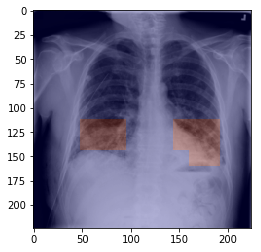

Label pneumonia: 1.0


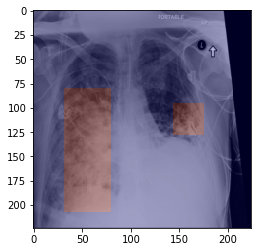

Label pneumonia: 0.0


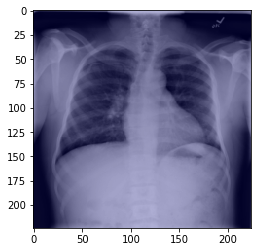

In [118]:
#show how unbalanced dataset is
frequency = np.sum(train_dataset_ex2.targets, axis = 0)/len(train_dataset_ex2)
                
print('Percentage of positive examples for whole images: ' + '{:.2f}'.format(frequency*100) + '%')


frequency = np.sum([grid.numpy() for grid in train_dataset_ex2.grids])/len(train_dataset_ex2)/14/14
print('Percentage of positive examples for grid cells: ' + '{:.2f}'.format(frequency*100) + '%')

def imresize(arr, size, resample):
    return np.array(Image.fromarray(arr).resize(size, resample))

def plot_grid_over_xray(example):
    image = example[0].numpy()[0,:,:]
    print('Label pneumonia: ' + str(example[1][0].cpu().numpy()))
    max1 = np.max(image)
    min1 = np.min(image)
    fig, ax = plt.subplots()
    ax.imshow((image-min1)/(max1 - min1), cmap = 'gray')
    ax.imshow(imresize(example[2].numpy()[0,:,:], (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
    plt.show()

print('\nVisualizing a few examples: ')
#plot a few images from the dataset
# reddish areas mean ones in the grid (pneumonia presence)
#blueish areas mean zeros in the grid (pneumonia absence)
example =  train_dataset_ex2[1]
plot_grid_over_xray(train_dataset_ex2[1])
plot_grid_over_xray(train_dataset_ex2[10])
plot_grid_over_xray(train_dataset_ex2[0])

#### Defining scoring functions for this exercise

In [119]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a spatial grid of scores, for the task
# of localizing where in an image there is evidence for pneumonia
# one of the inputs of this function should be a model with which inference is made
# the model should have one single score as output
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_location_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            # each grid cell target is considered a different example for calculating the score
            # for that, all outputs and target are reshaped to have only one value in the second dimension
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.view([-1,1]).cpu().numpy()), axis = 0)
            targets = np.concatenate((targets, grid.view([-1,1]).cpu().numpy()), axis = 0)
    return auroc(logits_predicted[:,0], targets[:,0])

In [120]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a single score for the task of classifying
# if an image contains evidence for pneumonia or not.
# one of the inputs should be a model with which inference is made
# the model should have one single score as output
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_binary_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0,1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().numpy()), axis = 0)
            
            targets = np.concatenate((targets, target.cpu().numpy()), axis = 0)
    return auroc(logits_predicted, targets)

In [121]:
# defining one of the functions that calculate the AUC score for exercise 2
# it calculates the score for a model that outputs a grid of scores, but this grid is converted
# to a single number to adapt this score to the binary task of saying if the whole image
# has evidence for pneumonia or not
# one of the inputs should be a model with which inference is made
# the model should have one array with 196 (14x14) elements as output, and each output should be a score
# the highest this score is, the highest the probability of this grid cell having evidence for pneumonia
# the other input is a pytorch data loader for whatever set of data for which you want to get a score
def get_score_model_pneumonia_binary_with_location_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0,1])
        targets = np.zeros([0,1])
        
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, target, grid in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            
            #to convert a grid of labels to a single binary logit, we take the maximum logit 
            # in the grid. We do this since having only one grid cell labeled as positive means the whole
            # image should be labeled as having pneumonia.
            logits_predicted = np.concatenate((logits_predicted, torch.max(logit_predicted.view(logit_predicted.shape[0], -1),dim = 1)[0].view(-1,1).cpu().numpy()), axis = 0)
            targets = np.concatenate((targets, target.cpu().numpy()), axis = 0)
    return auroc(logits_predicted[:,0], targets[:,0])

**Q 2.1 (22 points)**: Modify the resnet18 model from PyTorch to output a flattened 14x14 grid, and train it on the pneumonia dataset to get an AUC of at least 0.97 in the validation set. The output of layer3 in the resnet18 model is already 14x14, so you should remove layer4 from the model and use the output of layer3. After getting the desired accuracy, test your best model on the test set. Select a few test examples for which your model got the locations correctly and a few examples with mistakes. Comment and show a visualization for them.

In [126]:
########################################################################################
# Reference https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72
########################################################################################

# Get the device on which training is to be done
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models


########################################################################################
# Parameters
########################################################################################
epochs        = 4
batch_size    = 32
workers       = 4
lr_list       = np.array([0.01, 0.003, 0.001, 0.0003])
lr_decay_step_size = 5
lr_decay_gamma     = 0.1

########################################################################################
# Get the datasplits in place
########################################################################################
train_loader = torch.utils.data.DataLoader(train_dataset_ex2, shuffle = True, batch_size = batch_size, num_workers = workers)
val_loader   = torch.utils.data.DataLoader(val_dataset_ex2  , shuffle = True, batch_size = batch_size, num_workers = workers)
test_loader  = torch.utils.data.DataLoader(test_dataset_ex2 , shuffle = True, batch_size = batch_size, num_workers = workers)


class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

cuda


In [127]:
for i in range(lr_list.shape[0]):
    learning_rate = lr_list[i]
    print("\nLearning rate: {:.4f}".format(learning_rate))
    
    
    ########################################################################################
    # Get the model
    ########################################################################################
    # pretrained=True will download a pretrained network for us
    model = models.resnet18(pretrained=True)

    model.fc = Identity()
    model.layer4 = torch.nn.Conv2d(in_channels = 256, out_channels = 1, kernel_size = 3, padding = 1)
    model.avgpool = Identity()
    

    ########################################################################################
    # Get the loss function
    ########################################################################################
    # Multi-label data in use. Cannot use softmax
    criterion = nn.BCEWithLogitsLoss()
    
    
    ########################################################################################
    # Get the optimizer
    ########################################################################################
    # Over here we want to update all the parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  

    ########################################################################################
    # Start Training
    ########################################################################################
    # Transfer model and loss to the default device
    model     = model.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(epochs):
        
        # model for training
        model.train()
        train_losses = []

        for images, labels, boxes in train_loader:        
            # Transfer variables to the default device
            images = images.to(device)
            labels = labels.to(device)
            boxes  = boxes .to(device)

            # Clear optimizer of previous values
            optimizer.zero_grad()

            # Forward pass
            output = model(images)

            # Calculate loss    
            loss = criterion(output, boxes.reshape(output.shape))
            loss.backward()

            optimizer.step()
            train_losses.append(loss.item())      
        
        auc = get_score_model_pneumonia_location_model(model, val_loader)
        # Printing training loss after each epoch
        print("Epoch: {} Training Loss: {:.6f} Validation AUC: {:.3f}".format(epoch + 1, np.mean(train_losses), np.mean(auc)))
    


Learning rate: 0.0100
Epoch: 1 Training Loss: 0.086039 Validation AUC: 0.927
Epoch: 2 Training Loss: 0.072887 Validation AUC: 0.953
Epoch: 3 Training Loss: 0.069326 Validation AUC: 0.957
Epoch: 4 Training Loss: 0.066493 Validation AUC: 0.955

Learning rate: 0.0030
Epoch: 1 Training Loss: 0.073883 Validation AUC: 0.958
Epoch: 2 Training Loss: 0.064347 Validation AUC: 0.964
Epoch: 3 Training Loss: 0.061912 Validation AUC: 0.959
Epoch: 4 Training Loss: 0.059860 Validation AUC: 0.965

Learning rate: 0.0010
Epoch: 1 Training Loss: 0.071386 Validation AUC: 0.964
Epoch: 2 Training Loss: 0.060710 Validation AUC: 0.969
Epoch: 3 Training Loss: 0.058677 Validation AUC: 0.969
Epoch: 4 Training Loss: 0.056573 Validation AUC: 0.971

Learning rate: 0.0003
Epoch: 1 Training Loss: 0.076863 Validation AUC: 0.968
Epoch: 2 Training Loss: 0.058843 Validation AUC: 0.968
Epoch: 3 Training Loss: 0.055800 Validation AUC: 0.970
Epoch: 4 Training Loss: 0.052470 Validation AUC: 0.971


# Conclusion
Different learning rates with the Adam optimizer with freezing the model and without freezing the model. The batch size is kept at 32 (limited by the GPU I use, I donot want to use smaller batch size since that makes the updates more noisy). The results are as follows

| Learning Rate | AUC Val (Without freezing) |
| ------------- | -------------------------- |
| 0.01    | 0.955 |
| 0.003   | 0.965 |
| 0.001   | 0.971 |
| 0.0003  | 0.971 |

We use the model with learning rate **0.0003 without freezing** any of the layers

In [130]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [220]:
# Pass on test set
auc = get_score_model_pneumonia_location_model(model, test_loader)
print("TEST AUC: {:.3f}".format(np.mean(auc)))

TEST AUC: 0.971


In [246]:
boxes_logit_predicted = []

# Reference - https://github.com/pytorch/examples/blob/master/mnist/main.py
# def test(args, model, device, test_loader)
model.eval()

with torch.no_grad():
    
    #run through several batches, does inference for each and store inference results
    for images, _, _ in test_loader:        
        # Transfer variables to the default device
        images = images.to(device)
        
        # Forward pass
        box_logit_predicted = model(images)
        
        # Unravel the batches in the form of image
        # output is [batch, 196]. Transform to [batch, 14, 14]
        for i in range(box_logit_predicted.shape[0]):
            boxes_logit_predicted.append(box_logit_predicted[i].cpu().numpy().reshape(14,14))

print("Forward Pass done")
print("No of box logits stored = {}".format(len(boxes_logit_predicted)))          

Forward Pass done
No of box logits stored = 5337


In [260]:
right_pred_idx   = []
wrong_pred_idx   = []
boxes_pred       = []


for i in range(1300):#len(test_dataset_ex2)):      
    label_gd = test_dataset_ex2[i][1].numpy().astype(int)[0]
    box_gd   = test_dataset_ex2[i][2].numpy().astype(int)[0] 
    
    # Make logits into a binary mask
    box_pred = np.where(boxes_logit_predicted[i] <= 0, 0., 1.).astype(int)
    boxes_pred.append(box_pred)
        
    #if (label_gd == 1):
    if (np.array_equal(box_pred, box_gd)):
        right_pred_idx  .append(i)
    else:
        wrong_pred_idx  .append(i)


print("Right Pneumonia : {}".format(len(right_pred_idx)))
print("Wrong Pneumonia : {}".format(len(wrong_pred_idx)))
print("Total Pneumonia : {}".format(len(right_pred_idx) + len(wrong_pred_idx)))
print("Test  Samples   : {}".format(len(test_dataset_ex2)))

Right Pneumonia : 786
Wrong Pneumonia : 514
Total Pneumonia : 1300
Test  Samples   : 5337


------------------ Predicted Right ------------------
Label pneumonia: 0.0


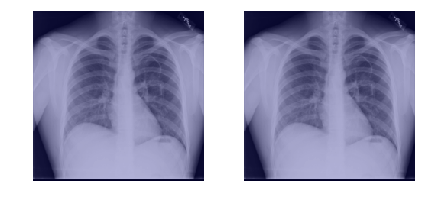

Label pneumonia: 0.0


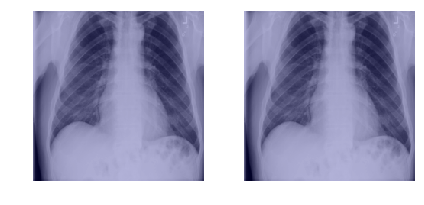

Label pneumonia: 0.0


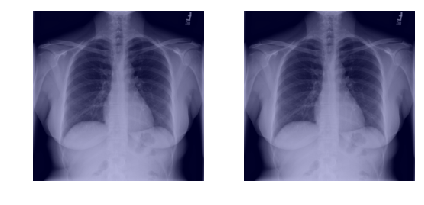


------------------ Predicted Wrong ------------------
Label pneumonia: 1.0


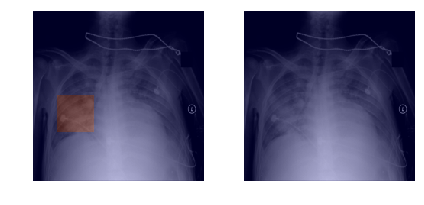

Label pneumonia: 0.0


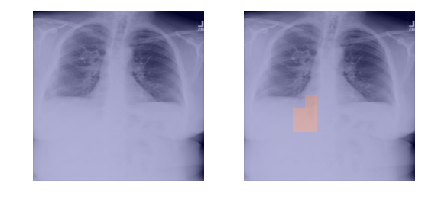

Label pneumonia: 0.0


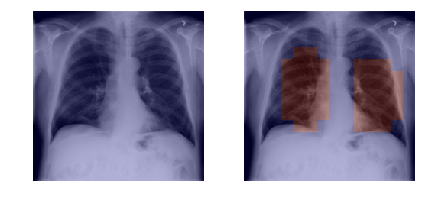

In [269]:
#########################################################################################
# This function plots ground truth and predictions in the same figure using the subplot
# function
# example_pred_box is single channel image
#
# Code based on the earlier function 
# plot_grid_over_xray(example)
# https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python
#########################################################################################
def plot_ground_predicted_over_xray(example, example_pred_box):
    image = example[0].cpu().numpy()[0,:,:]
    print('Label pneumonia: ' + str(example[1][0].cpu().numpy()))
    
    max1  = np.max(image)
    min1  = np.min(image)
    image = (image-min1)/(max1 - min1)
    
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(image, cmap = 'gray')
    plt.imshow(imresize(example[2].cpu().numpy()[0,:,:]    , (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
    plt.tight_layout()
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(image, cmap = 'gray')
    plt.imshow(imresize(example_pred_box.astype(float)     , (224, 224), resample  = Image.NEAREST), cmap='jet', alpha=0.3, resample = True)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

# Number of samples to plot
num_sample = 3

# Convert lists to numpy array for smooth indexing
right_pred_idx = np.array(right_pred_idx)
wrong_pred_idx = np.array(wrong_pred_idx)

# Now plot the right predictions
print("------------------ Predicted Right ------------------")
for i in range(num_sample):
    ind              = right_pred_idx[i]    
    example          = test_dataset_ex2[ind]
    example_pred_box = boxes_pred[ind]
    plot_ground_predicted_over_xray(example, example_pred_box)
    
print("\n------------------ Predicted Wrong ------------------")
for i in range(num_sample):
    ind              = wrong_pred_idx[i]    
    example          = test_dataset_ex2[ind]
    example_pred_box = boxes_pred[ind]
    plot_ground_predicted_over_xray(example, example_pred_box)
    

# Failure Cases
The predictions are wrong sometimes when the grid is extremely small. It also fails somecases on cases when humans might be sure about. This highlights the cases when deep learning models can fail silently without explaination. Explainability remains one of the most hot areas in the current Deep Learning era. 

**Q 2.2 (22 points)**: Modify the resnet18 model from PyTorch to have a single output and the same number of parameters of your model in question 2.1. For training this model, you are only allowed to use the pneumonia binary target for the whole image as ground truth, and you are not allowed to use the grid target. You should be able to achieve an AUC of at least 0.865.

Also train a model just like the one from question 2.1, this time validating with a score for the binary task of presence or absence of pneumonia on an image. This score is calculated by the function ```get_score_model_pneumonia_binary_with_location_model```. When converting from a grid to a single output, this function considers that the probability of an image having pneumonia is the maximum probability over the grid.

Compare both models on their scores for the binary task. Analyze why you got these results. Test your best model for the binary task on the test set.

# Design Consideration
Since we are only  allowed to use the pneumonia binary target for the whole image as ground truth and the not the box/grid target, the pool layer is kept in the model to get single prediction from the image. Since we have to get one output for each image, we use the kernel_size in the pooling map of the same size as the previous feature map. Also, since the maximum probablity is taken into consideration, we go for the max pool layer.

In [288]:
# Get the device on which training is to be done
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models

########################################################################################
# Get the model parameters
########################################################################################
model = models.resnet18(pretrained=True)

model.fc = Identity()
model.layer4 =  torch.nn.Conv2d   (in_channels = 256, out_channels = 1, kernel_size = 3, padding = 1)
model.avgpool = torch.nn.MaxPool2d(kernel_size = 14)

model.to(device)
print("#Parameters in the new model: {}".format(count_number_parameters(model)))
print("\nDetailed report of new model parameters")
summary(model,(3,224,224))

Using device: cuda
#Parameters in the new model: 2785089

Detailed report of new model parameters
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
     

# Parameter Count
The parameter count is exactly the same as the previous model despite using a pooling layer in the output. This is so because a pooling layer does not have any parameters and therefore the parameters of the model remain unchanged.

# Hyperparameter
All hyperparameters - the learning rate and batch size are kept the same as the previous model. 

In [289]:
########################################################################################
# Parameters
########################################################################################
epochs     = 4
batch_size = 32
workers    = 4
learning_rate = 0.0003


########################################################################################
# Get the datasplits in place
########################################################################################
train_loader = torch.utils.data.DataLoader(train_dataset_ex2, shuffle = True, batch_size = batch_size, num_workers = workers)
val_loader   = torch.utils.data.DataLoader(val_dataset_ex2  , shuffle = True, batch_size = batch_size, num_workers = workers)
test_loader  = torch.utils.data.DataLoader(test_dataset_ex2 , shuffle = True, batch_size = batch_size, num_workers = workers)


########################################################################################
# Get the model
########################################################################################
# pretrained=True will download a pretrained network for us
model = models.resnet18(pretrained=True)

model.fc = Identity()
model.layer4 =  torch.nn.Conv2d   (in_channels = 256, out_channels = 1, kernel_size = 3, padding = 1)
model.avgpool = torch.nn.MaxPool2d(kernel_size = 14)


########################################################################################
# Get the loss function
########################################################################################
criterion = nn.BCEWithLogitsLoss()


########################################################################################
# Get the optimizer
########################################################################################
# Over here we want to update all the parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


########################################################################################
# Start Training
########################################################################################
# Transfer model and loss to the default device
model     = model.to(device)
criterion = criterion.to(device)

for epoch in range(epochs):

    # model for training
    model.train()
    train_losses = []

    for images, labels, _ in train_loader:        
        # Transfer variables to the default device
        # boxes should not be used
        images = images.to(device)
        labels = labels.to(device)

        # Clear optimizer of previous values
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss not based on boxes but based on labels solely
        loss = criterion(output, labels)
        loss.backward()

        optimizer.step()
        train_losses.append(loss.item())

    # Scoring is done by a different function
    auc = get_score_model_pneumonia_binary_with_location_model(model, val_loader)
    
    # Printing training loss after each epoch
    print("Epoch: {} Training Loss: {:.6f} Validation AUC: {:.3f}".format(epoch + 1, np.mean(train_losses), np.mean(auc)))

    
# Pass on test set
auc = get_score_model_pneumonia_binary_with_location_model(model, test_loader)
print("TEST AUC: {:.3f}".format(np.mean(auc)))

Epoch: 1 Training Loss: 0.403395 Validation AUC: 0.854
Epoch: 2 Training Loss: 0.369895 Validation AUC: 0.871
Epoch: 3 Training Loss: 0.351546 Validation AUC: 0.868
Epoch: 4 Training Loss: 0.333519 Validation AUC: 0.865
TEST AUC: 0.854


# Now, we train a model similar to Q2.1 but score with a different scoring function

In [292]:
########################################################################################
# Parameters
########################################################################################
epochs     = 4
batch_size = 32
workers    = 4
learning_rate = 0.0003


########################################################################################
# Get the datasplits in place
########################################################################################
train_loader = torch.utils.data.DataLoader(train_dataset_ex2, shuffle = True, batch_size = batch_size, num_workers = workers)
val_loader   = torch.utils.data.DataLoader(val_dataset_ex2  , shuffle = True, batch_size = batch_size, num_workers = workers)
test_loader  = torch.utils.data.DataLoader(test_dataset_ex2 , shuffle = True, batch_size = batch_size, num_workers = workers)


########################################################################################
# Get the model
########################################################################################
# pretrained=True will download a pretrained network for us
model = models.resnet18(pretrained=True)

model.fc = Identity()
model.layer4 = torch.nn.Conv2d(in_channels = 256, out_channels = 1, kernel_size = 3, padding = 1)
model.avgpool = Identity()


########################################################################################
# Get the loss function
########################################################################################
# Multi-label data in use. Cannot use softmax
criterion = nn.BCEWithLogitsLoss()


########################################################################################
# Get the optimizer
########################################################################################
# Over here we want to update all the parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


########################################################################################
# Start Training
########################################################################################
# Transfer model and loss to the default device
model     = model.to(device)
criterion = criterion.to(device)

for epoch in range(epochs):

    # model for training
    model.train()
    train_losses = []

    for images, labels, boxes in train_loader:        
        # Transfer variables to the default device
        images = images.to(device)
        labels = labels.to(device)
        boxes  = boxes .to(device)

        # Clear optimizer of previous values
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss    
        loss = criterion(output, boxes.reshape(output.shape))
        loss.backward()

        optimizer.step()
        train_losses.append(loss.item())      

    auc = get_score_model_pneumonia_binary_with_location_model(model, val_loader)
    # Printing training loss after each epoch
    print("Epoch: {} Training Loss: {:.6f} Validation AUC: {:.3f}".format(epoch + 1, np.mean(train_losses), np.mean(auc)))

# Pass on test set
auc = get_score_model_pneumonia_binary_with_location_model(model, test_loader)
print("TEST AUC: {:.3f}".format(np.mean(auc)))

Epoch: 1 Training Loss: 0.078072 Validation AUC: 0.870
Epoch: 2 Training Loss: 0.058501 Validation AUC: 0.877
Epoch: 3 Training Loss: 0.056044 Validation AUC: 0.883
Epoch: 4 Training Loss: 0.052913 Validation AUC: 0.880
TEST AUC: 0.875


# Conclusion
Two different models were trained with changes in the architecture to predict - one that used the box information and one that doesnot.

| Architecture  |  Output  | AUC on Test |
| ------------- |--------- | ----------- |
| same as Q2.1  | Box      | 0.875 |
| new  (Q2.2)   | A number | 0.854 |

This is expected because of two reasons -
<ul>
<li>The architecture in Q2.1 has more access to information since it knows exactly where the grids are and therefore can take a well informed decision.
<li>The second architecture since it employs a pooling layer is susceptible to noise because any one of the pixels in the final feature map being 1 makes the output 1. This might be present anywhere (say at the top of the xray) while the first architecture knows that the boxes/grids can not happen in the top one third of the image and therefore it knows to supress the noisy 1 there.
</ul>
